# Предсказание вероятности возврата кредита клиентом компании

Предоставлена информация из анкетных данных заемщиков, данных об итогах уже выданных кредитов и факт наступления дефолта.

Цель: предсказать возврат кредита клиентом с просрочкой не более 90 дней.

Задачи: построить эффективную скоринговую модель, которая бы предсказывала наступление дефолта клиента. Для этого используем различные алгоритмы классификации: логистическую регрессию, XGBoost и CatBoost, посмотрим, какая из них выдаст лучший результат.

Поэтапное описание работы: 
-анализ исходных данных (проверка на дубликаты и выбросы); 
-корреляционный анализ с целью выявить, какие признаки оставить для постороения модели;
-построение наивной модели;
-подготовка данных для машинного обучения;
-построение модели Логистичесткой регргессии;
-построение модели XGBoost;
-построение модели CatBoost;
-подбор параметров для модели XGBoost

В качестве метрики для оценки качества модели был взят коэффициент Gini, который оценивает ранжирующую способность модели.

#1. Подготовка к работе

##1.1 Импорт необходимых библиотек

In [ ]:
from pandas import Series
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from itertools import combinations
from scipy.stats import ttest_ind

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler

import os
import pandas_profiling

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)


In [ ]:
# Зафиксируем Random_seed для воспроизводимости экспериментов
random_seed = 42

In [ ]:
# Зафиксируем версию пакетов для воспроизводимости экспериментов
!pip freeze > requirements.txt

###1.2 Определение функций

In [ ]:
#Функция для анализа категориальных и бинарных признаков
def cat_stats(column):
    display(column.astype('object').describe(),
    column.value_counts(),
    column.hist()),
    print(f'Данный признак содержит {column.isna().sum()} пропусков')    

In [ ]:
#Функция для анализа числовых признаков
def num_stats(column):
    display(column.describe())
    sns.distplot(column).get_figure(),
    print(f'Данный признак содержит {column.isna().sum()} пропусков')

#2. Импорт и анализ данных

Данные представлены единым датасетом, столбец "Default" - наша целевая переменная. Загрузим наш csv-файл.

In [ ]:
xls = pd.ExcelFile('Basa_for_test.xlsx')
data = pd.read_excel(xls, 'Test', index_col=None)
data.head()

Gender  FactPostalCode  RegisterPostalCode  RegisterPhone  Register_Fact  \
0       1           142.0                 142              0              1   
1       2           644.0                 644              0              1   
2       2           662.0                 662              0              0   
3       2           153.0                 153              0              1   
4       2           157.0                 157              1              1   

  EarlierCredits  Default  age  N_Loans  perc_amount  N_365  last_payment  \
0            NaN        0   40        1     0.620701      1             5   
1    два и более        0   31        4     0.055000      4             5   
2            NaN        1   22        2     0.046000      2             1   
3    два и более        1   30        1     0.510000      1            67   
4            NaN        1   36        1     0.320000      1            75   

   N_90_365  s_Amount  s_Credit_befo_RD  s_Credit_15  s_Credit_30  \
0       1.0      5300               0.0          0.0          0.0   
1       1.0      9000            9495.0          0.0          0.0   
2       1.0      5000            5230.0          0.0          0.0   
3       0.0      5000            2250.0       5300.0       5300.0   
4       0.0      2000               0.0       2640.0       2640.0   

   s_Credit_90  s_Credit_90_RD  Dola_RD_1  Dola_RD_2  Dola_RD_3  Dola_15_90  \
0      8589.72         8589.72        0.0        0.0        0.0         0.0   
1         0.00         9495.00        1.0        1.0        1.0         NaN   
2         0.00         5230.00        1.0        1.0        1.0         NaN   
3      5300.00         7550.00        0.0        0.0        NaN         NaN   
4      2640.00         2640.00        0.0        0.0        NaN         NaN   

   Dola_60_90  a_sum_Credit_700  a_sum_Credit_365  a_sum_Credit_180  \
0         1.0           8589.72           8589.72           8589.72   
1         0.0           2373.75           2373.75           2373.75   
2         0.0           2615.00           2615.00           2615.00   
3         NaN           7550.00           7550.00           7550.00   
4         NaN           2640.00           2640.00           2640.00   

   a_sum_Credit_90  s_Amount_30  s_Amount_60  s_Amount_90  s_Amount_180  \
0          8589.72            0            0         5300          5300   
1          2373.75         2000         9000         9000          9000   
2          2615.00         5000         5000         5000          5000   
3             0.00            0            0            0          5000   
4             0.00            0            0            0          2000   

   s_Amount_360  s_Amount_500  cred_hist_1  cred_hist_2  cred_hist_3  \
0          5300          5300           69           69           69   
1          9000          9000           47            6            6   
2          5000          5000           10            8            8   
3          5000          5000          101          101          101   
4          2000          2000          107          107          107   

   Cred_Deb_2  Cred_Deb_AmRe  Cred_Deb_AmRe_01  Cred_Deb_AmRe_02  \
0      4.2949         1.6449               0.0               NaN   
1      1.3564         0.0707               0.0               NaN   
2      1.3075         0.0575               0.0               NaN   
3      2.5167         0.8500               0.0               NaN   
4      0.8800         0.2133               0.0               NaN   

   Cred_Deb_AmRe_1  Cred_Deb_Deb  a_cnt_cred_45  a_cnt_cred_90  \
0           1.6449      0.620701            NaN            1.0   
1           0.0707      0.055000            3.0            4.0   
2           0.0575      0.046000            2.0            2.0   
3           0.8500      0.510000            NaN            NaN   
4           0.2133      0.320000            NaN            NaN   

   a_cnt_cred_135  a_cnt_cred_180  a_cnt_cred_700  a_cnt_c

In [ ]:
df = data.copy()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8461 entries, 0 to 8460
Columns: 300 entries, Gender to totalRecurrentAmount
dtypes: float64(228), int64(71), object(1)
memory usage: 19.4+ MB


In [ ]:
df.shape

(8461, 300)

##2.1 Посмотрим на типы данных и наличие пропусков в данных:

In [ ]:
def param_data(data):
    """dataset required parameters """
    param = pd.DataFrame({
              'dtypes': data.dtypes.values,
              'nunique': data.nunique().values,
              'isna': data.isna().sum().values,
              'loc[0]': data.iloc[0].values,
              #'min': data.min().values,
              #'max': data.max().values 
              }, 
             index = data.iloc[0].index)
    return param

param_data(df)

dtypes  nunique  isna       loc[0]
Gender                           int64        2     0            1
FactPostalCode                 float64      210    96          142
RegisterPostalCode               int64      210     0          142
RegisterPhone                    int64        2     0            0
Register_Fact                    int64        2     0            1
EarlierCredits                  object        3  4272          NaN
Default                          int64        2     0            0
age                              int64       54     0           40
N_Loans                          int64       44     0            1
perc_amount                    float64     2560     0     0.620701
N_365                            int64       22     0            1
last_payment                     int64      413     0            5
N_90_365                       float64       61   181            1
s_Amount                         int64      453     0         5300
s_Credit_befo_RD               float64     2346     0            0
s_Credit_15                    float64      569     0            0
s_Credit_30                    float64      699     0            0
s_Credit_90                    float64      838     0      8589.72
s_Credit_90_RD                 float64     2861     0      8589.72
Dola_RD_1                      float64     1678   135            0
Dola_RD_2                      float64     1617   194            0
Dola_RD_3                      float64      629  1139            0
Dola_15_90                     float64       27  7250            0
Dola_60_90                     float64      629  1139            1
a_sum_Credit_700               float64     2644     0      8589.72
a_sum_Credit_365               float64     2594     0      8589.72
a_sum_Credit_180               float64     2460     0      8589.72
a_sum_Credit_90                float64     2264     0      8589.72
s_Amount_30                      int64       72     0            0
s_Amount_60                      int64      112     0            0
s_Amount_90                      int64      145     0         5300
s_Amount_180                     int64      252     0         5300
s_Amount_360                     int64      348     0         5300
s_Amount_500                     int64      379     0         5300
cred_hist_1                      int64      978     0           69
cred_hist_2                      int64      444     0           69
cred_hist_3                      int64      444     0           69
Cred_Deb_2                     float64     3321     0       4.2949
Cred_Deb_AmRe                  float64     2435     0       1.6449
Cred_Deb_AmRe_01               float64      126     0            0
Cred_Deb_AmRe_02               float64      125  8319          NaN
Cred_Deb_AmRe_1                float64     1894     0       1.6449
Cred_Deb_Deb                   float64     2560     0     0.620701
a_cnt_cred_45                  float64       10  2098          NaN
a_cnt_cred_90                  float64       12  1139            1
a_cnt_cred_135                 float64       14   443            1
a_cnt_cred_180                 float64       14   336            1
a_cnt_cred_700                 float64       30   122            1
a_cnt_cred_365                 float64       21   181            1
miAmount_45                    float64       87  2098          NaN
miAmount_90                    float64       96  1139         2.65
miAmount_180                   float64       96   336         2.65
Amount_45                      float64      108  2098          NaN
Amount_90                      float64      134  1139         2.65
Amount_180                     float64      152   336         2.65
Amount_365                     float64      171   181         2.65
n_cr_1                           int64      319     0          107
n_cr_2                           int64      429     0          109
n_cr_12                          int64      252     0           -2
n_cr_3      

In [ ]:
#Удалим дубликаты, если есть:
df.drop_duplicates()
df.shape

(8461, 300)

##2.2 Посмотрим на целевую переменную Default:

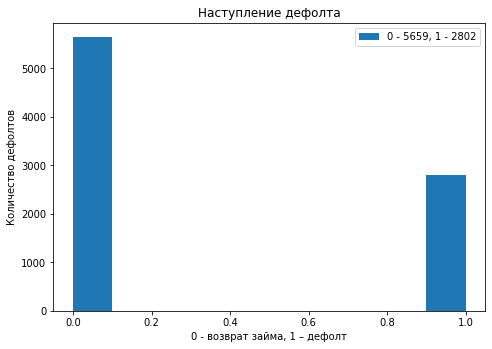

In [ ]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1])
axes.hist(df['Default'], label = '0 - 5659, 1 - 2802')
axes.set_title('Наступление дефолта')
axes.set_ylabel('Количество дефолтов')
axes.set_xlabel('0 - возврат займа, 1 – дефолт')
axes.legend(loc = 1)

In [ ]:
display(df.Default.value_counts())
print(f'Данный признак содержит {df.Default.isna().sum()} пропусков')
#0 означает возврат займа, 1 – дефолт.

0    5659
1    2802
Name: Default, dtype: int64

Данный признак содержит 0 пропусков


Сотношение классов 2 к 1. Нужно будет это учесть при разделении выборки на тренировочную и тестовую, чтобы не было сильного перевеса одного из классов.

In [ ]:
#import pandas_profiling

#profile = df.profile_report(title='Pandas Profiling Report', progress_bar=True)
#print(profile)

In [ ]:
#profile.to_notebook_iframe() - закончилась ОЗУ у коллаба

# 3. EDA

Разделим признаки на бинарные, категориальные и числовые:

In [ ]:
# бинарные переменные
bin_cols = ['Gender', 'RegisterPhone', 'Register_Fact']


# категориальные переменные
cat_cols = ['FactPostalCode', 'RegisterPostalCode', 'EarlierCredits']

# числовые переменные
num_cols = ['age, ''N_Loans', 'perc_amount', 'N_365', 'last_payment', 'N_90_365', 's_Amount', 's_Credit_befo_RD', 's_Credit_15',
 's_Credit_30', 's_Credit_90', 's_Credit_90_RD', 'Dola_RD_1', 'Dola_RD_2', 'Dola_RD_3', 'Dola_15_90', 'Dola_60_90', 'a_sum_Credit_700',
 'a_sum_Credit_365', 'a_sum_Credit_180', 'a_sum_Credit_90', 's_Amount_30', 's_Amount_60', 's_Amount_90', 's_Amount_180', 's_Amount_360',
 's_Amount_500', 'cred_hist_1', 'cred_hist_2', 'cred_hist_3', 'Cred_Deb_2', 'Cred_Deb_AmRe', 'Cred_Deb_AmRe_01', 'Cred_Deb_AmRe_1',
 'Cred_Deb_Deb', 'a_cnt_cred_45', 'a_cnt_cred_90', 'a_cnt_cred_135', 'a_cnt_cred_180', 'a_cnt_cred_700', 'a_cnt_cred_365',
 'miAmount_45', 'miAmount_90', 'miAmount_180', 'Amount_45', 'Amount_90', 'Amount_180', 'Amount_365','n_cr_1', 'n_cr_2',
 'n_cr_12', 'n_cr_3', 're_cred_1', 're_cred_2', 're_cred_3', 'persent_loan', 'cred_sum_1', 'cred_sum_2', 'cred_sum_3',
 'cred_sum_22', 'cred_sum_33', 'cred_dura_1', 'cred_dura_2', 'cred_dura_3', 'delay5_1', 'delay5_2', 'delay5_3', 'delay5_22',
 'delay5_33', 'delay30_1', 'delay30_2', 'delay30_3', 'delay60_1', 'delay60_2', 'delay60_3', 'delay90_1', 'delay90_2', 'delay90_3',
 'delay_more_1', 'delay_more_2', 'delay_more_3', 'delay5_30_365', 'delay5_30_60_365','cred_type_1', 'cred_type_2', 'cred_type_3',
 'partner_type_1', 'partner_type_2', 'partner_type_3', 'cred_repay_1', 'cred_repay_2', 'cred_repay_3', 'cred_activ_1',
 'cred_activ_2', 'cred_activ_3', 'all_act_cred_3', 'all_act_cred_1', 'all_act_cred_3_1', 'all_act_cred_2', 'all_act_3_1_d',
 'all_cred_rep_3', 'all_cred_rep_1', 'all_cred_rep_13', 'all_cred_rep_11', 'all_rep_cred_1', 'all_act_cred', 'all_act_cred_s','test_1',
 'sum_debt', 'sum_debt_1', 'sum_limit', 'sum_overdue', 'day_overdue', 'max_overdue', 'max_overdue_1',
 'max_overdue_2', 'max_overdue_3', 'prolong', 'ti_hour', 'ti_day', 'ti_week', 'ti_week_all', 'ti_month', 'ti_month_all', 'ti_quarter',
 'ti_year', 'cred_date_last', 'cred_date_last_1', 'cred_date_last_2', 'sum_debt_last', 'hist_days', 'hist_days_m', 'dog_bad',
 'dog_bad_360', 'dog_bad_1080', 'sum_over_1080', 'sum_over_720', 'sum_over_360', 'sum_over_1_89', 'sum_over_90', 'sum_over_89_90',
 'avg_over_1_90', 'sum_over_9000', 'sum_mfo', 'over_mfo', 'сoun_over_mfo', 'сount_cls_mfo', 'p_cls_mfo_365', 'sum_12_month',
 'avg_12_month','Count_0', 'Count_1', 'Count_2', 'Count_3', 'Count_4', 'Count_5', 'Count_6', 'Count_7', 'Count_8', 'Count_9',
 'Count_B', 'Count_C', 'Count_I', 'Count_R', 'Count_S', 'Count_Sp', 'Count_W', 'Count_0_len_num',
 'Count_01_len_num', 'Count_12_len_num', 'Count_456_len_num', 'Count_5B_len_num', 'Count_C_len_num', 'Count_Sp_len_num',
 'N_record_IP', 'min_hist_IPDate', 'max_hist_IPDate', 'min_hist_RIDDate', 'max_hist_RIDDate', 'min_hist_IPEndDate',
 'max_hist_IPEndDate', 'max_Summa', 'sum_RIDDate_365', 'sum_RIDDate_180', 'sum_RIDDate_730', 'cred_count', 'cred_summ',
 'st_NULL__180_sum', 'st_NULL__365_sum', 'st_NULL__730_sum', 'st_NULL__180_count', 'st_NULL__365_count', 'st_NULL__730_count',
 'F_NumR_30_90', 'F_NumR_30_180', 'F_NumR_60_180', 'F_NumR_90_all', 'F_NumCP_30_90', 'F_NumCP_30_180', 'F_NumCP_60_180',
 'F_NumCP_90_all', 'F_MFO_Date_lT', 'F_MFO_Date_SD', 'F_MFO_Date_SR', 'F_MFO_Date_TF', 'F_MFO_Date_DD', 'F_MFO_Date_RD',
 'F_long_PhNum', 'F_long_Card', 'F_long_SA', 'F_mfoCFor_30_90', 'F_mfoCFor_30_180', 'F_mfoCFor_90_180', 'F_mfoCFor_180_30',
 'F_mfoCFor_180_90', 'F_mfoCFor_90_30', 'F_IssAmnt', 'F_RecAmnt', 'F_Dis_Iss', 'F_mfo_IFor_30_90', 'F_mfo_IFor_30_180',
 'F_mfo_IFor_90_180', 'F_cny_IFor_30_90', 'F_cny_IFor_30_180', 'F_cny_IFor_90_180', 'F_NCrdPh_30_90', 'F_NCrdPh_30_360',
 'F_NCrdPh_90_360','F_NCrPh_cnt1', 'F_NCrPh_cnt2', 'F_NumCP_60_360', 'F_fTMFO_Pass', 'F_FDSA_Pass', 'F_NumRDL_3_14',
 'F_NumRDL_7_14', 'F_IpNet_180_365', 'F_IpNeZ_30', 'F_IpNeZ_180', 'F_IpNeZ_365', 'CntPhoneUser_SameApD', 'cntallcardsusers',
 'CntCardUser_SameAp', 'cntcardusers', 'CntPhoneUser_SameApC', 'cntUserAplIP', 'countIssuedFor180Days', 'countIssuedFor30Days',
 'countIssuedFor90Days', 'FinKartaScoreV1_group', 'FinKartaScoreV1_rate', 'FinKartaScoreV2_rate', 'lastDischargeAmount',
 'lastRecurrentAmount', 'lastSuccessfulDischargeAmount', 'lastSuccessfulRecurrentAmount', 'mfoCountFor180Days', 'mfoCountFor30Days',
 'mfoCountFor90Days', 'mfoIssuedFor180Days', 'mfoIssuedFor30Days', 'mfoIssuedFor90Days','Num_cellph_SP_120', 'Num_cellph_SP_180',
 'Num_cellph_SP_30', 'Num_cellph_SP_360', 'Num_cellph_SP_60', 'Num_cellph_SP_90', 'Num_cellph_SP_all', 'NumCrdPhone_120',
 'NumCrdPhone_180', 'NumCrdPhone_30', 'NumCrdPhone_360', 'NumCrdPhone_60', 'NumCrdPhone_90', 'NumCrdPhone_all', 
 'NumR_DIL_14', 'NumR_DIL_180', 'NumR_DIL_3', 'NumR_DIL_30', 'NumR_DIL_360', 'NumR_DIL_60', 'NumR_DIL_7', 'NumR_DIL_90', 'NumR_DIL_all',
 'totalDischargeAmount', 'totalIssuedAmount', 'totalRecurrentAmount']

##3.1. Проанализируем бинарные и категориальные признаки

count     8461
unique       2
top          1
freq      4657
Name: Gender, dtype: int64

1    4657
2    3804
Name: Gender, dtype: int64

Данный признак содержит 0 пропусков


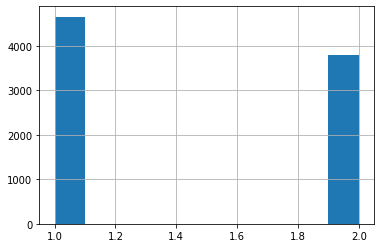

In [ ]:
cat_stats(df.Gender)

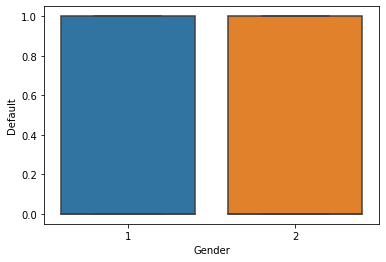

In [ ]:
sns.boxplot(y = 'Default', x = 'Gender', data=df)

count     8365.0
unique     210.0
top        141.0
freq       346.0
Name: FactPostalCode, dtype: float64

141.0    346
142.0    311
143.0    241
127.0    195
140.0    189
117.0    177
109.0    157
115.0    135
111.0    120
188.0    119
125.0    118
350.0    109
450.0    106
353.0     99
454.0     98
423.0     98
443.0     95
628.0     94
630.0     93
420.0     92
620.0     89
456.0     86
625.0     84
198.0     84
603.0     83
344.0     82
119.0     81
606.0     76
644.0     74
400.0     71
301.0     69
121.0     69
129.0     69
346.0     68
194.0     68
357.0     67
426.0     65
629.0     64
614.0     64
607.0     62
660.0     61
300.0     59
107.0     58
196.0     57
452.0     57
453.0     57
123.0     55
195.0     55
618.0     54
623.0     54
108.0     54
352.0     53
249.0     53
652.0     52
445.0     52
197.0     50
394.0     50
601.0     50
692.0     50
428.0     49
192.0     48
432.0     48
446.0     47
414.0     45
184.0     43
398.0     41
690.0     39
392.0     39
624.0     39
427.0     39
399.0     35
680.0     35
150.0     35
170.0     34
460.0     34
632.0     33
404.0     33

Данный признак содержит 96 пропусков


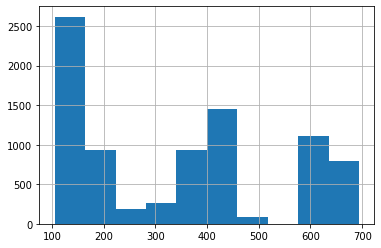

In [ ]:
cat_stats(df.FactPostalCode)

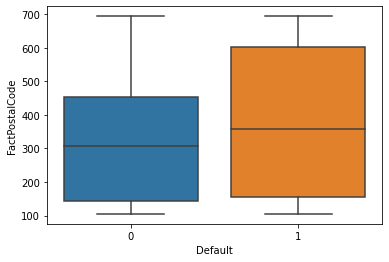

In [ ]:
sns.boxplot(y = 'FactPostalCode', x = 'Default', data=df)

count     8461
unique     210
top        141
freq       311
Name: RegisterPostalCode, dtype: int64

141    311
142    281
143    207
140    163
117    136
127    128
353    127
188    114
109    114
115    112
423    110
111    108
628    104
450     99
125     98
456     97
630     91
603     90
346     87
420     84
454     81
606     79
301     78
357     77
400     76
443     75
453     74
198     73
620     71
607     70
644     69
350     68
625     66
623     66
452     66
601     66
129     65
629     64
352     64
426     63
446     63
121     63
171     62
394     60
119     59
249     59
445     58
614     58
300     58
197     58
618     58
432     56
428     55
344     55
309     54
660     54
692     53
196     53
108     53
194     53
652     51
195     49
347     49
107     48
461     45
392     45
427     44
624     44
414     44
123     43
391     43
184     43
192     41
413     41
460     41
399     40
429     39
308     38
403     38
404     38
169     38
690     38
632     36
658     36
410     36
680     36
393     36
442     35
303     35
398     34
215     34

Данный признак содержит 0 пропусков


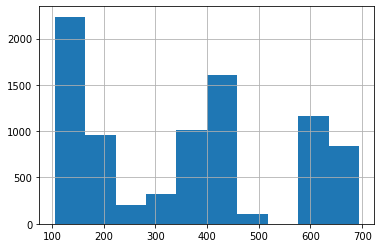

In [ ]:
cat_stats(df.RegisterPostalCode)

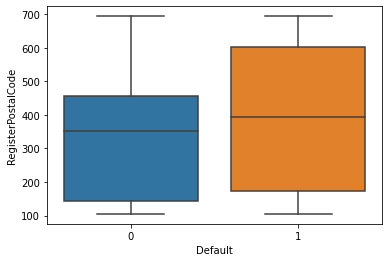

In [ ]:
sns.boxplot(y = 'RegisterPostalCode', x = 'Default', data=df)

У признака RegisterPostalCode нет пропусков, а у признака FactPostalCode есть 96 пропусков. 
Скорее всего, многие клиенты не запоняли фактический почтовый индекс, потому что он совпадает с индексом по регистрации. 
Заменим пропуски в FactPostalCode на аналогичные значения RegisterPostalCode

In [ ]:
df.FactPostalCode = df.apply(lambda x: x.RegisterPostalCode if pd.isna(x.FactPostalCode) else x.FactPostalCode, axis=1)

In [ ]:
df.FactPostalCode.isna().sum()

0

Если мы посторим на распредление почтовых индексов, мы увидим, что оно случайное и никак не коррелирует с целевой переменной. 

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'Распределение почтовых кодов от целевой переменной')

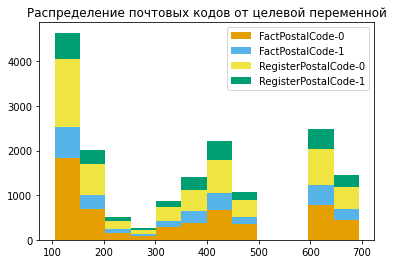

In [ ]:
x1 = list(df[df['Default']==0]['FactPostalCode'])
x2 = list(df[df['Default']==1]['FactPostalCode'])
x3 = list(df[df['Default']==0]['RegisterPostalCode'])
x4 = list(df[df['Default']==1]['RegisterPostalCode'])

# Assign colors for each airline and the names
colors = ['#E69F00', '#56B4E9', '#F0E442', '#009E73']
names = ['FactPostalCode-0', 'FactPostalCode-1','RegisterPostalCode-0', 'RegisterPostalCode-1']
         
# Make the histogram using a list of lists
# Normalize the flights and assign colors and names
plt.hist([x1, x2, x3, x4], bins = int(180/15), stacked=True,
      color = colors, label=names)

# Plot formatting
plt.legend()
plt.title('Распределение почтовых кодов от целевой переменной')

Попробуем закодировать их на основании Коэффициента вхождения положительного класса в целевую переменную - применим к почтовым кодам mean-encoding. С математической точки зрения среднее кодирование представляет собой Вероятность целевой переменной, зависящей от каждого значения функции. В некотором смысле, он воплощает целевую переменную в своем закодированном значении.

In [ ]:
Mean_encoded_subject = df.groupby(['FactPostalCode'])['Default'].mean().to_dict() 
df['FactPostalCode'] =  df['FactPostalCode'].map(Mean_encoded_subject) 
df['FactPostalCode'].value_counts()

0.263006    346
0.296296    324
0.276527    311
0.333333    288
0.200000    220
0.266667    210
0.303665    191
0.400000    185
0.288136    177
0.369048    168
0.248408    157
0.250000    136
0.461538    130
0.317073    123
0.258333    120
0.228814    118
0.384615    117
0.363636    110
0.229358    109
0.339623    106
0.403846    104
0.330097    103
0.411765    102
0.455446    101
0.285714     98
0.326531     98
0.350515     97
0.301075     93
0.260870     92
0.370787     89
0.325581     86
0.421687     83
0.407407     81
0.209877     81
0.350000     80
0.263158     76
0.289474     76
0.310811     74
0.397260     73
0.444444     72
0.485714     70
0.318841     69
0.176471     68
0.328358     67
0.257576     66
0.507692     65
0.187500     64
0.274194     62
0.278689     61
0.316667     60
0.366667     60
0.224138     58
0.350877     57
0.392857     56
0.290909     55
0.518519     54
0.351852     54
0.185185     54
0.423077     52
0.307692     52
0.431373     51
0.392157     51
0.280000

In [ ]:
Mean_encoded_subject = df.groupby(['RegisterPostalCode'])['Default'].mean().to_dict() 
df['RegisterPostalCode'] =  df['RegisterPostalCode'].map(Mean_encoded_subject) 
df['RegisterPostalCode'].value_counts()

0.333333    468
0.273312    311
0.270463    281
0.285714    224
0.400000    220
0.363636    209
0.304348    207
0.187500    176
0.500000    168
0.306748    163
0.375000    160
0.301471    136
0.265625    128
0.433071    127
0.254386    114
0.280702    114
0.318182    110
0.188679    106
0.353535     99
0.204082     98
0.329897     97
0.416667     96
0.384615     91
0.409091     88
0.367816     87
0.297619     84
0.250000     84
0.437500     80
0.278481     79
0.307692     78
0.298701     77
0.210526     76
0.381579     76
0.200000     75
0.386667     75
0.364865     74
0.260274     73
0.352113     71
0.271429     70
0.428571     70
0.289855     69
0.393939     66
0.378788     66
0.348485     66
0.276923     65
0.253968     63
0.301587     63
0.396825     63
0.225806     62
0.220339     59
0.372881     59
0.431034     58
0.224138     58
0.293103     58
0.413793     58
0.379310     58
0.362069     58
0.396552     58
0.263158     57
0.259259     54
0.296296     54
0.150943     53
0.433962

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'Распределение почтовых кодов от целевой переменной')

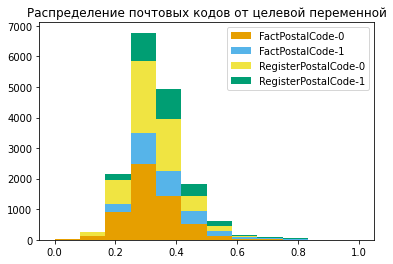

In [ ]:
x1 = list(df[df['Default']==0]['FactPostalCode'])
x2 = list(df[df['Default']==1]['FactPostalCode'])
x3 = list(df[df['Default']==0]['RegisterPostalCode'])
x4 = list(df[df['Default']==1]['RegisterPostalCode'])

# Assign colors for each airline and the names
colors = ['#E69F00', '#56B4E9', '#F0E442', '#009E73']
names = ['FactPostalCode-0', 'FactPostalCode-1','RegisterPostalCode-0', 'RegisterPostalCode-1']
         
# Make the histogram using a list of lists
# Normalize the flights and assign colors and names
plt.hist([x1, x2, x3, x4], bins = int(180/15), stacked=True,
      color = colors, label=names)

# Plot formatting
plt.legend()
plt.title('Распределение почтовых кодов от целевой переменной')

Распредление выглядит более структурированным и близким к нормальному.

count     8461
unique       2
top          0
freq      5666
Name: RegisterPhone, dtype: int64

0    5666
1    2795
Name: RegisterPhone, dtype: int64

Данный признак содержит 0 пропусков


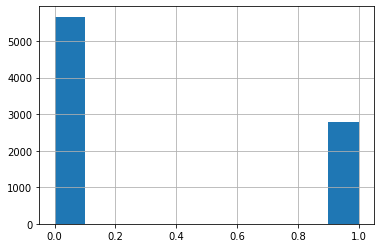

In [ ]:
cat_stats(df['RegisterPhone'])

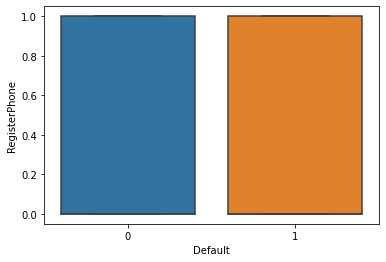

In [ ]:
sns.boxplot(y = 'RegisterPhone', x = 'Default', data=df)

count     8461
unique       2
top          1
freq      7355
Name: Register_Fact, dtype: int64

1    7355
0    1106
Name: Register_Fact, dtype: int64

Данный признак содержит 0 пропусков


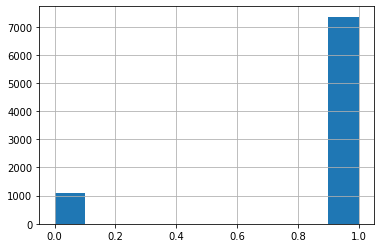

In [ ]:
cat_stats(df['Register_Fact'])

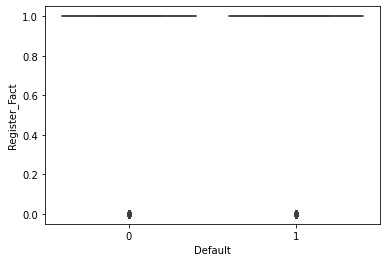

In [ ]:
sns.boxplot(y = 'Register_Fact', x = 'Default', data=df)

count            4189
unique              3
top       два и более
freq             2876
Name: EarlierCredits, dtype: object

два и более    2876
один            732
не брал         581
Name: EarlierCredits, dtype: int64

Данный признак содержит 4272 пропусков


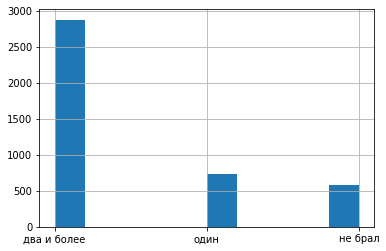

In [ ]:
#количество ранее взятых кредитов
cat_stats(df['EarlierCredits'])

In [ ]:
#Применим LabelEncoder для кодировки нашего признака
df['EarlierCredits'] = df['EarlierCredits'].astype('category').cat.codes
labelencoder = LabelEncoder()
df['EarlierCredits'] = labelencoder.fit_transform(df['EarlierCredits'])        

count     8461
unique       4
top          0
freq      4272
Name: EarlierCredits, dtype: int64

0    4272
1    2876
3     732
2     581
Name: EarlierCredits, dtype: int64

Данный признак содержит 0 пропусков


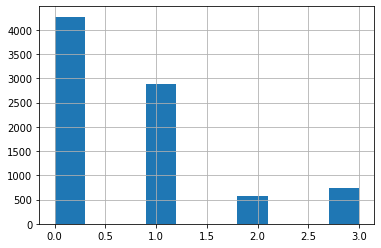

In [ ]:
cat_stats(df['EarlierCredits'])

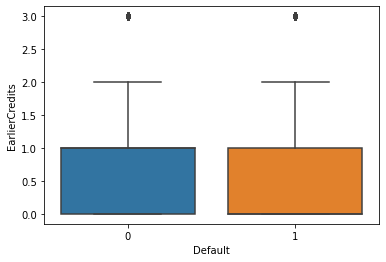

In [ ]:
sns.boxplot(y = 'EarlierCredits', x = 'Default', data=df)

##Посмотрим вляние бинарных и категориальных признаков на целевую переменную

Для оценки значимости категориальных и бинарных переменных будем использовать функцию mutual_info_classif из библиотеки sklearn. Данная функция опирается на непараметрические методы, основанные на оценке энтропии в группах категориальных переменных.

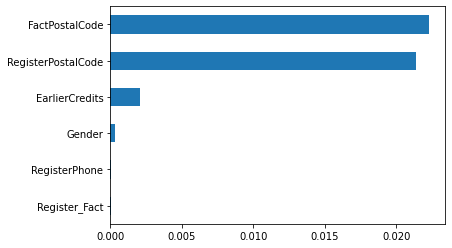

In [ ]:
imp_cat = Series(mutual_info_classif(df[bin_cols + cat_cols], df['Default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Предсказуемо коррелируеют между собой признаки FactPostalCode и RegisterPostalCode. Оставим FactPostalCode как более релевантный признак. На целевую переменную влияет признак EarlierCredits и Gender. RegisterPhone и Register_Fact судя по боксплотам и по рузультатам mutual_info_classif не влияют на целевую переменную. Итог: для целевой переменной значимы следующие признаки: FactPostalCode, EarlierCredits и Gender, но пока ничего удалять не будем.

##3.2 Проанализируем числовые признаки

Тепловая карта - хороший способ увидеть, где нам больше всего не хватает данных. Желтым цветом отмечены пропуски в каждом столбце.

Text(0.5, 1.0, 'Missing values heatmap')

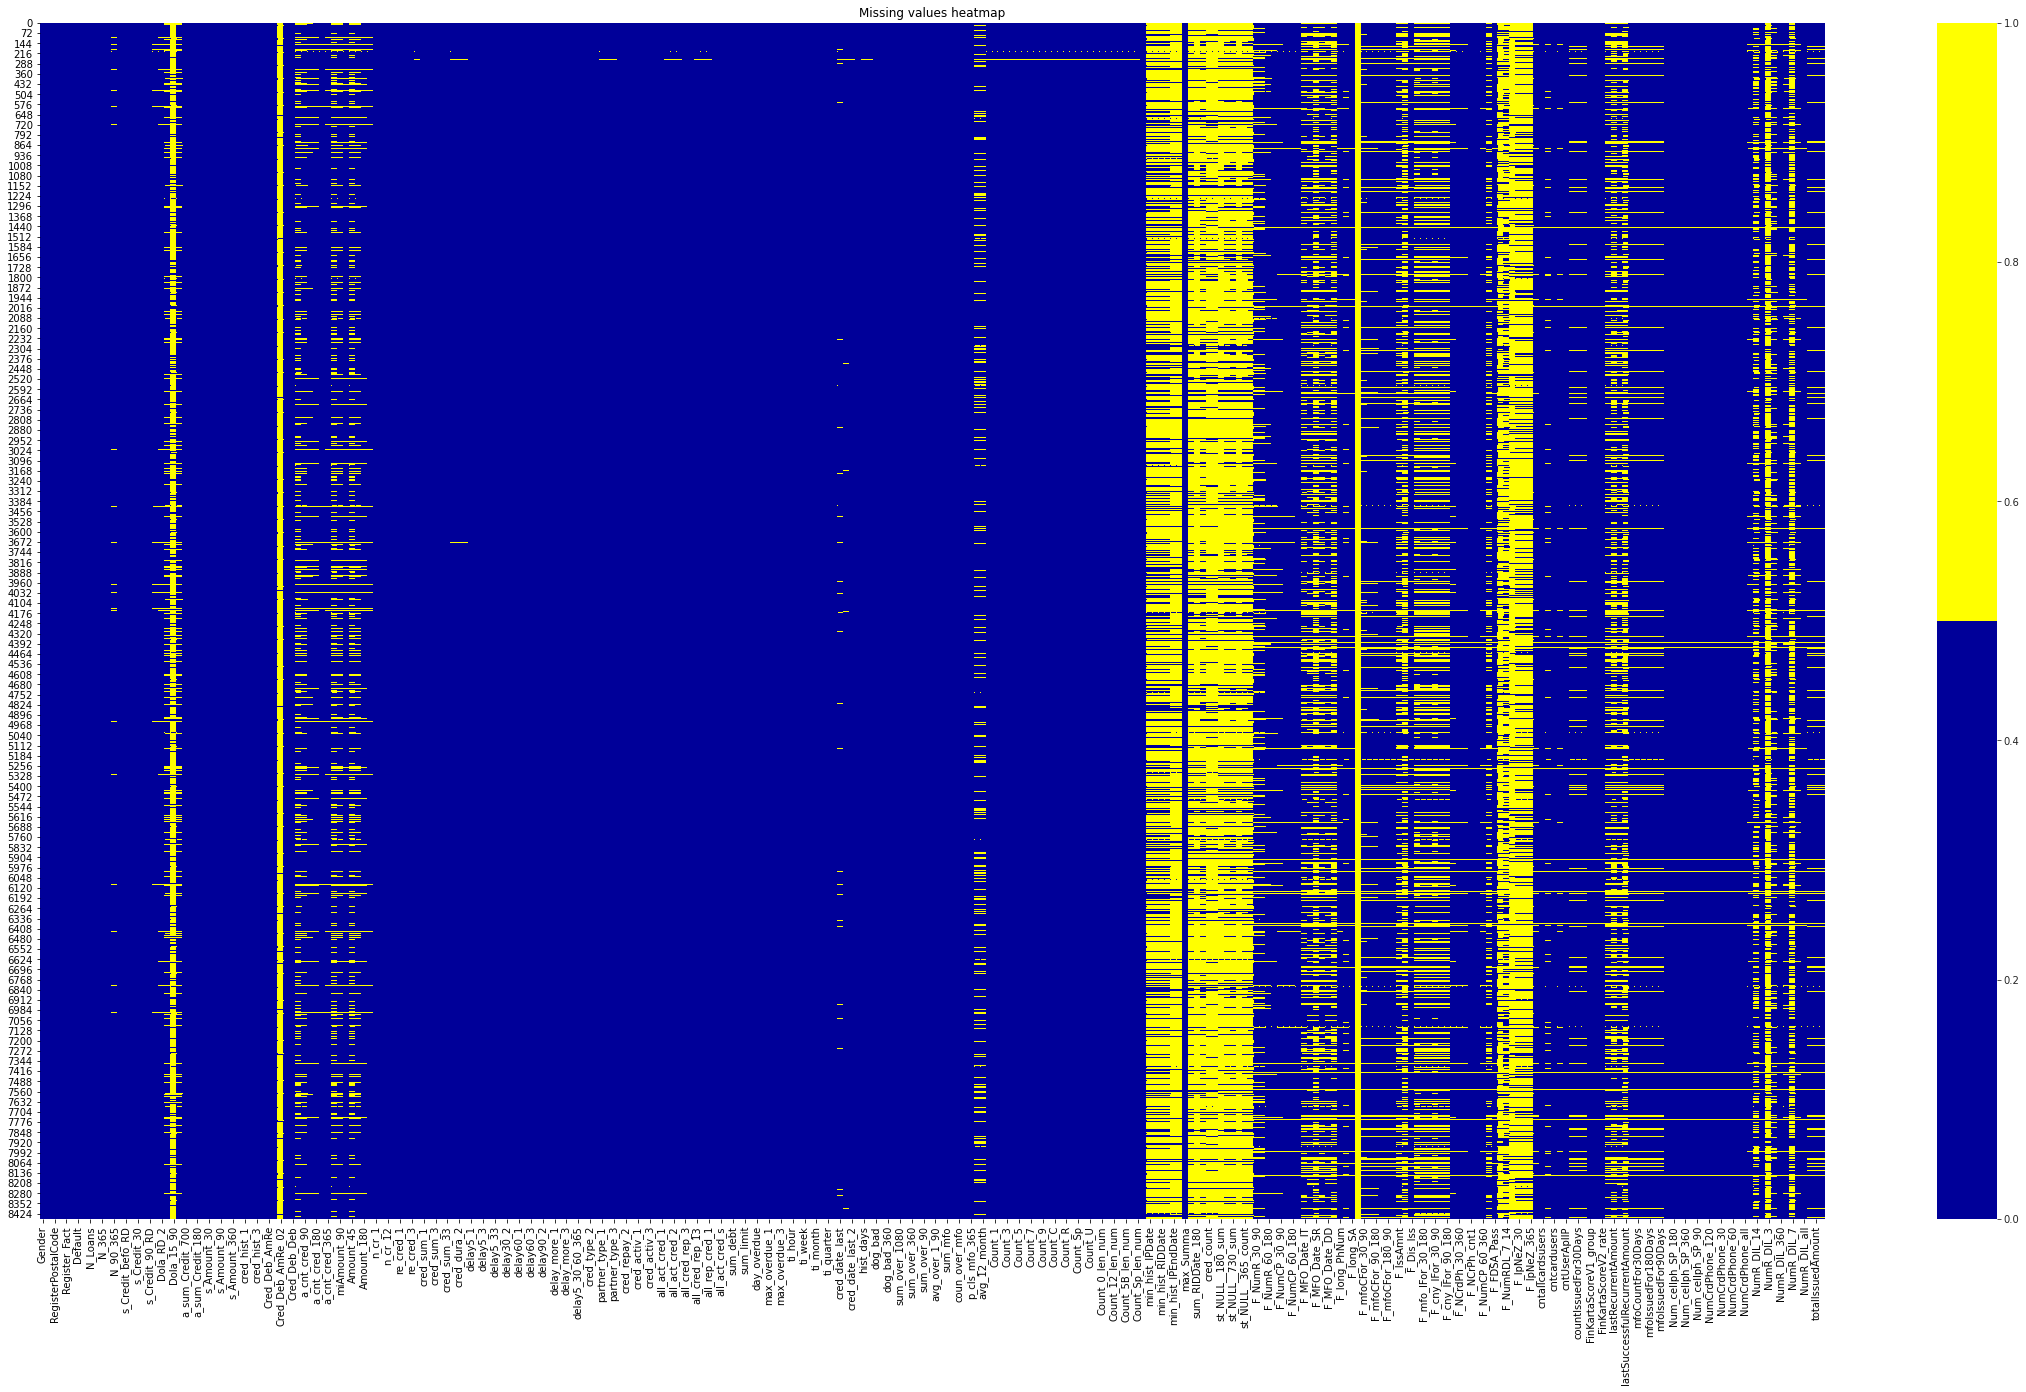

In [ ]:
df.isnull().sum()
colours = ['#000099', '#ffff00'] 
f, ax = plt.subplots(figsize = (40,22))
sns.set_style("whitegrid")
sns.heatmap(df.isnull(), cmap=sns.color_palette(colours)).set_title("Missing values heatmap")


count    8461.000000
mean       31.945278
std         8.394863
min        18.000000
25%        26.000000
50%        31.000000
75%        36.000000
max       135.000000
Name: age, dtype: float64

Данный признак содержит 0 пропусков


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


30     539
32     500
29     471
33     470
31     469
27     440
28     415
26     391
34     377
25     359
23     349
24     335
35     333
36     268
37     257
22     255
38     217
21     217
39     187
40     164
19     161
41     139
43     126
42     118
20     107
44      87
46      81
18      66
48      64
47      56
50      46
45      45
58      42
49      40
56      35
52      35
55      34
51      27
54      27
53      24
62      13
60      10
59      10
63       9
61       9
69       8
57       8
67       6
64       5
68       5
66       2
65       1
97       1
135      1
Name: age, dtype: int64

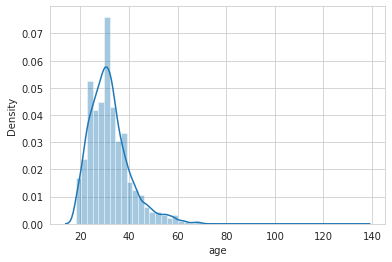

In [ ]:
#Возраст
num_stats(df['age'])
df.age.value_counts()

В признаке возраст есть явный выброс 135 лет. скорее всего - это техническая ошибка и клиенту 35 лет.

In [ ]:
df.loc[df['age'] == 135, 'age'] = 35

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


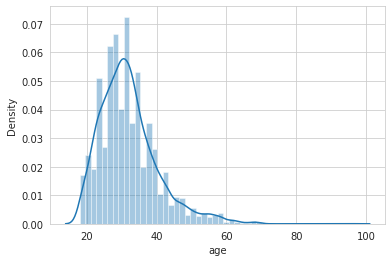

In [ ]:
sns_plot = sns.distplot(df['age'])
fig = sns_plot.get_figure()

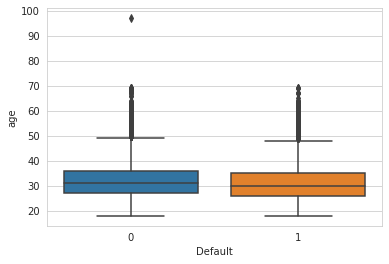

In [ ]:
sns.boxplot(y = 'age', x = 'Default', data=df)

count    8461.00000
mean        2.87271
std         3.89905
min         1.00000
25%         1.00000
50%         2.00000
75%         3.00000
max        60.00000
Name: N_Loans, dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Данный признак содержит 0 пропусков


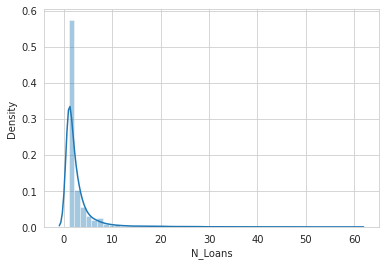

In [ ]:
#займ
num_stats(df.N_Loans)    

count    8461.000000
mean        0.192973
std         0.216252
min        -1.000000
25%         0.066666
50%         0.160000
75%         0.280000
max         3.160000
Name: perc_amount, dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Данный признак содержит 0 пропусков


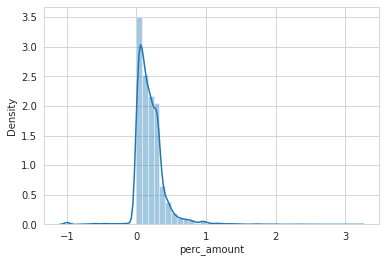

In [ ]:
#сумма процентов
num_stats(df.perc_amount)

В сумме процентов есть отрицательные значения. За кредит, по логике вещей, сумма процентов не должна быть отрицательной. Судя по гистограмме, таких значений совсем немного, заменим их на нули

In [ ]:
df.loc[df['perc_amount'] < 0, 'perc_amount'] = 0

count    8461.000000
mean        0.198955
std         0.200098
min         0.000000
25%         0.066666
50%         0.160000
75%         0.280000
max         3.160000
Name: perc_amount, dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Данный признак содержит 0 пропусков


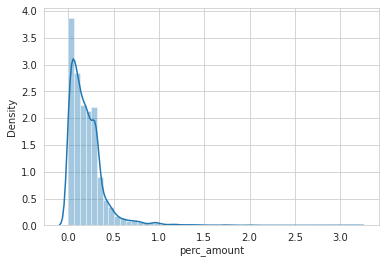

In [ ]:
num_stats(df.perc_amount)

count    8461.000000
mean        2.277390
std         2.046445
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        21.000000
Name: N_365, dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Данный признак содержит 0 пропусков


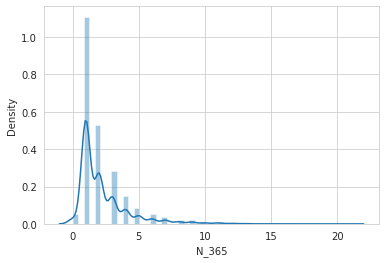

In [ ]:
#количество займов за 365 дней
num_stats(df.N_365)

count    8461.000000
mean       42.631722
std       197.357172
min       -56.000000
25%         1.000000
50%         5.000000
75%        21.000000
max      3105.000000
Name: last_payment, dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Данный признак содержит 0 пропусков


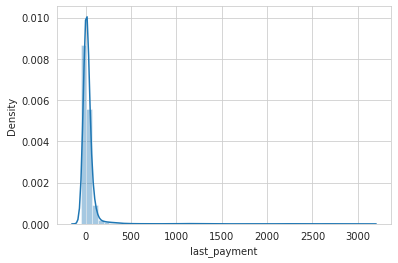

In [ ]:
#последний платеж
num_stats(df.last_payment)

У признака есть отрицательные значения, хотя по логике вещей их быть не должно. Посомтрим сколько их:

In [ ]:
df[df.last_payment < 0]

Gender  FactPostalCode  RegisterPostalCode  RegisterPhone  \
158        2        0.326531            0.333333              0   
814        2        0.200000            0.183673              1   
851        2        0.326531            0.333333              0   
1560       1        0.403846            0.333333              0   
3047       2        0.280000            0.224138              0   
5079       2        0.280000            0.224138              0   
5125       2        0.200000            0.183673              1   
5219       2        0.200000            0.183673              1   
7175       1        0.403846            0.333333              0   
7511       2        0.301075            0.297619              1   
7569       1        0.369048            0.428571              0   

      Register_Fact  EarlierCredits  Default  age  N_Loans  perc_amount  \
158               1               0        1   35        4     0.022236   
814               1               1        0   46       10     0.654409   
851               1               0        0   35        3     0.000000   
1560              1               1        0   27        7     0.185930   
3047              1               1        0   29        5     0.181428   
5079              1               1        0   29        6     0.142000   
5125              1               1        0   46        8     0.798471   
5219              1               1        0   46        7     0.863595   
7175              1               1        0   27        6     0.252096   
7511              1               3        0   26        7     0.013488   
7569              0               1        1   26        7     0.797195   

      N_365  last_payment  N_90_365  s_Amount  s_Credit_befo_RD  s_Credit_15  \
158       4           -17      0.75     11000          10644.60          0.0   
814       6           -10      1.00     81000         134007.15          0.0   
851       3           -48      1.00      7000           6207.80          0.0   
1560      7           -47      1.00     43000          33495.00          0.0   
3047      5           -29      1.00     21000          14135.00      10675.0   
5079      6           -24      1.00     30000          23585.00      10675.0   
5125      4           -26      1.00     64000         115102.15          0.0   
5219      3           -28      1.00     59000         109952.15          0.0   
7175      6           -48      1.00     31000          21315.00          0.0   
7511      7            -1      1.00     43000          43580.00          0.0   
7569      7           -56      1.00     41000           7810.00          0.0   

      s_Credit_30  s_Credit_90  s_Credit_90_RD  Dola_RD_1  Dola_RD_2  \
158         350.0        600.0        11244.60   0.731426   0.731426   
814           0.0          0.0       134007.15   1.000000   1.000000   
851         350.0        600.0         6807.80   0.911865   0.911865   
1560      17500.0      17500.0        50995.00   0.656829   0.656829   
3047      10675.0      10675.0        24810.00   0.569729   0.569729   
5079      10675.0      10675.0        34260.00   0.688412   0.688412   
5125          0.0          0.0       115102.15   1.000000   1.000000   
5219          0.0          0.0       109952.15   1.000000   1.000000   
7175      17500.0      17500.0        38815.00   0.549143   0.549143   
7511          0.0          0.0        43580.00   1.000000   1.000000   
7569          0.0      65875.0        73685.00   0.105991   0.105991   

      Dola_RD_3  Dola_15_90  Dola_60_90  a_sum_Credit_700  a_sum_Credit_365  \
158    0.932008         0.0    0.067991       2811.150000       2811.150000   
814    1.000000         NaN    0.000000       3479.500000       3479.500000   
851    0.911865         0.0    0.088134       2269.266666       2269.266666   
1560   0.656829         0.0    0.343170       7285.000000       7285.000000   
3047   0.569729         1.0    0.430270       4962.000000       4962.000000   


In [ ]:
#заменим отрицательные значения на 0
df.loc[df['last_payment'] < 0, 'last_payment'] = 0

count    8461.000000
mean       42.671197
std       197.344680
min         0.000000
25%         1.000000
50%         5.000000
75%        21.000000
max      3105.000000
Name: last_payment, dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Данный признак содержит 0 пропусков


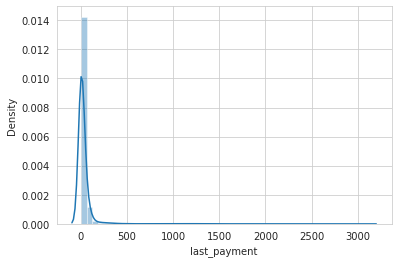

In [ ]:
num_stats(df.last_payment)

count    8280.000000
mean        0.786090
std         0.355807
min         0.000000
25%         0.571400
50%         1.000000
75%         1.000000
max         1.000000
Name: N_90_365, dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Данный признак содержит 181 пропусков


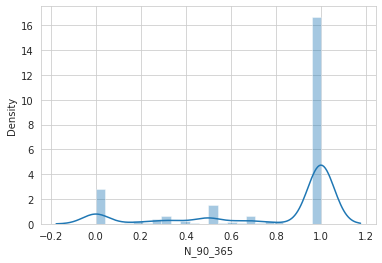

In [ ]:
num_stats(df.N_90_365)

count      8461.000000
mean      14076.397589
std       35270.508523
min        2000.000000
25%        2000.000000
50%        5000.000000
75%        9000.000000
max      848000.000000
Name: s_Amount, dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Данный признак содержит 0 пропусков


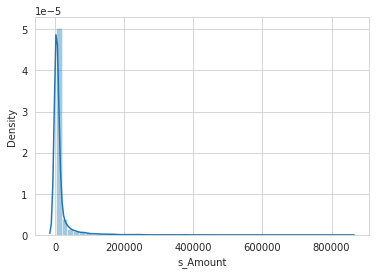

In [ ]:
num_stats(df.s_Amount)

count      8461.000000
mean      14351.952248
std       40745.993061
min           0.000000
25%        2140.000000
50%        4380.000000
75%        9920.000000
max      984425.620000
Name: s_Credit_befo_RD, dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Данный признак содержит 0 пропусков


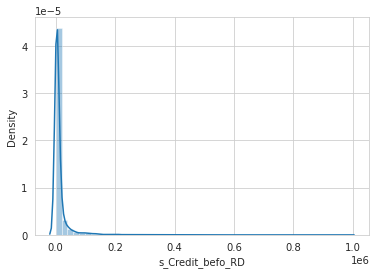

In [ ]:
num_stats(df.s_Credit_befo_RD)

s_Credit_15


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


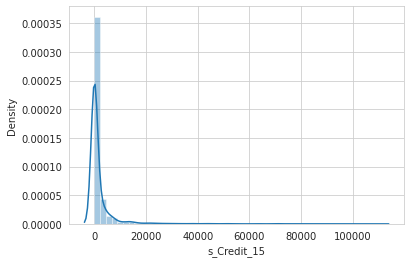

s_Credit_30


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


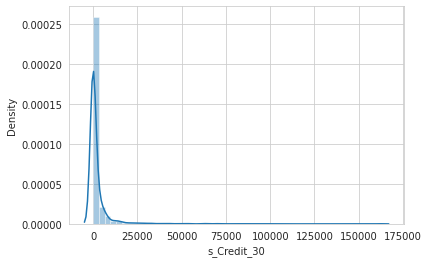

s_Credit_90


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


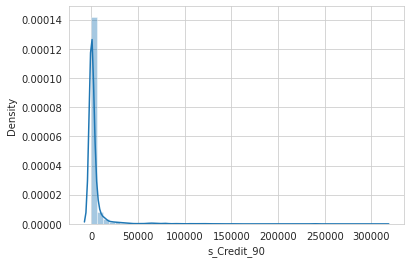

s_Credit_15    s_Credit_30    s_Credit_90
count    8461.000000    8461.000000    8461.000000
mean     2074.778291    2610.917238    3736.874351
std      7898.748040    9944.590423   15092.278399
min         0.000000       0.000000       0.000000
25%         0.000000       0.000000       0.000000
50%         0.000000       0.000000       0.000000
75%         0.000000       0.000000    2480.000000
max    110126.000000  162067.680000  311215.770000

In [ ]:
for col in df[['s_Credit_15', 's_Credit_30', 's_Credit_90']]:
    print(col)
    sns.distplot(df[col])
    plt.show()    

df[['s_Credit_15', 's_Credit_30', 's_Credit_90']].describe()

count    8.461000e+03
mean     1.808883e+04
std      4.917838e+04
min      0.000000e+00
25%      2.320000e+03
50%      5.440000e+03
75%      1.153000e+04
max      1.076526e+06
Name: s_Credit_90_RD, dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Данный признак содержит 0 пропусков


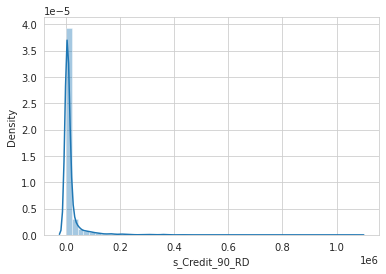

In [ ]:
num_stats(df.s_Credit_90_RD)

Dola_RD_1


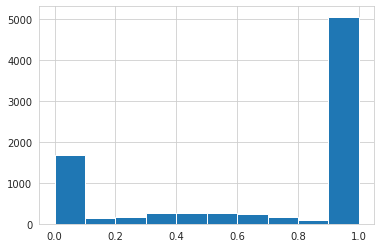

Dola_RD_2


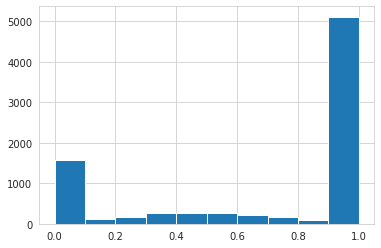

Dola_RD_3


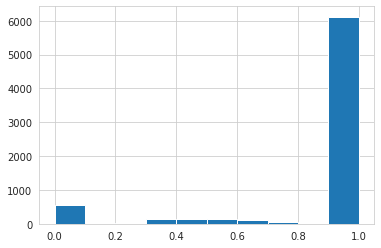

Dola_15_90


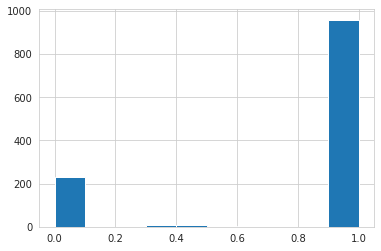

Dola_60_90


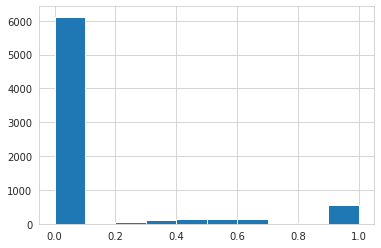

Dola_RD_1    Dola_RD_2    Dola_RD_3   Dola_15_90   Dola_60_90
count  8326.000000  8267.000000  7322.000000  1211.000000  7322.000000
mean      0.699752     0.712410     0.878788     0.798970     0.121075
std       0.410968     0.404412     0.294487     0.395401     0.294311
min       0.000000     0.000000     0.000000     0.000000     0.000000
25%       0.336749     0.376800     1.000000     1.000000     0.000000
50%       1.000000     1.000000     1.000000     1.000000     0.000000
75%       1.000000     1.000000     1.000000     1.000000     0.000000
max       1.000000     1.000000     1.000000     1.000000     1.000000

In [ ]:
for col in df[['Dola_RD_1', 'Dola_RD_2', 'Dola_RD_3', 'Dola_15_90', 'Dola_60_90']]:
    print(col)
    plt.hist(df[col])
    plt.show()    
    
df[['Dola_RD_1', 'Dola_RD_2', 'Dola_RD_3', 'Dola_15_90', 'Dola_60_90']].describe()

a_sum_Credit_700


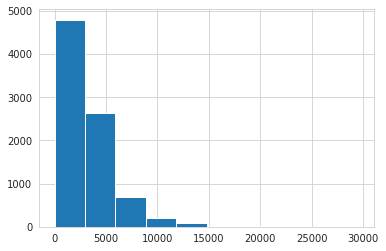

a_sum_Credit_365


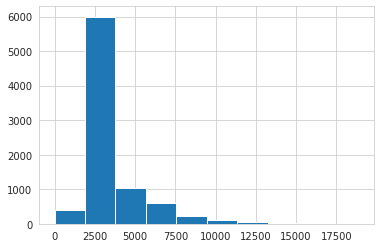

a_sum_Credit_180


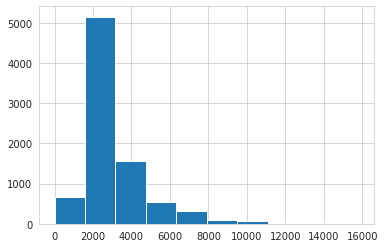

a_sum_Credit_90


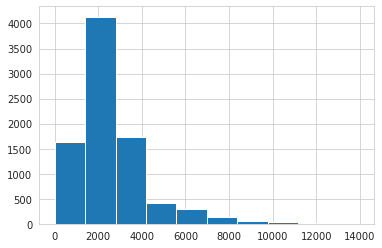

a_sum_Credit_700  a_sum_Credit_365  a_sum_Credit_180  a_sum_Credit_90
count       8461.000000       8461.000000       8461.000000      8461.000000
mean        3556.469187       3365.393507       3074.238726      2525.982348
std         2375.207686       2041.361304       1803.105010      1789.461696
min            0.000000          0.000000          0.000000         0.000000
25%         2200.000000       2180.000000       2140.000000      2000.000000
50%         2720.000000       2675.000000       2620.000000      2300.000000
75%         3860.666666       3736.333333       3495.000000      3055.000000
max        29577.428571      18900.000000      15828.075000     13966.666666

In [ ]:
for col in df[['a_sum_Credit_700', 'a_sum_Credit_365', 'a_sum_Credit_180', 'a_sum_Credit_90']]:
    print(col)
    plt.hist(df[col])
    plt.show()   

df[['a_sum_Credit_700', 'a_sum_Credit_365', 'a_sum_Credit_180', 'a_sum_Credit_90']].describe()

s_Amount_30


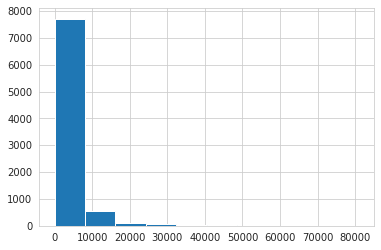

s_Amount_60


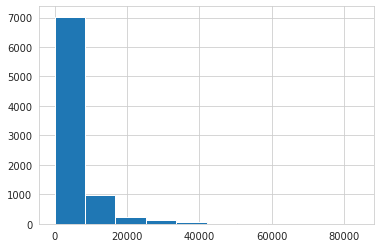

s_Amount_90


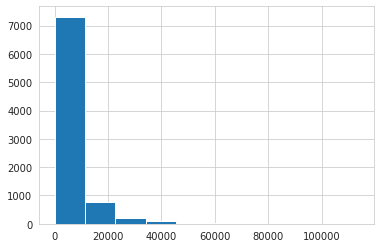

s_Amount_180


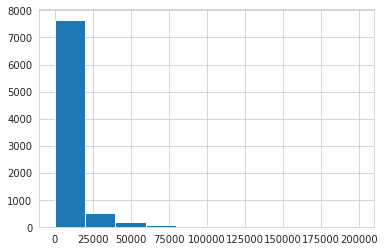

s_Amount_360


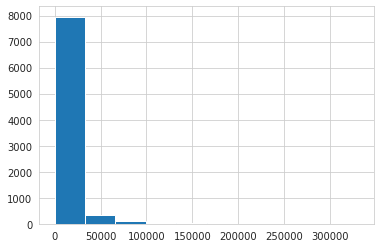

s_Amount_500


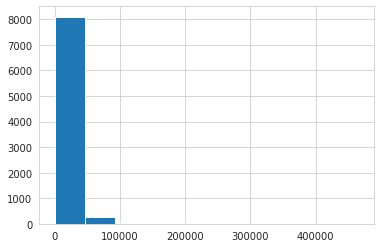

s_Amount_30   s_Amount_60    s_Amount_90   s_Amount_180  \
count   8461.000000   8461.000000    8461.000000    8461.000000   
mean    2881.101525   4971.155892    6095.266517    7858.054603   
std     5228.783914   7298.180601    8907.096527   12099.938034   
min        0.000000      0.000000       0.000000       0.000000   
25%        0.000000   2000.000000    2000.000000    2000.000000   
50%     2000.000000   2000.000000    3000.000000    4000.000000   
75%     4000.000000   5000.000000    7000.000000    9000.000000   
max    81000.000000  84000.000000  114000.000000  200000.000000   

        s_Amount_360   s_Amount_500  
count    8461.000000    8461.000000  
mean     9485.143600   10392.790450  
std     17004.912871   21433.093681  
min         0.000000       0.000000  
25%      2000.000000    2000.000000  
50%      5000.000000    5000.000000  
75%      9000.000000    9000.000000  
max    331000.000000  466000.000000

In [ ]:
for col in df[['s_Amount_30', 's_Amount_60', 's_Amount_90', 's_Amount_180', 's_Amount_360', 's_Amount_500']]:
    print(col)
    plt.hist(df[col])
    plt.show()   

df[['s_Amount_30', 's_Amount_60', 's_Amount_90', 's_Amount_180', 's_Amount_360', 's_Amount_500']].describe()

cred_hist_1


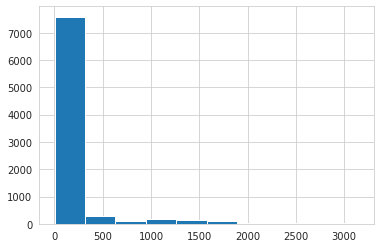

cred_hist_2


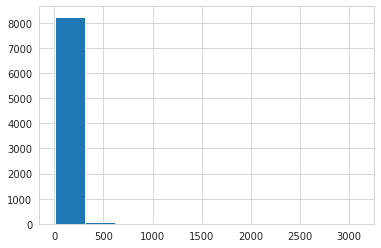

cred_hist_3


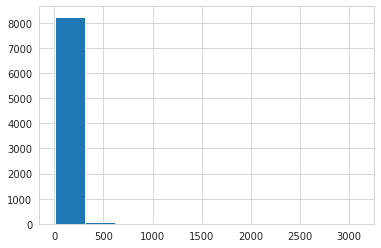

cred_hist_1  cred_hist_2  cred_hist_3
count  8461.000000  8461.000000  8461.000000
mean    172.221369    63.453729    63.453729
std     393.855672   210.547393   210.547393
min       1.000000     1.000000     1.000000
25%      21.000000    11.000000    11.000000
50%      52.000000    27.000000    27.000000
75%     108.000000    45.000000    45.000000
max    3154.000000  3105.000000  3105.000000

In [ ]:
for col in df[['cred_hist_1', 'cred_hist_2', 'cred_hist_3']]:
    print(col)
    plt.hist(df[col])
    plt.show()

df[['cred_hist_1', 'cred_hist_2', 'cred_hist_3']].describe()

Cred_Deb_2


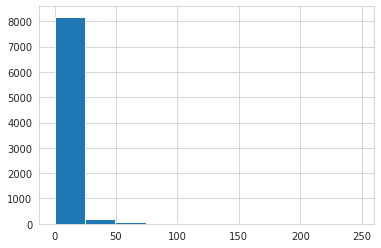

Cred_Deb_AmRe


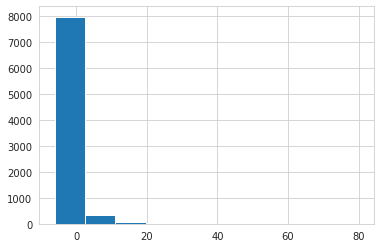

Cred_Deb_AmRe_01


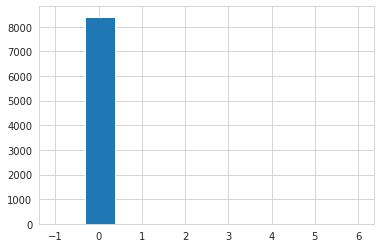

Cred_Deb_AmRe_02


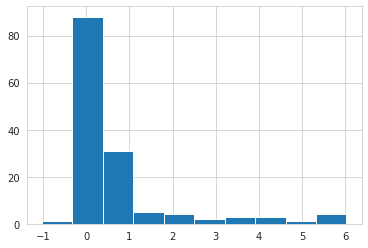

Cred_Deb_AmRe_1


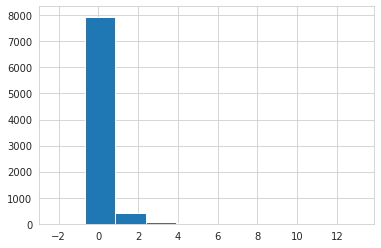

Cred_Deb_Deb


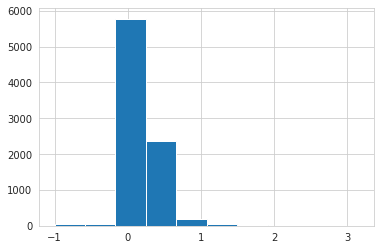

Cred_Deb_2  Cred_Deb_AmRe  Cred_Deb_AmRe_01  Cred_Deb_AmRe_02  \
count  8461.000000    8461.000000       8461.000000        142.000000   
mean      4.037578       0.942954          0.012530          0.746597   
std      12.174187       3.933083          0.192692          1.294554   
min       0.000000      -6.090000         -1.022100         -1.022100   
25%       0.813300       0.064000          0.000000          0.077250   
50%       1.370000       0.193300          0.000000          0.269600   
75%       2.416700       0.426700          0.000000          0.716025   
max     247.707500      80.094000          6.021700          6.021700   

       Cred_Deb_AmRe_1  Cred_Deb_Deb  
count      8461.000000   8461.000000  
mean          0.303154      0.192973  
std           0.612653      0.216251  
min          -2.200000     -1.000000  
25%           0.050000      0.066666  
50%           0.162900      0.160000  
75%           0.338000      0.280000  
max          13.107200      3.160000

In [ ]:
#Cred_Deb_AmRe_02,     (все выплаты клиента - сумма займов)/ Сумма заявки
#Cred_Deb_AmRe_1,   (все выплаты клиента - сумма займов)/ Сумма заявки
#Cred_Deb_Deb,      (все выплаты клиента - сумма займов)/ Сумма заявки     
#«минус»  -   те за какой-то период человек выплатил меньше, чем получил займов
for col in df[['Cred_Deb_2', 'Cred_Deb_AmRe', 'Cred_Deb_AmRe_01', 'Cred_Deb_AmRe_02', 'Cred_Deb_AmRe_1', 'Cred_Deb_Deb']]:
    print(col)
    plt.hist(df[col])
    plt.show()

df[['Cred_Deb_2', 'Cred_Deb_AmRe', 'Cred_Deb_AmRe_01', 'Cred_Deb_AmRe_02', 'Cred_Deb_AmRe_1', 'Cred_Deb_Deb']].describe()

Признак Cred_Deb_AmRe_02 содержит более 90 % пропусков. Считаю, что его можно удалить.

In [ ]:
df.drop(['Cred_Deb_AmRe_02'], axis=1, inplace=True)

a_cnt_cred_45


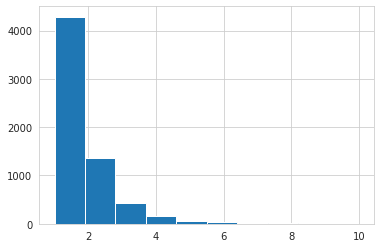

a_cnt_cred_90


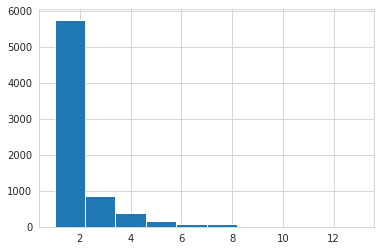

a_cnt_cred_135


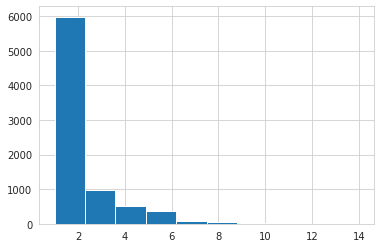

a_cnt_cred_180


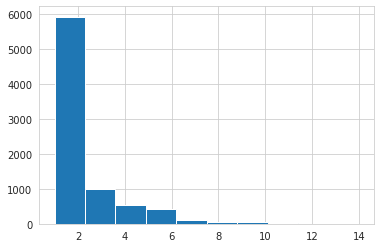

a_cnt_cred_700


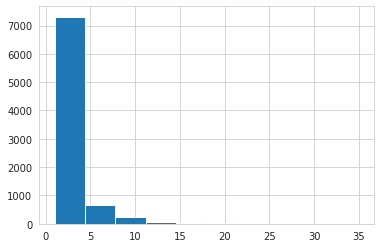

a_cnt_cred_365


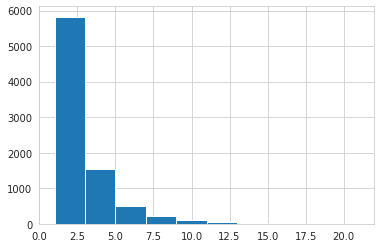

a_cnt_cred_45  a_cnt_cred_90  a_cnt_cred_135  a_cnt_cred_180  \
count    6363.000000    7322.000000     8018.000000     8125.000000   
mean        1.522238       1.881726        2.023821        2.121969   
std         0.968995       1.303834        1.497095        1.636913   
min         1.000000       1.000000        1.000000        1.000000   
25%         1.000000       1.000000        1.000000        1.000000   
50%         1.000000       1.000000        1.000000        2.000000   
75%         2.000000       2.000000        3.000000        3.000000   
max        10.000000      13.000000       14.000000       14.000000   

       a_cnt_cred_700  a_cnt_cred_365  
count     8339.000000     8280.000000  
mean         2.511092        2.327174  
std          2.629968        2.040497  
min          1.000000        1.000000  
25%          1.000000        1.000000  
50%          2.000000        2.000000  
75%          3.000000        3.000000  
max         35.000000       21.000000

In [ ]:
for col in df[['a_cnt_cred_45', 'a_cnt_cred_90', 'a_cnt_cred_135', 'a_cnt_cred_180', 'a_cnt_cred_700', 'a_cnt_cred_365']]:
    print(col)
    plt.hist(df[col])
    plt.show()
df[['a_cnt_cred_45', 'a_cnt_cred_90', 'a_cnt_cred_135', 'a_cnt_cred_180', 'a_cnt_cred_700', 'a_cnt_cred_365']].describe()

miAmount_45


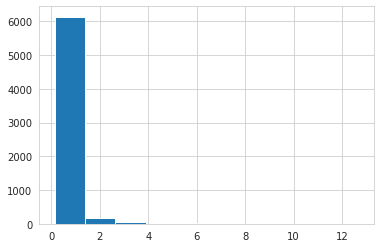

miAmount_90


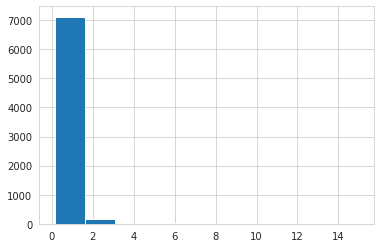

miAmount_180


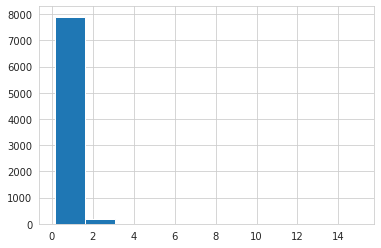

miAmount_45  miAmount_90  miAmount_180
count  6363.000000  7322.000000   8125.000000
mean      0.711537     0.683501      0.667292
std       0.453790     0.503444      0.515265
min       0.133300     0.133300      0.133300
25%       0.500000     0.500000      0.400000
50%       0.666700     0.666700      0.666700
75%       0.800000     0.750000      0.666700
max      12.700000    15.000000     15.000000

In [ ]:
for col in df[['miAmount_45', 'miAmount_90', 'miAmount_180']]:
    print(col)
    plt.hist(df[col])
    plt.show()
df[['miAmount_45', 'miAmount_90', 'miAmount_180']].describe()

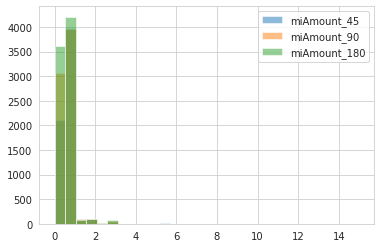

In [ ]:
bins = np.linspace(0, 15, 30)

plt.hist(df['miAmount_45'], bins, alpha=0.5, label='miAmount_45')
plt.hist(df['miAmount_90'], bins, alpha=0.5, label='miAmount_90')
plt.hist(df['miAmount_180'], bins, alpha=0.5, label='miAmount_180')
plt.legend(loc='upper right')
plt.show()

Amount_45


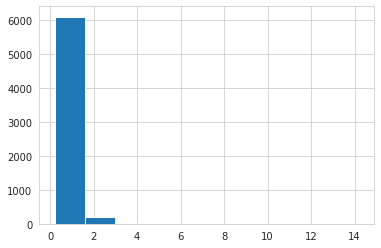

Amount_90


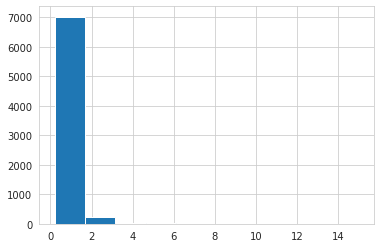

Amount_180


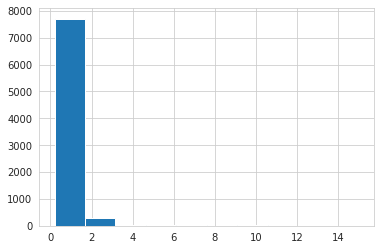

Amount_365


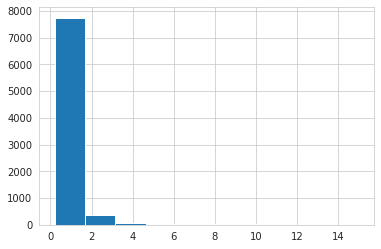

Amount_45    Amount_90   Amount_180   Amount_365
count  6363.00000  7322.000000  8125.000000  8280.000000
mean      0.82869     0.874904     0.917096     0.974338
std       0.51854     0.633842     0.775207     0.952746
min       0.20000     0.200000     0.200000     0.200000
25%       0.66670     0.666700     0.666700     0.666700
50%       0.75000     0.750000     0.750000     0.750000
75%       1.00000     1.000000     1.000000     1.000000
max      14.20000    15.000000    15.000000    15.000000

In [ ]:
for col in df[['Amount_45', 'Amount_90', 'Amount_180', 'Amount_365']]:
    print(col)
    plt.hist(df[col])
    plt.show()
df[['Amount_45', 'Amount_90', 'Amount_180', 'Amount_365']].describe()

n_cr_1


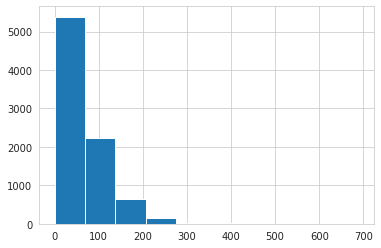

n_cr_2


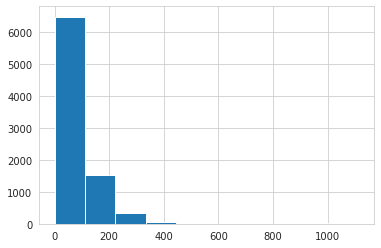

n_cr_12


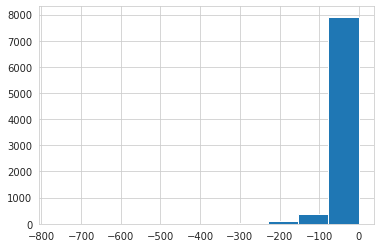

n_cr_3


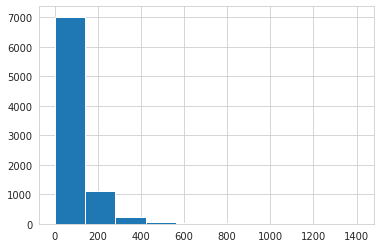

n_cr_1       n_cr_2      n_cr_12       n_cr_3
count  8461.000000  8461.000000  8461.000000  8461.000000
mean     64.326912    81.954615   -17.627704    88.839381
std      58.401980    87.070626    43.771215    98.754132
min       0.000000     0.000000  -767.000000     0.000000
25%      22.000000    28.000000   -13.000000    31.000000
50%      50.000000    60.000000    -3.000000    63.000000
75%      89.000000   107.000000     0.000000   113.000000
max     690.000000  1115.000000     0.000000  1411.000000

In [ ]:
#n_cr_12 - количество взятых кредитов за последний год – количество кредитов за последние 2 года
for col in df[['n_cr_1', 'n_cr_2', 'n_cr_12', 'n_cr_3']]:
    print(col)
    plt.hist(df[col])
    plt.show()
df[['n_cr_1', 'n_cr_2', 'n_cr_12', 'n_cr_3']].describe()

re_cred_1


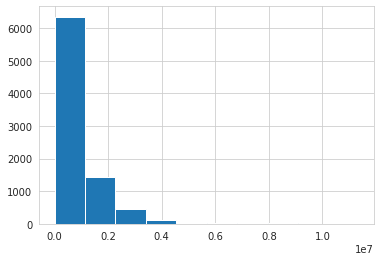

re_cred_2


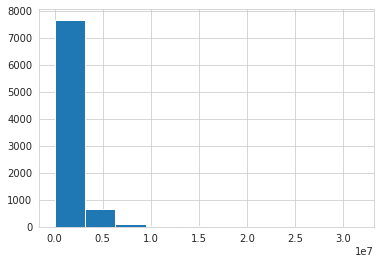

re_cred_3


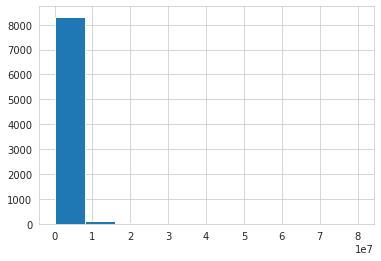

re_cred_1     re_cred_2     re_cred_3
count  8.461000e+03  8.461000e+03  8.461000e+03
mean   8.365887e+05  1.271790e+06  1.539295e+06
std    1.026138e+06  1.760284e+06  2.304892e+06
min    0.000000e+00  0.000000e+00  0.000000e+00
25%    1.568419e+05  2.544699e+05  3.091132e+05
50%    5.095164e+05  7.348535e+05  8.743168e+05
75%    1.130927e+06  1.601361e+06  1.918520e+06
max    1.136266e+07  3.166872e+07  8.034016e+07

In [ ]:
for col in df[['re_cred_1', 're_cred_2', 're_cred_3']]:
    print(col)
    plt.hist(df[col])
    plt.show()

df[['re_cred_1', 're_cred_2', 're_cred_3']].describe()

count    8426.000000
mean       -0.039413
std         0.364144
min        -1.000000
25%        -0.235775
50%        -0.026250
75%         0.147775
max         5.173300
Name: persent_loan, dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Данный признак содержит 35 пропусков


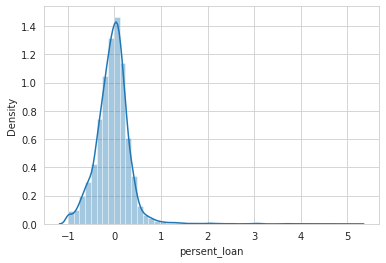

In [ ]:
num_stats(df.persent_loan)

cred_sum_1


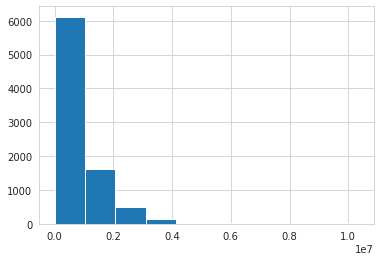

cred_sum_2


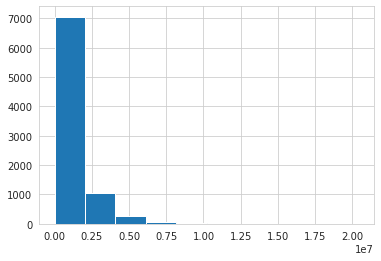

cred_sum_3


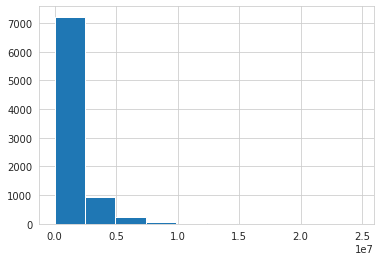

cred_sum_22


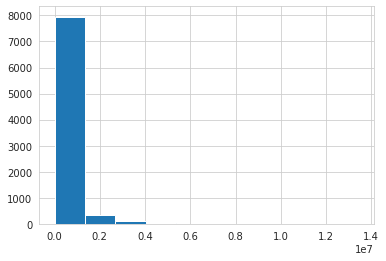

cred_sum_33


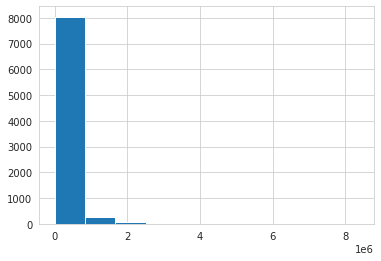

cred_sum_1    cred_sum_2    cred_sum_3   cred_sum_22   cred_sum_33
count  8.461000e+03  8.461000e+03  8.461000e+03  8.461000e+03  8.461000e+03
mean   8.232022e+05  1.163031e+06  1.339256e+06  3.398287e+05  1.762254e+05
std    9.470552e+05  1.454458e+06  1.706118e+06  7.335681e+05  4.603363e+05
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
25%    1.910500e+05  2.818630e+05  3.331603e+05  0.000000e+00  0.000000e+00
50%    5.486709e+05  7.371900e+05  8.295175e+05  8.400000e+04  1.664000e+04
75%    1.125996e+06  1.531549e+06  1.705202e+06  3.527462e+05  1.473990e+05
max    1.036175e+07  2.043560e+07  2.474250e+07  1.345338e+07  8.378000e+06

In [ ]:
for col in df[['cred_sum_1', 'cred_sum_2', 'cred_sum_3', 'cred_sum_22', 'cred_sum_33']]:
    print(col)
    plt.hist(df[col])
    plt.show()

df[['cred_sum_1', 'cred_sum_2', 'cred_sum_3', 'cred_sum_22', 'cred_sum_33']].describe()

cred_dura_1


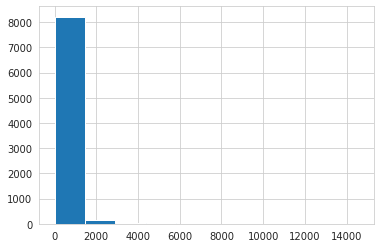

cred_dura_2


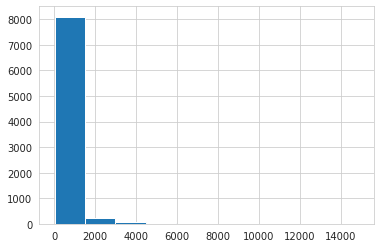

cred_dura_3


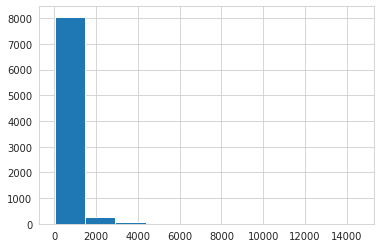

cred_dura_1   cred_dura_2   cred_dura_3
count   8424.000000   8438.000000   8443.000000
mean     225.219373    319.311567    353.797465
std      652.063696    718.860121    721.170669
min        0.000000      7.000000      7.000000
25%       38.000000     45.000000     49.000000
50%       64.000000     94.000000    113.000000
75%      135.000000    291.000000    365.000000
max    14585.000000  14888.000000  14585.000000

In [ ]:
#срок кредита
for col in df[['cred_dura_1', 'cred_dura_2', 'cred_dura_3']]:
    print(col)
    plt.hist(df[col])
    plt.show()
df[['cred_dura_1', 'cred_dura_2', 'cred_dura_3']].describe()

delay5_1


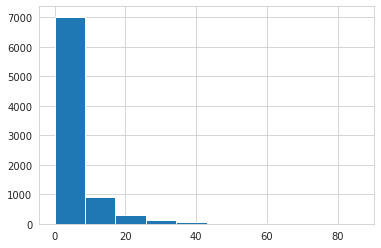

delay5_2


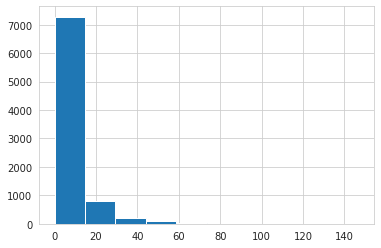

delay5_3


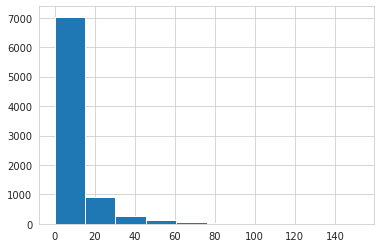

delay5_22


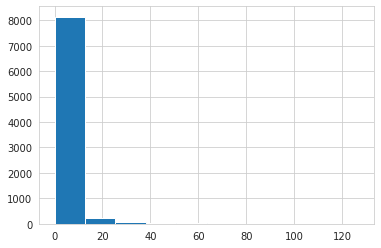

delay5_33


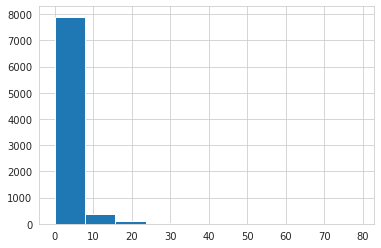

delay5_1     delay5_2     delay5_3    delay5_22    delay5_33
count  8461.000000  8461.000000  8461.000000  8461.000000  8461.000000
mean      4.407280     6.603238     8.201040     2.195958     1.597802
std       7.667611    10.966288    13.002559     5.514682     4.299518
min       0.000000     0.000000     0.000000     0.000000     0.000000
25%       0.000000     0.000000     0.000000     0.000000     0.000000
50%       1.000000     2.000000     3.000000     0.000000     0.000000
75%       5.000000     8.000000    10.000000     2.000000     1.000000
max      86.000000   147.000000   152.000000   127.000000    79.000000

In [ ]:
for col in df[['delay5_1', 'delay5_2', 'delay5_3', 'delay5_22', 'delay5_33']]:
    print(col)
    plt.hist(df[col])
    plt.show()
df[['delay5_1', 'delay5_2', 'delay5_3', 'delay5_22', 'delay5_33']].describe()

delay30_1


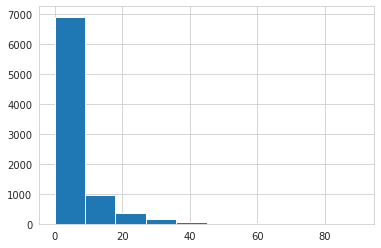

delay30_2


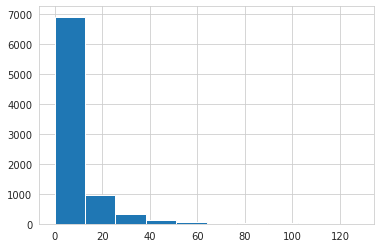

delay30_3


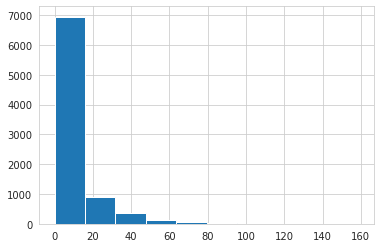

delay30_1    delay30_2    delay30_3
count  8461.000000  8461.000000  8461.000000
mean      4.451011     6.838081     8.570973
std       8.264774    12.126930    14.931058
min       0.000000     0.000000     0.000000
25%       0.000000     0.000000     0.000000
50%       1.000000     2.000000     2.000000
75%       5.000000     8.000000    11.000000
max      90.000000   128.000000   159.000000

In [ ]:
for col in df[['delay30_1', 'delay30_2', 'delay30_3']]:
    print(col)
    plt.hist(df[col])
    plt.show()

df[['delay30_1', 'delay30_2', 'delay30_3']].describe()

delay60_1


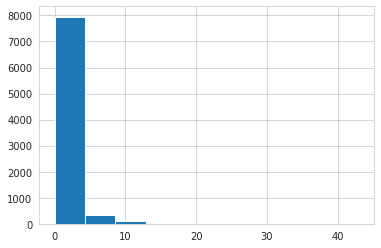

delay60_2


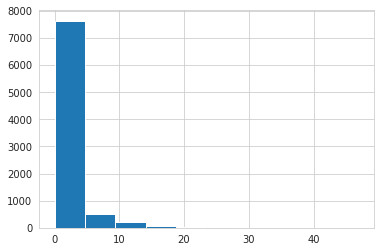

delay60_3


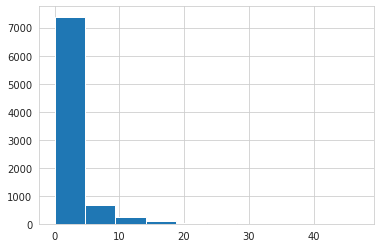

delay60_1    delay60_2    delay60_3
count  8461.000000  8461.000000  8461.000000
mean      0.858764     1.395934     1.727810
std       2.233059     3.235983     3.757737
min       0.000000     0.000000     0.000000
25%       0.000000     0.000000     0.000000
50%       0.000000     0.000000     0.000000
75%       1.000000     1.000000     2.000000
max      43.000000    47.000000    47.000000

In [ ]:
for col in df[['delay60_1', 'delay60_2', 'delay60_3']]:
    print(col)
    plt.hist(df[col])
    plt.show()

df[['delay60_1', 'delay60_2', 'delay60_3']].describe()

delay90_1


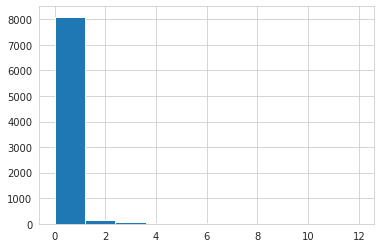

delay90_2


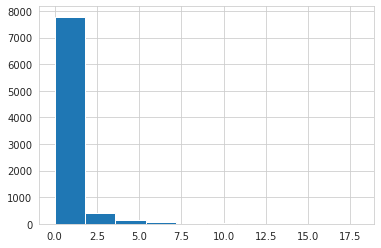

delay90_3


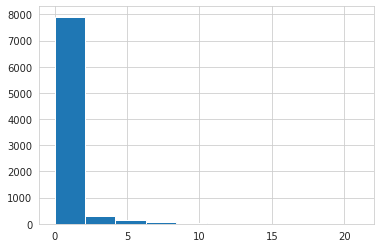

delay90_1    delay90_2    delay90_3
count  8461.000000  8461.000000  8461.000000
mean      0.211441     0.397234     0.523106
std       0.821025     1.282631     1.526238
min       0.000000     0.000000     0.000000
25%       0.000000     0.000000     0.000000
50%       0.000000     0.000000     0.000000
75%       0.000000     0.000000     0.000000
max      12.000000    18.000000    21.000000

In [ ]:
for col in df[['delay90_1', 'delay90_2', 'delay90_3']]:
    print(col)
    plt.hist(df[col])
    plt.show()

df[['delay90_1', 'delay90_2', 'delay90_3']].describe()

delay_more_1


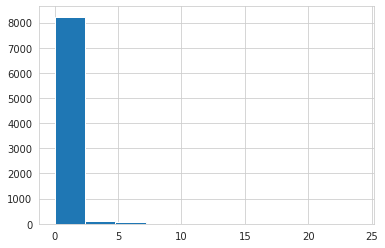

delay_more_2


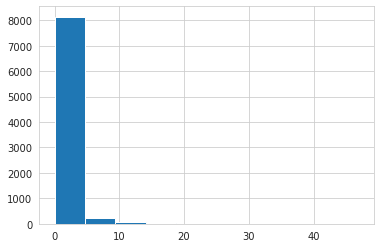

delay_more_3


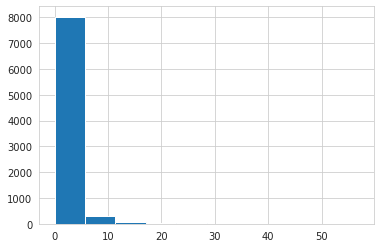

delay_more_1  delay_more_2  delay_more_3
count   8461.000000   8461.000000   8461.000000
mean       0.229878      0.598511      0.941024
std        1.102645      2.406088      3.191403
min        0.000000      0.000000      0.000000
25%        0.000000      0.000000      0.000000
50%        0.000000      0.000000      0.000000
75%        0.000000      0.000000      0.000000
max       24.000000     47.000000     57.000000

In [ ]:
for col in df[['delay_more_1', 'delay_more_2', 'delay_more_3']]:
    print(col)
    plt.hist(df[col])
    plt.show()

df[['delay_more_1', 'delay_more_2', 'delay_more_3']].describe()

delay5_30_365


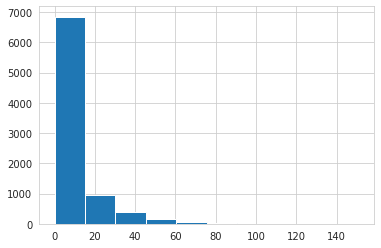

delay5_30_60_365


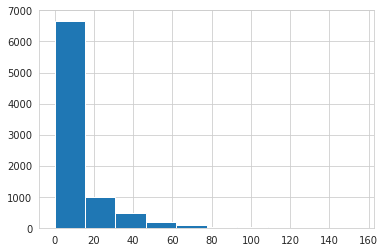

delay5_30_365  delay5_30_60_365
count    8461.000000       8461.000000
mean        8.858291          9.717055
std        14.848371         15.983970
min         0.000000          0.000000
25%         0.000000          0.000000
50%         2.000000          3.000000
75%        11.000000         13.000000
max       151.000000        155.000000

In [ ]:
for col in df[['delay5_30_365', 'delay5_30_60_365']]:
    print(col)
    plt.hist(df[col])
    plt.show()

df[['delay5_30_365', 'delay5_30_60_365']].describe()

cred_type_1


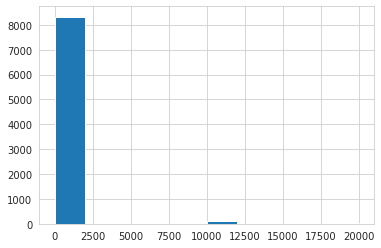

cred_type_2


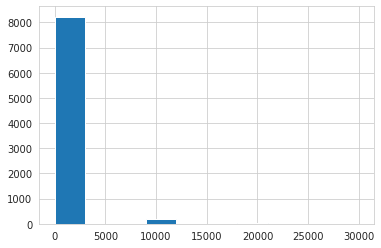

cred_type_3


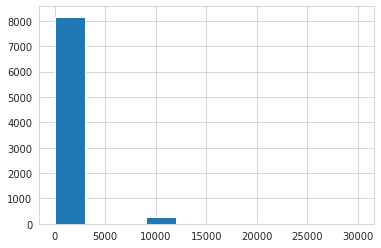

cred_type_1   cred_type_2   cred_type_3
count   8461.000000   8461.000000   8461.000000
mean     177.721900    317.055549    400.556317
std     1464.115637   1977.376912   2216.918660
min        0.000000      0.000000      0.000000
25%        0.000000      0.000000      0.000000
50%        0.000000      0.000000      0.000000
75%        0.000000      0.000000      0.000000
max    20000.000000  30000.000000  30100.000000

In [ ]:
for col in df[['cred_type_1', 'cred_type_2', 'cred_type_3']]:
    print(col)
    plt.hist(df[col])
    plt.show()

df[['cred_type_1', 'cred_type_2', 'cred_type_3']].describe()

partner_type_1


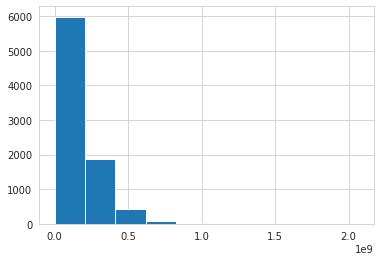

partner_type_2


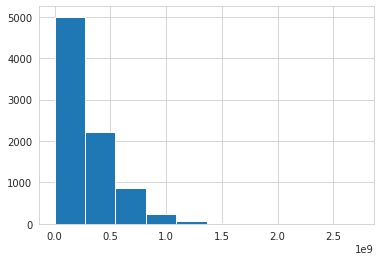

partner_type_3


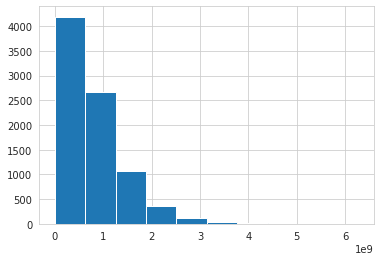

partner_type_1  partner_type_2  partner_type_3
count    8.426000e+03    8.439000e+03    8.449000e+03
mean     1.563343e+08    2.817678e+08    7.801621e+08
std      1.578197e+08    2.622653e+08    6.543070e+08
min      1.000000e+02    2.000000e+02    1.000000e+06
25%      3.700000e+07    7.900000e+07    3.070000e+08
50%      1.140000e+08    2.210000e+08    6.360000e+08
75%      2.290000e+08    4.120000e+08    1.096000e+09
max      2.070000e+09    2.728000e+09    6.283000e+09

In [ ]:
for col in df[['partner_type_1', 'partner_type_2', 'partner_type_3']]:
    print(col)
    plt.hist(df[col])
    plt.show()

df[['partner_type_1', 'partner_type_2', 'partner_type_3']].describe()

cred_repay_1


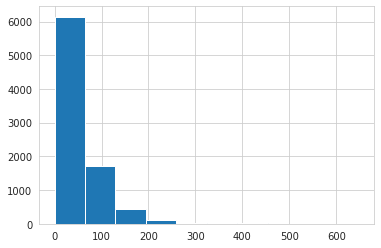

cred_repay_2


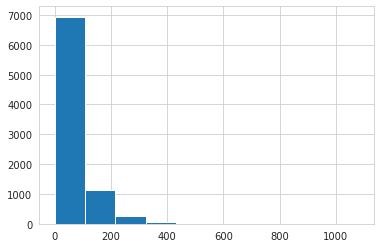

cred_repay_3


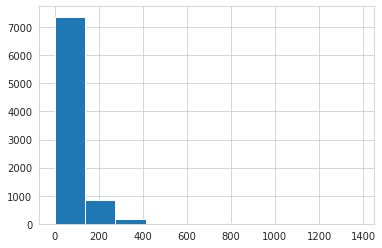

cred_repay_1  cred_repay_2  cred_repay_3
count   8461.000000   8461.000000   8461.000000
mean      50.049403     66.229406     72.453374
std       52.792234     82.307005     94.296130
min        0.000000      0.000000      0.000000
25%       14.000000     18.000000     20.000000
50%       34.000000     42.000000     45.000000
75%       69.000000     85.000000     91.000000
max      648.000000   1082.000000   1381.000000

In [ ]:
#погашение кредита
for col in df[['cred_repay_1', 'cred_repay_2', 'cred_repay_3']]:
    print(col)
    plt.hist(df[col])
    plt.show()

df[['cred_repay_1', 'cred_repay_2', 'cred_repay_3']].describe()

cred_activ_1


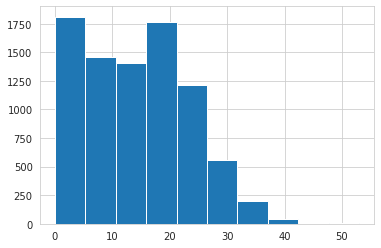

cred_activ_2


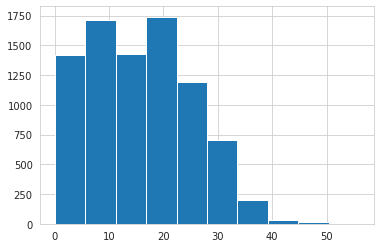

cred_activ_3


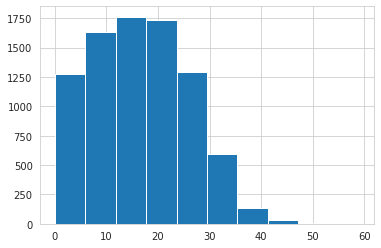

cred_activ_1  cred_activ_2  cred_activ_3
count   8461.000000   8461.000000   8461.000000
mean      14.277509     15.725210     16.386006
std        9.048127      9.349619      9.460627
min        0.000000      0.000000      0.000000
25%        6.000000      8.000000      9.000000
50%       14.000000     15.000000     16.000000
75%       21.000000     23.000000     23.000000
max       53.000000     56.000000     59.000000

In [ ]:
for col in df[['cred_activ_1', 'cred_activ_2', 'cred_activ_3']]:
    print(col)
    plt.hist(df[col])
    plt.show()

df[['cred_activ_1', 'cred_activ_2', 'cred_activ_3']].describe()

all_act_cred_3


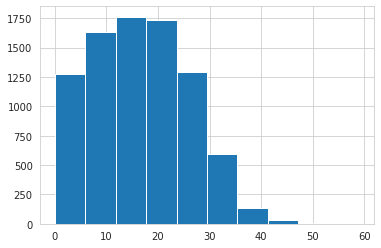

all_act_cred_1


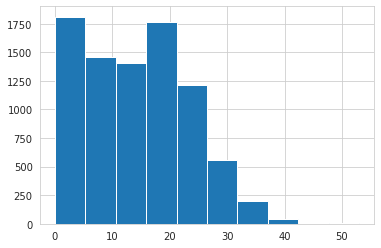

all_act_cred_3_1


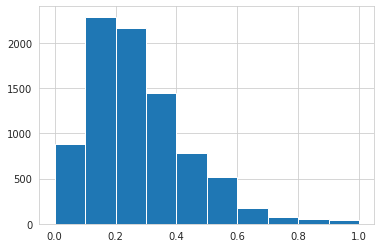

all_act_cred_2


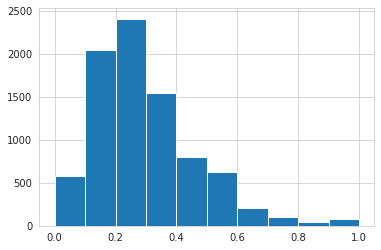

all_act_3_1_d


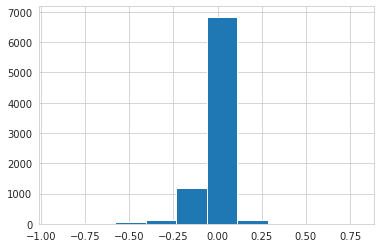

all_act_cred_3  all_act_cred_1  all_act_cred_3_1  all_act_cred_2  \
count     8461.000000     8461.000000       8444.000000     8426.000000   
mean        16.386006       14.277509          0.273474        0.295728   
std          9.460627        9.048127          0.162797        0.169544   
min          0.000000        0.000000          0.000000        0.000000   
25%          9.000000        6.000000          0.155300        0.179225   
50%         16.000000       14.000000          0.244100        0.265300   
75%         23.000000       21.000000          0.360000        0.377300   
max         59.000000       53.000000          1.000000        1.000000   

       all_act_3_1_d  
count    8426.000000  
mean       -0.022155  
std         0.090049  
min        -0.923100  
25%        -0.033800  
50%         0.000000  
75%         0.008100  
max         0.800000

In [ ]:
for col in df[['all_act_cred_3', 'all_act_cred_1', 'all_act_cred_3_1', 'all_act_cred_2', 'all_act_3_1_d']]:
    print(col)
    plt.hist(df[col])
    plt.show()

df[['all_act_cred_3', 'all_act_cred_1', 'all_act_cred_3_1', 'all_act_cred_2', 'all_act_3_1_d']].describe()

all_cred_rep_3
0.00          76
5000.00       28
10000.00      24
6000.00       19
8000.00       15
              ..
9300.00        1
590112.50      1
740096.04      1
133399.36      1
2769225.08     1
Name: all_cred_rep_3, Length: 7697, dtype: int64


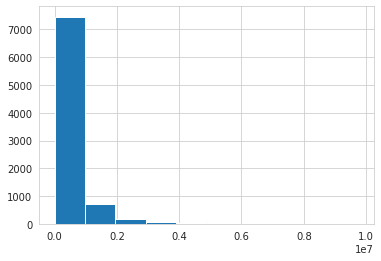

all_cred_rep_1
0.00         161
5000.00       42
2000.00       40
3000.00       32
10000.00      31
            ... 
398605.00      1
105795.50      1
761628.00      1
608519.00      1
541140.56      1
Name: all_cred_rep_1, Length: 7285, dtype: int64


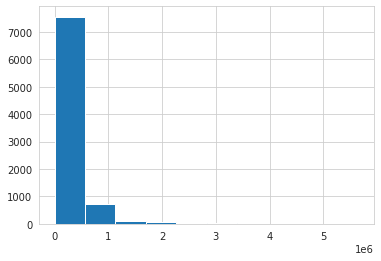

all_cred_rep_13
0.0000    62
1.0000    36
0.5000    14
0.3053     8
0.2709     7
          ..
0.0811     1
0.1479     1
0.5784     1
0.8808     1
0.3095     1
Name: all_cred_rep_13, Length: 5132, dtype: int64


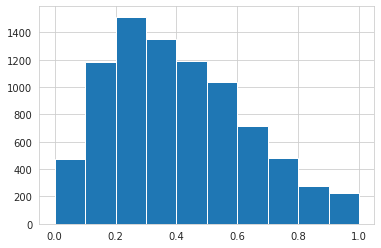

all_cred_rep_11
0.0000    129
1.0000     75
0.5000     15
0.6000     12
0.4286      8
         ... 
0.2930      1
0.3272      1
0.8347      1
0.4454      1
0.5319      1
Name: all_cred_rep_11, Length: 4860, dtype: int64


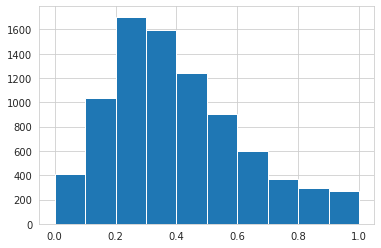

all_rep_cred_1
 0.0000    1767
-0.0021      10
-0.0119       9
-0.0050       9
-0.0031       9
           ... 
-0.1633       1
-0.1377       1
-0.4433       1
-0.2672       1
-0.1515       1
Name: all_rep_cred_1, Length: 3663, dtype: int64


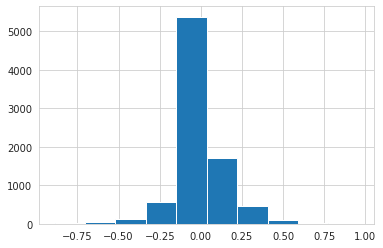

all_cred_rep_3  all_cred_rep_1  all_cred_rep_13  all_cred_rep_11  \
count    8.461000e+03    8.461000e+03      8444.000000      8426.000000   
mean     4.737273e+05    2.796516e+05         0.406046         0.402489   
std      6.545530e+05    3.442956e+05         0.223052         0.220023   
min      0.000000e+00    0.000000e+00         0.000000         0.000000   
25%      1.060000e+05    7.135010e+04         0.227775         0.243300   
50%      2.780218e+05    1.917260e+05         0.375000         0.365200   
75%      5.720000e+05    3.762720e+05         0.556700         0.529475   
max      9.768463e+06    5.659419e+06         1.000000         1.000000   

       all_rep_cred_1  
count     8426.000000  
mean         0.003651  
std          0.149214  
min         -0.889600  
25%         -0.042775  
50%          0.000000  
75%          0.045750  
max          0.961300

In [ ]:
for col in df[['all_cred_rep_3', 'all_cred_rep_1', 'all_cred_rep_13', 'all_cred_rep_11', 'all_rep_cred_1']]:
    print(col)
    print(df[col].value_counts())
    plt.hist(df[col])
    plt.show()
 
df[['all_cred_rep_3', 'all_cred_rep_1', 'all_cred_rep_13', 'all_cred_rep_11', 'all_rep_cred_1']].describe()

all_act_cred


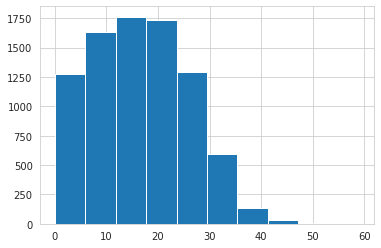

all_act_cred_s


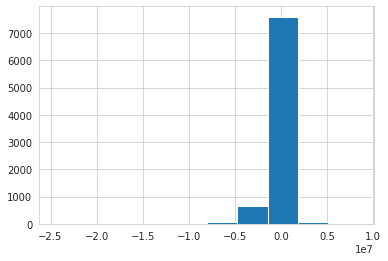

all_act_cred  all_act_cred_s
count   8461.000000    8.461000e+03
mean      16.386006   -3.841207e+05
std        9.460627    1.343868e+06
min        0.000000   -2.456709e+07
25%        9.000000   -5.161351e+05
50%       16.000000   -9.423000e+04
75%       23.000000    3.521754e+04
max       59.000000    8.463463e+06

In [ ]:
for col in df[['all_act_cred', 'all_act_cred_s']]:
    print(col)
    plt.hist(df[col])
    plt.show()

df[['all_act_cred', 'all_act_cred_s']].describe()

count    8.461000e+03
mean     4.737273e+05
std      6.545530e+05
min      0.000000e+00
25%      1.060000e+05
50%      2.780218e+05
75%      5.720000e+05
max      9.768463e+06
Name: test_1, dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Данный признак содержит 0 пропусков


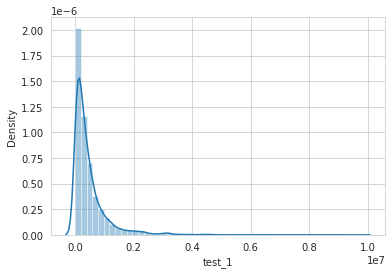

In [ ]:
num_stats(df.test_1)

sum_debt


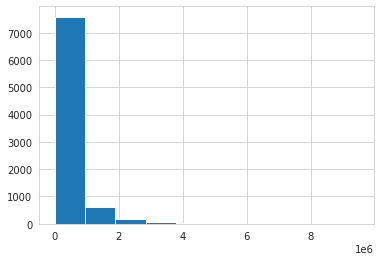

sum_debt_1


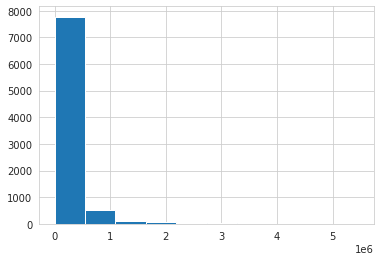

sum_limit


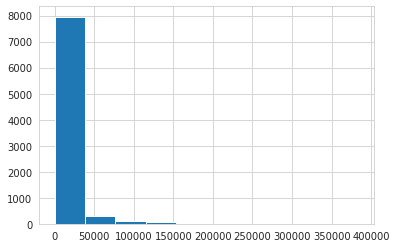

sum_debt    sum_debt_1      sum_limit
count  8.461000e+03  8.461000e+03    8461.000000
mean   4.046909e+05  2.209907e+05    7312.872190
std    6.360127e+05  3.111499e+05   22157.484684
min    0.000000e+00  0.000000e+00       0.000000
25%    5.799979e+04  3.500000e+04       0.000000
50%    2.030444e+05  1.262200e+05       0.100000
75%    4.969122e+05  3.031942e+05    2101.320000
max    9.507831e+06  5.471692e+06  384466.370000

In [ ]:
for col in df[['sum_debt', 'sum_debt_1', 'sum_limit']]:
    print(col)
    plt.hist(df[col])
    plt.show()

df[['sum_debt', 'sum_debt_1', 'sum_limit']].describe()

sum_overdue


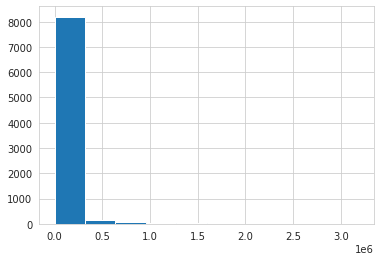

day_overdue


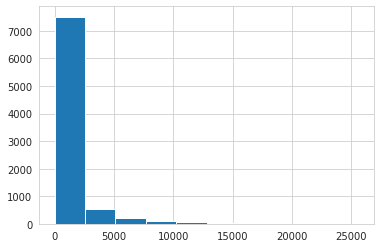

max_overdue


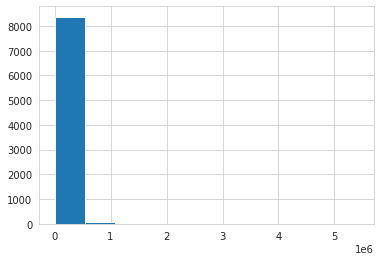

max_overdue_1


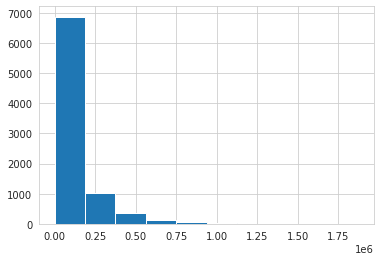

max_overdue_2


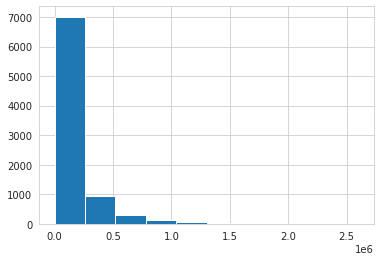

max_overdue_3


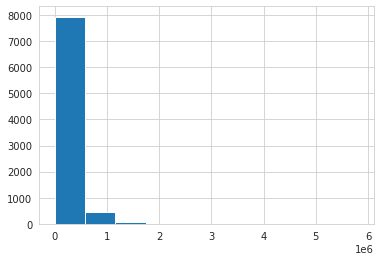

sum_overdue   day_overdue   max_overdue  max_overdue_1  max_overdue_2  \
count  8.461000e+03   8461.000000  8.461000e+03   8.461000e+03   8.461000e+03   
mean   5.920721e+04    899.129417  5.125937e+04   1.020332e+05   1.372400e+05   
std    1.555999e+05   2097.236169  1.926961e+05   1.626257e+05   2.172839e+05   
min    0.000000e+00      0.000000  0.000000e+00   0.000000e+00   0.000000e+00   
25%    0.000000e+00      0.000000  9.616490e+03   0.000000e+00   4.879620e+03   
50%    1.026814e+04     38.000000  2.000000e+04   3.095423e+04   4.571687e+04   
75%    5.919109e+04    733.000000  3.390511e+04   1.387516e+05   1.802172e+05   
max    3.188432e+06  25633.000000  5.436437e+06   1.878882e+06   2.605249e+06   

       max_overdue_3  
count   8.461000e+03  
mean    1.563956e+05  
std     2.489490e+05  
min     0.000000e+00  
25%     7.500000e+03  
50%     5.575861e+04  
75%     2.048021e+05  
max     5.825499e+06

In [ ]:
for col in df[['sum_overdue', 'day_overdue', 'max_overdue', 'max_overdue_1', 'max_overdue_2', 'max_overdue_3']]:
    print(col)
    plt.hist(df[col])
    plt.show()

df[['sum_overdue', 'day_overdue', 'max_overdue', 'max_overdue_1', 'max_overdue_2', 'max_overdue_3']].describe()

count    8461.000000
mean       32.077414
std        57.469606
min         0.000000
25%         4.000000
50%        14.000000
75%        38.000000
max       877.000000
Name: prolong, dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Данный признак содержит 0 пропусков


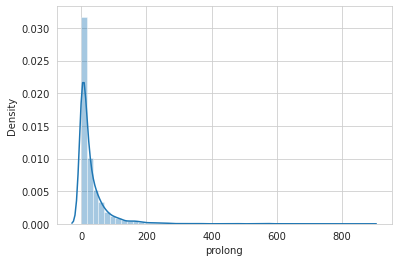

In [ ]:
#продление
num_stats(df.prolong)

ti_hour


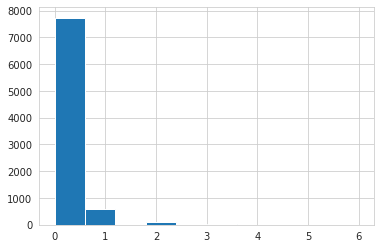

ti_day


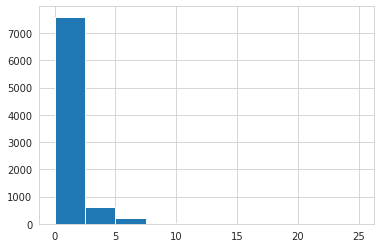

ti_week


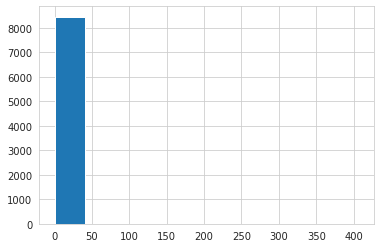

ti_week_all


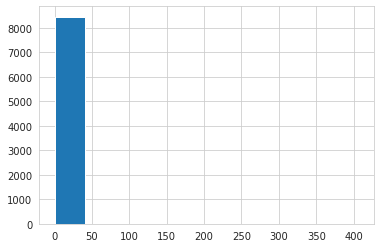

ti_month


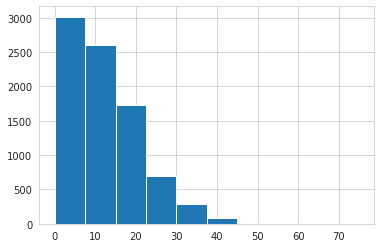

ti_month_all


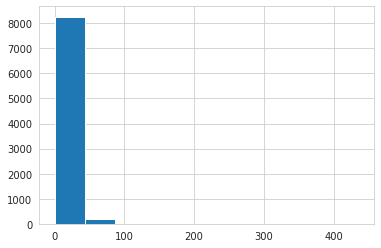

ti_quarter


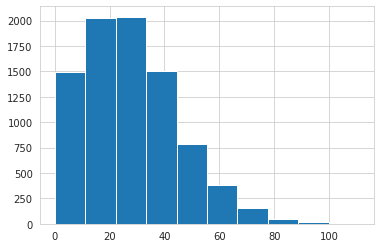

ti_year


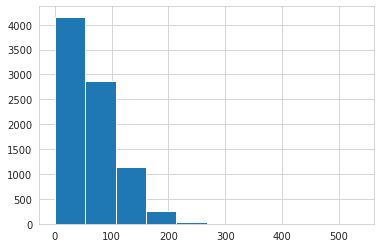

ti_hour       ti_day      ti_week  ti_week_all     ti_month  \
count  8461.000000  8461.000000  8461.000000  8461.000000  8461.000000   
mean      0.108261     0.837253     3.143836     4.089351    12.238388   
std       0.395727     1.448930     5.437132     5.781854     8.932834   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     1.000000     1.000000     5.000000   
50%       0.000000     0.000000     2.000000     3.000000    10.000000   
75%       0.000000     1.000000     5.000000     6.000000    17.000000   
max       6.000000    25.000000   407.000000   407.000000    75.000000   

       ti_month_all   ti_quarter      ti_year  
count   8461.000000  8461.000000  8461.000000  
mean      16.327739    28.172793    63.022338  
std       12.080112    17.369273    47.296173  
min        0.000000     0.000000     0.000000  
25%        8.000000    15.000000    26.000000  
50%       14.000000    26.000000    55.000000  
75%       23.000000    39.000000    90.000000  
max      436.000000   111.000000   535.000000

In [ ]:
for col in df[['ti_hour', 'ti_day', 'ti_week', 'ti_week_all', 'ti_month', 'ti_month_all', 'ti_quarter', 'ti_year']]:
    print(col)
    plt.hist(df[col])
    plt.show()

df[['ti_hour', 'ti_day', 'ti_week', 'ti_week_all', 'ti_month', 'ti_month_all', 'ti_quarter', 'ti_year']].describe()

cred_date_last


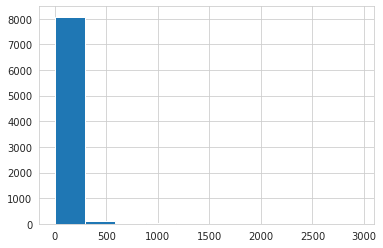

cred_date_last_1


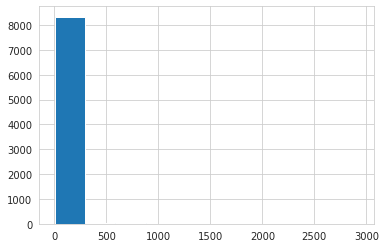

cred_date_last_2


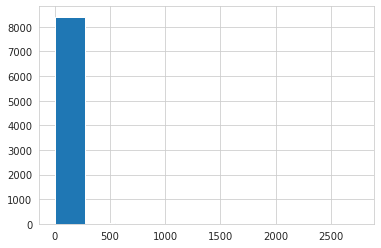

cred_date_last  cred_date_last_1  cred_date_last_2
count     8259.000000       8430.000000       8449.000000
mean        35.596440         39.508778         18.557462
std        150.779288        107.295062         60.718803
min          0.000000          1.000000          0.000000
25%          5.000000         14.000000          5.000000
50%          9.000000         24.000000          9.000000
75%         17.000000         38.000000         17.000000
max       2950.000000       2929.000000       2752.000000

In [ ]:
#дата последнего кредита
for col in df[['cred_date_last', 'cred_date_last_1', 'cred_date_last_2']]:
    print(col)
    plt.hist(df[col])
    plt.show()

df[['cred_date_last', 'cred_date_last_1', 'cred_date_last_2']].describe()

count    8.461000e+03
mean     1.627859e+05
std      2.083733e+05
min      0.000000e+00
25%      2.674000e+04
50%      1.005900e+05
75%      2.365559e+05
max      5.122134e+06
Name: sum_debt_last, dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Данный признак содержит 0 пропусков


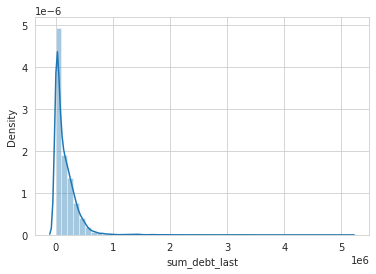

In [ ]:
num_stats(df.sum_debt_last)

hist_days


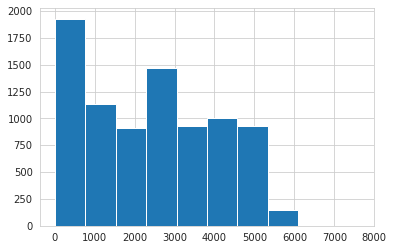

hist_days_m


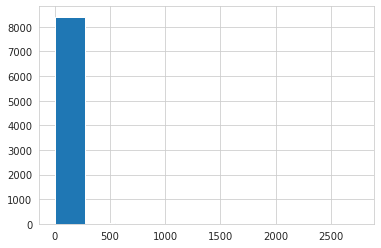

hist_days  hist_days_m
count  8449.000000  8449.000000
mean   2421.635341    18.557462
std    1624.093396    60.718803
min       4.000000     0.000000
25%     856.000000     5.000000
50%    2429.000000     9.000000
75%    3770.000000    17.000000
max    7620.000000  2752.000000

In [ ]:
for col in df[['hist_days', 'hist_days_m']]:
    print(col)
    plt.hist(df[col])
    plt.show()

df[['hist_days', 'hist_days_m']].describe()

dog_bad


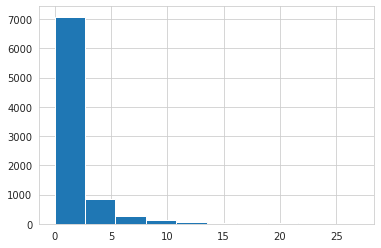

dog_bad_180


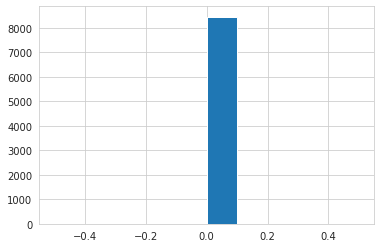

dog_bad_360


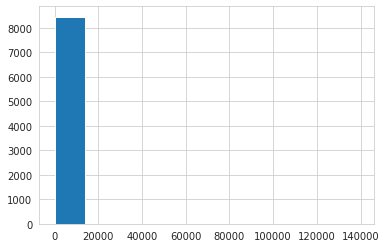

dog_bad_1080


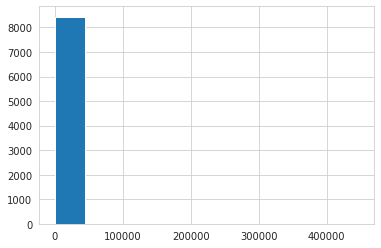

dog_bad  dog_bad_180    dog_bad_360   dog_bad_1080
count  8461.000000       8461.0    8461.000000    8461.000000
mean      1.306465          0.0      32.717055     563.320766
std       2.629401          0.0    1595.606514   11659.485564
min       0.000000          0.0       0.000000       0.000000
25%       0.000000          0.0       0.000000       0.000000
50%       0.000000          0.0       0.000000       0.000000
75%       1.000000          0.0       0.000000       0.000000
max      27.000000          0.0  139245.000000  447247.000000

In [ ]:
for col in df[['dog_bad', 'dog_bad_180', 'dog_bad_360', 'dog_bad_1080']]:
    print(col)
    plt.hist(df[col])
    plt.show()

df[['dog_bad', 'dog_bad_180', 'dog_bad_360', 'dog_bad_1080']].describe()

In [ ]:
#В признаке dog_bad_180 - только нулевые значения, считаю, что его можно удалить:
df.drop(['dog_bad_180'], axis=1, inplace=True)

sum_over_1080


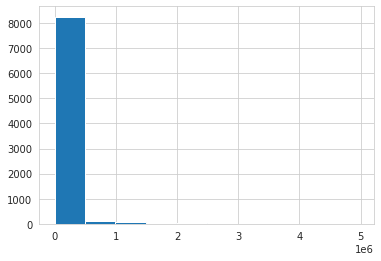

sum_over_720


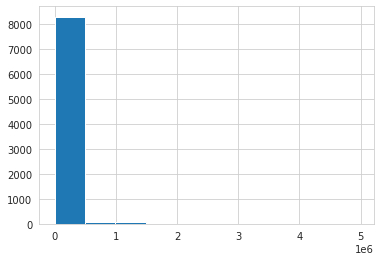

sum_over_360


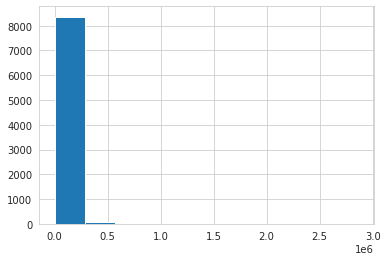

sum_over_1_89


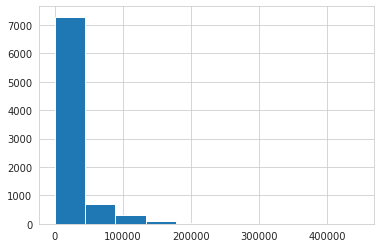

sum_over_90


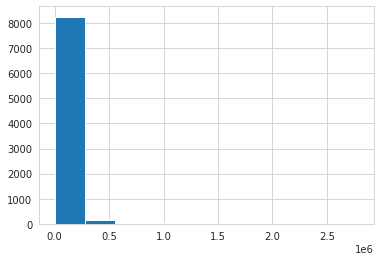

sum_over_89_90


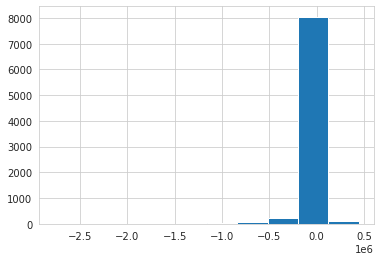

avg_over_1_90


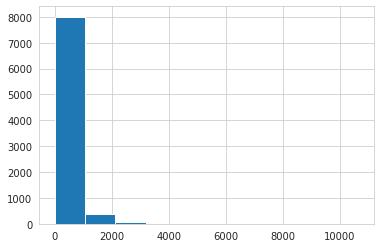

sum_over_9000


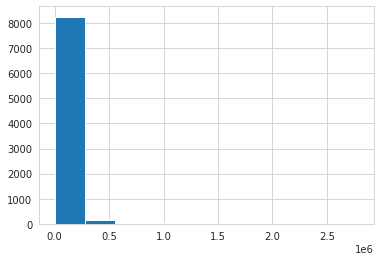

sum_over_1080  sum_over_720  sum_over_360  sum_over_1_89   sum_over_90  \
count   8.461000e+03  8.461000e+03  8.461000e+03    8461.000000  8.461000e+03   
mean    4.980432e+04  3.716569e+04  1.619666e+04   18236.742430  3.258060e+04   
std     2.267278e+05  1.861798e+05  9.337584e+04   35725.330155  1.199061e+05   
min     0.000000e+00  0.000000e+00  0.000000e+00       0.000000  0.000000e+00   
25%     0.000000e+00  0.000000e+00  0.000000e+00       0.000000  0.000000e+00   
50%     0.000000e+00  0.000000e+00  0.000000e+00       0.000000  0.000000e+00   
75%     7.605660e+03  4.900730e+03  0.000000e+00   20396.360000  1.702777e+04   
max     4.971090e+06  4.971090e+06  2.869527e+06  446266.280000  2.793151e+06   

       sum_over_89_90  avg_over_1_90  sum_over_9000  
count    8.461000e+03    8461.000000   8.461000e+03  
mean    -1.434386e+04     224.286061   3.258060e+04  
std      1.223020e+05     453.013001   1.199061e+05  
min     -2.768151e+06       0.000000   0.000000e+00  
25%      0.000000e+00       0.000000   0.000000e+00  
50%      0.000000e+00       0.000000   0.000000e+00  
75%      1.000000e+04     265.151500   1.702777e+04  
max      4.462663e+05   10661.740500   2.793151e+06

In [ ]:
for col in df[['sum_over_1080', 'sum_over_720', 'sum_over_360', 'sum_over_1_89', 'sum_over_90', 'sum_over_89_90',
              'avg_over_1_90', 'sum_over_9000']]:
    print(col)
    plt.hist(df[col])
    plt.show()

df[['sum_over_1080', 'sum_over_720', 'sum_over_360', 'sum_over_1_89', 'sum_over_90', 'sum_over_89_90',
              'avg_over_1_90', 'sum_over_9000']].describe()

sum_mfo


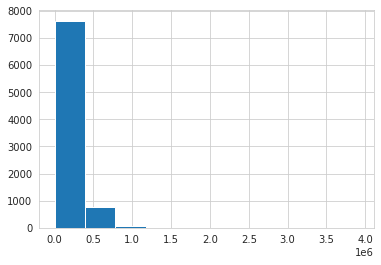

over_mfo


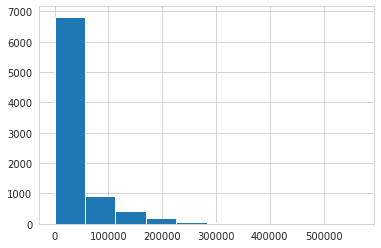

сoun_over_mfo


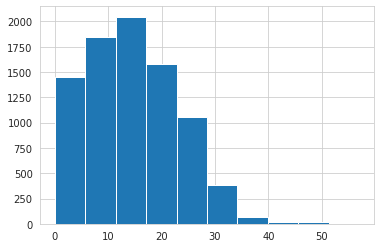

сount_cls_mfo


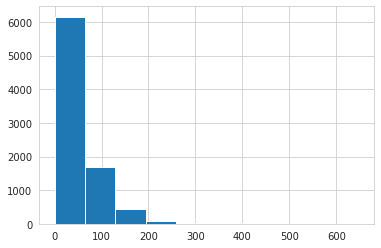

p_cls_mfo_365


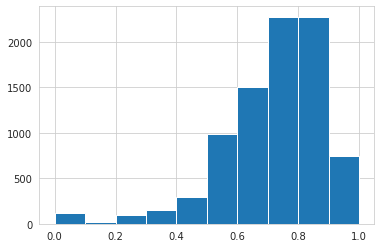

sum_mfo       over_mfo  сoun_over_mfo  сount_cls_mfo  \
count  8.461000e+03    8461.000000    8461.000000    8461.000000   
mean   1.809478e+05   31490.809432      14.589883      49.851554   
std    1.635226e+05   55211.068999       8.615842      52.737928   
min    0.000000e+00       0.000000       0.000000       0.000000   
25%    5.758000e+04       0.000000       8.000000      13.000000   
50%    1.429936e+05    2921.900000      14.000000      34.000000   
75%    2.602549e+05   40500.000000      21.000000      69.000000   
max    3.917234e+06  565635.430000      57.000000     648.000000   

       p_cls_mfo_365  
count    8461.000000  
mean        0.717186  
std         0.171936  
min         0.000000  
25%         0.641000  
50%         0.750000  
75%         0.830900  
max         1.000000

In [ ]:
for col in df[['sum_mfo', 'over_mfo', 'сoun_over_mfo', 'сount_cls_mfo', 'p_cls_mfo_365']]:
    print(col)
    plt.hist(df[col])
    plt.show()

df[['sum_mfo', 'over_mfo', 'сoun_over_mfo', 'сount_cls_mfo', 'p_cls_mfo_365']].describe()

sum_12_month


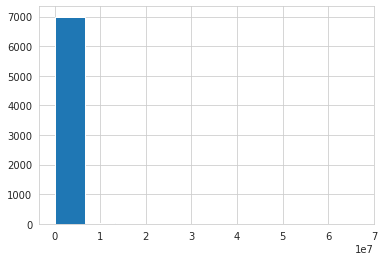

avg_12_month


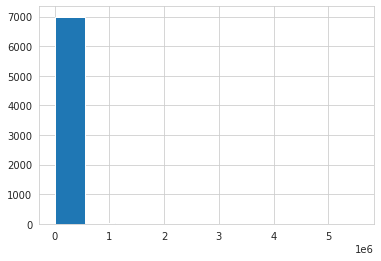

sum_12_month  avg_12_month
count  7.033000e+03  7.033000e+03
mean   7.614597e+05  6.345497e+04
std    1.357116e+06  1.130930e+05
min    0.000000e+00  0.000000e+00
25%    1.220116e+05  1.016764e+04
50%    4.007483e+05  3.339569e+04
75%    9.689890e+05  8.074908e+04
max    6.671020e+07  5.559183e+06

In [ ]:
for col in df[['sum_12_month', 'avg_12_month']]:
    print(col)
    plt.hist(df[col])
    plt.show()

df[['sum_12_month', 'avg_12_month']].describe()

Count_0


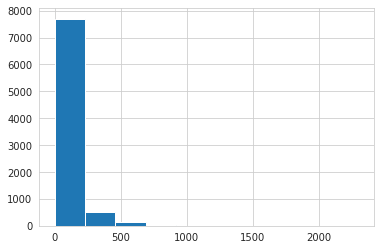

Count_1


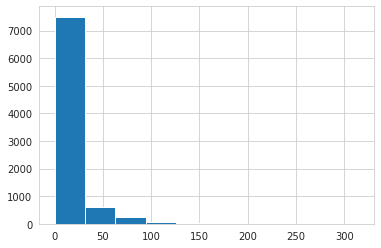

Count_2


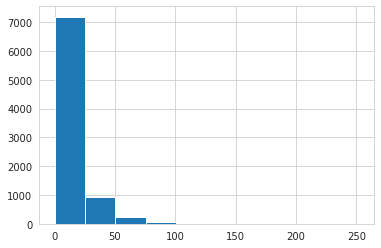

Count_3


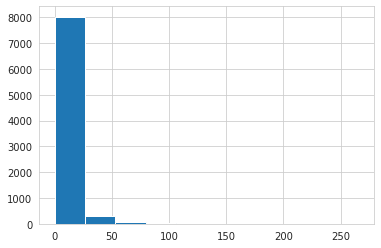

Count_4


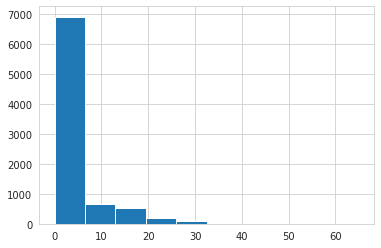

Count_5


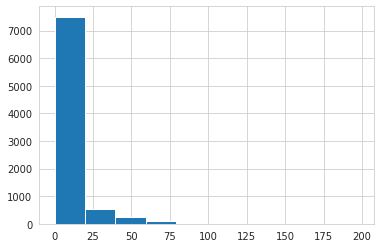

Count_6


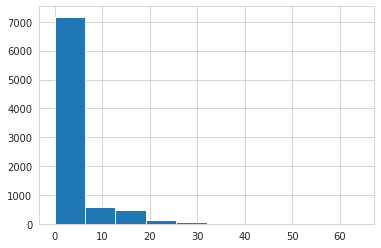

Count_7


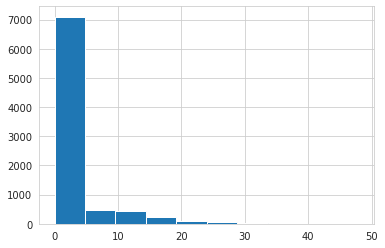

Count_8


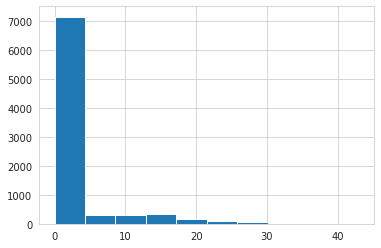

Count_9


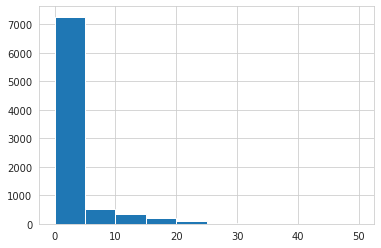

Count_0      Count_1      Count_2      Count_3      Count_4  \
count  8426.000000  8426.000000  8426.000000  8426.000000  8426.000000   
mean     88.779255    11.779136    11.454545     6.153098     3.316995   
std     130.502301    20.562274    17.906646    13.933051     6.597673   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%      19.000000     0.000000     0.000000     0.000000     0.000000   
50%      51.000000     4.000000     4.000000     1.000000     0.000000   
75%     100.000000    13.000000    17.000000     7.000000     3.000000   
max    2302.000000   315.000000   252.000000   266.000000    65.000000   

           Count_5      Count_6      Count_7      Count_8      Count_9  
count  8426.000000  8426.000000  8426.000000  8426.000000  8426.000000  
mean      5.705673     2.517802     2.183954     2.293378     1.780679  
std      14.388967     5.721694     5.221581     5.625448     4.600641  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000     0.000000     0.000000  
50%       0.000000     0.000000     0.000000     0.000000     0.000000  
75%       2.000000     1.000000     1.000000     0.000000     0.000000  
max     198.000000    64.000000    48.000000    43.000000    50.000000

In [ ]:
for col in df[['Count_0', 'Count_1', 'Count_2', 'Count_3', 'Count_4', 'Count_5',
              'Count_6', 'Count_7', 'Count_8', 'Count_9']]:
    print(col)
    plt.hist(df[col])
    plt.show()

df[['Count_0', 'Count_1', 'Count_2', 'Count_3', 'Count_4', 'Count_5',
              'Count_6', 'Count_7', 'Count_8', 'Count_9']].describe()

Count_B


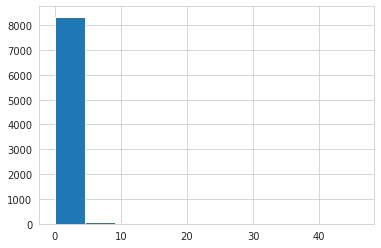

Count_C


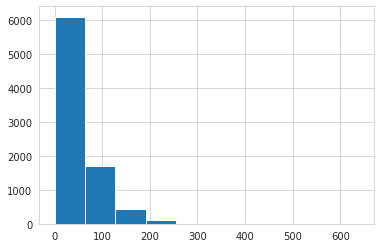

Count_I


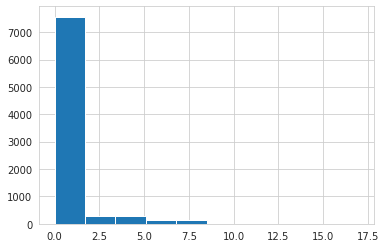

Count_R


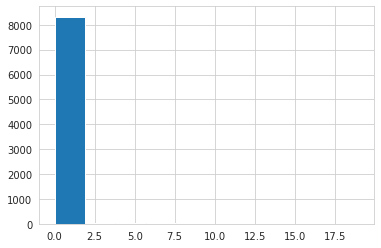

Count_S


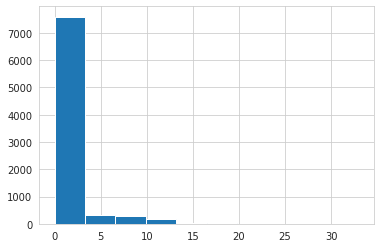

Count_Sp


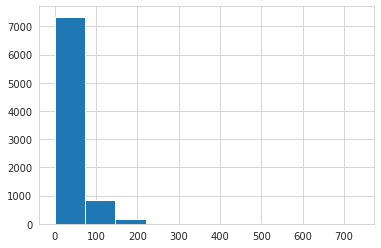

Count_T


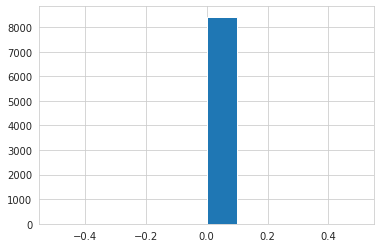

Count_U


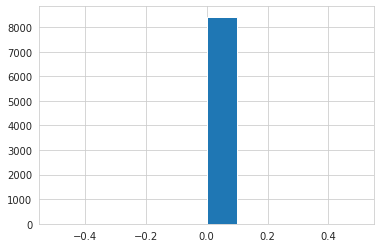

Count_W


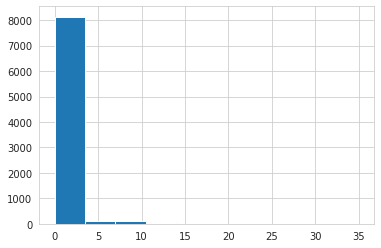

Count_B      Count_C      Count_I      Count_R      Count_S  \
count  8426.000000  8426.000000  8426.000000  8426.000000  8426.000000   
mean      0.159744    49.543200     0.474721     0.065512     0.911108   
std       1.184418    52.100484     1.519609     0.654030     2.683645   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000    13.000000     0.000000     0.000000     0.000000   
50%       0.000000    34.000000     0.000000     0.000000     0.000000   
75%       0.000000    68.000000     0.000000     0.000000     0.000000   
max      46.000000   639.000000    17.000000    19.000000    33.000000   

          Count_Sp  Count_T  Count_U      Count_W  
count  8426.000000   8426.0   8426.0  8426.000000  
mean     37.373487      0.0      0.0     0.310586  
std      46.512370      0.0      0.0     1.763332  
min       0.000000      0.0      0.0     0.000000  
25%      10.000000      0.0      0.0     0.000000  
50%      24.000000      0.0      0.0     0.000000  
75%      49.000000      0.0      0.0     0.000000  
max     736.000000      0.0      0.0    35.000000

In [ ]:
for col in df[['Count_B', 'Count_C', 'Count_I', 'Count_R', 'Count_S', 'Count_Sp',
              'Count_T', 'Count_U', 'Count_W']]:
    print(col)
    plt.hist(df[col])
    plt.show()

df[['Count_B', 'Count_C', 'Count_I', 'Count_R', 'Count_S', 'Count_Sp',
              'Count_T', 'Count_U', 'Count_W']].describe()

In [ ]:
#Признаки 'Count_T', 'Count_U' имеют только 0 значение, удалим их
df.drop(['Count_T', 'Count_U'], axis=1, inplace=True)

Count_0_len_num


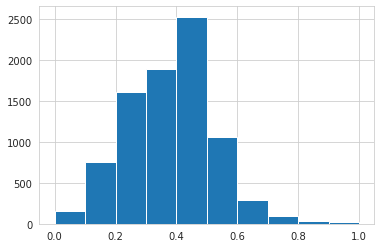

Count_01_len_num


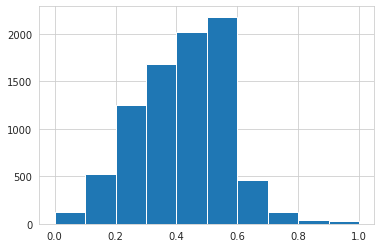

Count_12_len_num


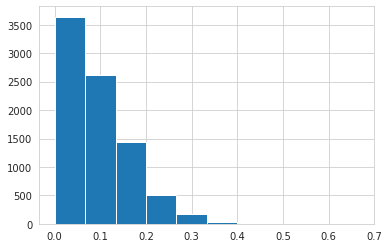

Count_456_len_num


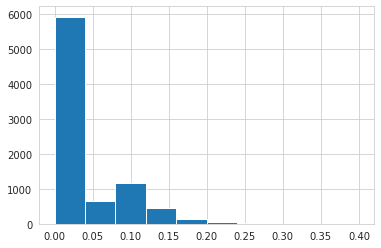

Count_5B_len_num


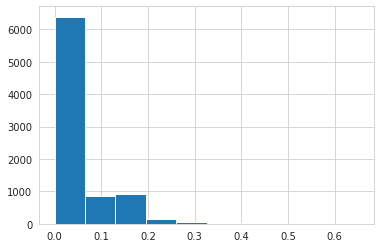

Count_C_len_num


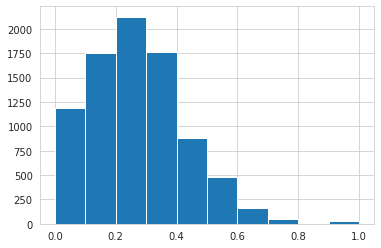

Count_Sp_len_num


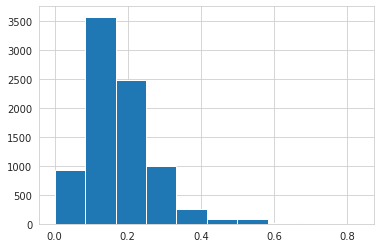

Count_0_len_num  Count_01_len_num  Count_12_len_num  Count_456_len_num  \
count      8426.000000       8426.000000       8426.000000        8426.000000   
mean          0.379022          0.418514          0.088568           0.032635   
std           0.143725          0.147675          0.079121           0.052137   
min           0.000000          0.000000          0.000000           0.000000   
25%           0.278325          0.315800          0.011925           0.000000   
50%           0.388900          0.432450          0.083300           0.000000   
75%           0.466700          0.519975          0.135100           0.067150   
max           1.000000          1.000000          0.666700           0.400000   

       Count_5B_len_num  Count_C_len_num  Count_Sp_len_num  
count       8426.000000      8426.000000       8426.000000  
mean           0.038419         0.271929          0.175125  
std            0.070780         0.155539          0.093125  
min            0.000000         0.000000          0.000000  
25%            0.000000         0.141225          0.120000  
50%            0.000000         0.260900          0.158800  
75%            0.055600         0.363600          0.220400  
max            0.652200         1.000000          0.833300

In [ ]:
for col in df[['Count_0_len_num', 'Count_01_len_num', 'Count_12_len_num', 'Count_456_len_num', 'Count_5B_len_num',
            'Count_C_len_num', 'Count_Sp_len_num']]:
    print(col)
    plt.hist(df[col])
    plt.show()

df[['Count_0_len_num', 'Count_01_len_num', 'Count_12_len_num', 'Count_456_len_num', 'Count_5B_len_num',
            'Count_C_len_num', 'Count_Sp_len_num']].describe()

count    8461.000000
mean        1.099515
std         5.063150
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max       257.000000
Name: N_record_IP, dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Данный признак содержит 0 пропусков


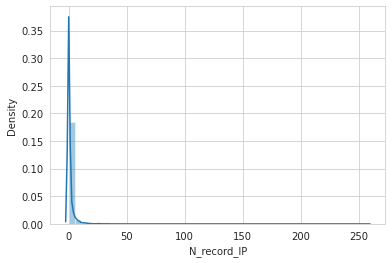

In [ ]:
num_stats(df.N_record_IP)

min_hist_IPDate


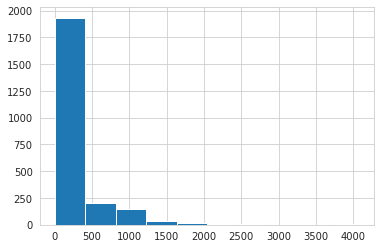

max_hist_IPDate


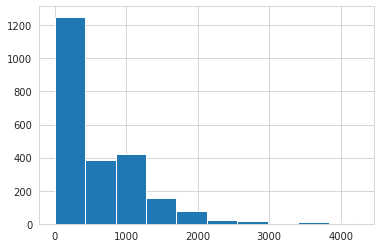

min_hist_RIDDate


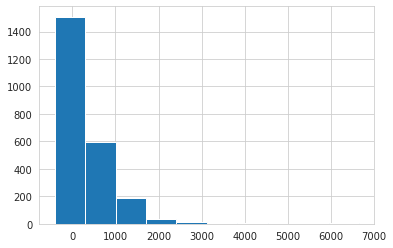

max_hist_RIDDate


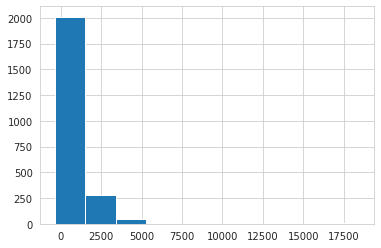

min_hist_IPEndDate


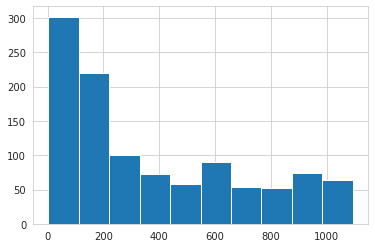

max_hist_IPEndDate


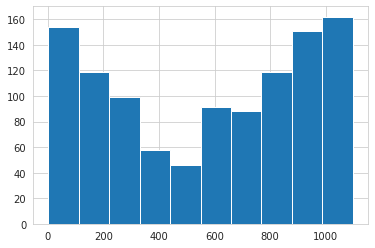

min_hist_IPDate  max_hist_IPDate  min_hist_RIDDate  max_hist_RIDDate  \
count      2351.000000      2351.000000       2351.000000       2351.000000   
mean        243.600170       599.412590        401.071034        872.453424   
std         403.426126       635.788916        565.840925       1340.391308   
min           1.000000         2.000000       -413.000000       -378.000000   
25%          29.000000       109.000000        116.000000        213.000000   
50%          89.000000       359.000000        202.000000        519.000000   
75%         263.000000       997.000000        426.000000       1155.000000   
max        4080.000000      4256.000000       6660.000000      18457.000000   

       min_hist_IPEndDate  max_hist_IPEndDate  
count         1087.000000         1087.000000  
mean           369.531739          573.431463  
std            325.114852          356.944454  
min              3.000000            3.000000  
25%             99.500000          220.000000  
50%            236.000000          619.000000  
75%            608.000000          920.000000  
max           1093.000000         1097.000000

In [ ]:
for col in df[['min_hist_IPDate', 'max_hist_IPDate', 'min_hist_RIDDate', 'max_hist_RIDDate', 'min_hist_IPEndDate',
            'max_hist_IPEndDate']]:
    print(col)
    plt.hist(df[col])
    plt.show()

df[['min_hist_IPDate', 'max_hist_IPDate', 'min_hist_RIDDate', 'max_hist_RIDDate', 'min_hist_IPEndDate',
            'max_hist_IPEndDate']].describe()

count    8.461000e+03
mean     2.402184e+04
std      1.185157e+05
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.760986e+06
Name: max_Summa, dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Данный признак содержит 0 пропусков


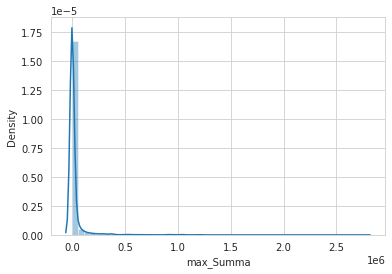

In [ ]:
num_stats(df.max_Summa)

sum_RIDDate_365


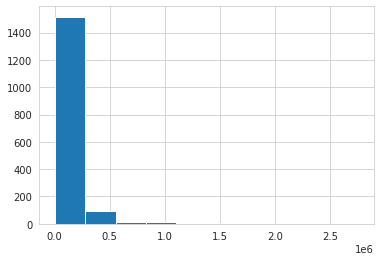

sum_RIDDate_180


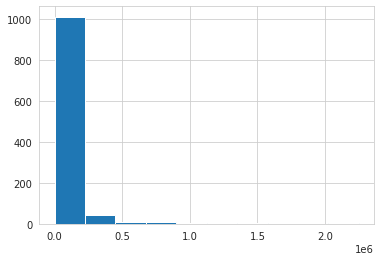

sum_RIDDate_730


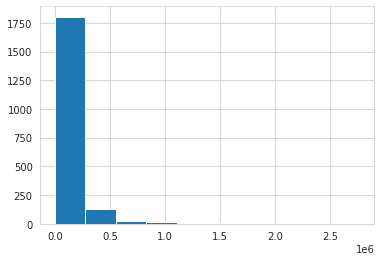

sum_RIDDate_365  sum_RIDDate_180  sum_RIDDate_730
count     1.650000e+03     1.079000e+03     1.991000e+03
mean      8.446917e+04     6.833374e+04     9.373036e+04
std       2.080827e+05     1.748922e+05     2.174609e+05
min       0.000000e+00     0.000000e+00     0.000000e+00
25%       1.000000e+03     1.000000e+03     1.000000e+03
50%       2.250578e+04     2.048132e+04     2.343219e+04
75%       7.897369e+04     6.055054e+04     8.990883e+04
max       2.760986e+06     2.249637e+06     2.760986e+06

In [ ]:
for col in df[['sum_RIDDate_365', 'sum_RIDDate_180', 'sum_RIDDate_730']]:
    print(col)
    plt.hist(df[col])
    plt.show()

df[['sum_RIDDate_365', 'sum_RIDDate_180', 'sum_RIDDate_730']].describe()

cred_count


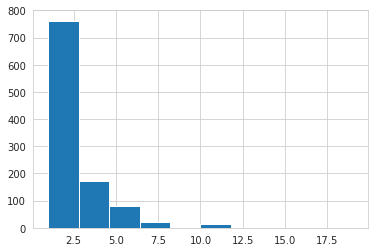

cred_summ


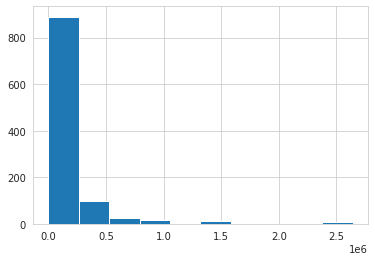

cred_count     cred_summ
count  1058.000000  1.058000e+03
mean      2.257089  1.612043e+05
std       1.923827  3.370864e+05
min       1.000000  0.000000e+00
25%       1.000000  6.302953e+03
50%       2.000000  5.298150e+04
75%       3.000000  1.597453e+05
max      19.000000  2.641874e+06

In [ ]:
#количество кредитов, сумма кредитов
for col in df[['cred_count', 'cred_summ']]:
    print(col)
    plt.hist(df[col])
    plt.show()

df[['cred_count', 'cred_summ']].describe()

st_NULL__180_sum


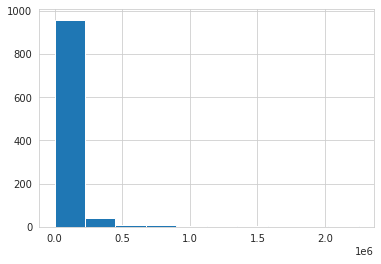

st_NULL__365_sum


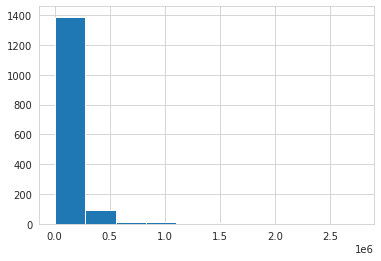

st_NULL__730_sum


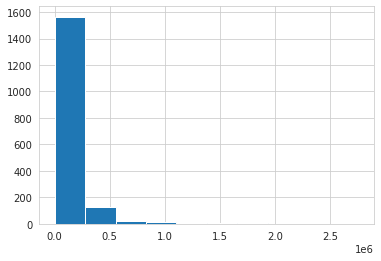

st_NULL__180_sum  st_NULL__365_sum  st_NULL__730_sum
count      1.027000e+03      1.524000e+03      1.748000e+03
mean       7.179368e+04      9.140606e+04      1.064676e+05
std        1.785745e+05      2.150500e+05      2.289071e+05
min        0.000000e+00      0.000000e+00      0.000000e+00
25%        2.000000e+03      3.000000e+03      3.737250e+03
50%        2.459477e+04      2.962733e+04      3.149455e+04
75%        6.480164e+04      8.830704e+04      1.092261e+05
max        2.249637e+06      2.760986e+06      2.760986e+06

In [ ]:
for col in df[['st_NULL__180_sum', 'st_NULL__365_sum', 'st_NULL__730_sum']]:
    print(col)
    plt.hist(df[col])
    plt.show()

df[['st_NULL__180_sum', 'st_NULL__365_sum', 'st_NULL__730_sum']].describe()

st_NULL__180_count


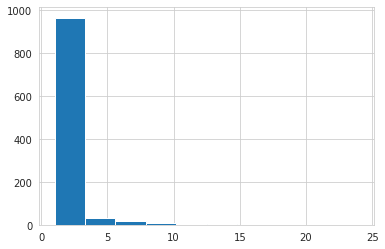

st_NULL__365_count


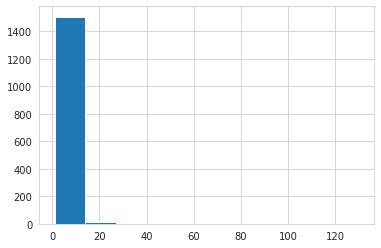

st_NULL__730_count


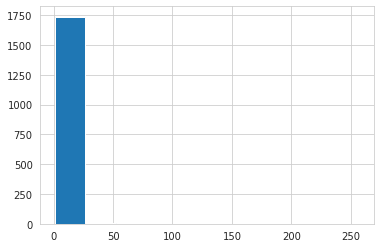

st_NULL__180_count  st_NULL__365_count  st_NULL__730_count
count         1027.000000         1524.000000         1748.000000
mean             1.697176            2.446850            3.081808
std              1.566841            4.342426            8.398807
min              1.000000            1.000000            1.000000
25%              1.000000            1.000000            1.000000
50%              1.000000            1.000000            2.000000
75%              2.000000            3.000000            3.000000
max             24.000000          130.000000          257.000000

In [ ]:
for col in df[['st_NULL__180_count', 'st_NULL__365_count', 'st_NULL__730_count']]:
    print(col)
    plt.hist(df[col])
    plt.show()

df[['st_NULL__180_count', 'st_NULL__365_count', 'st_NULL__730_count']].describe()

F_NumR_30_90


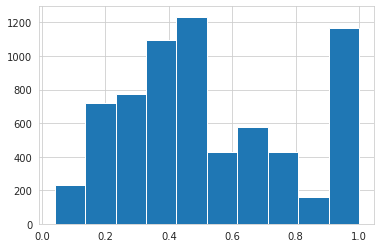

F_NumR_30_180


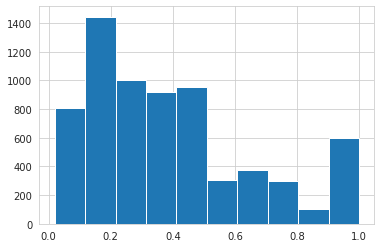

F_NumR_60_180


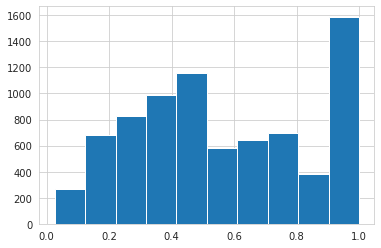

F_NumR_90_all


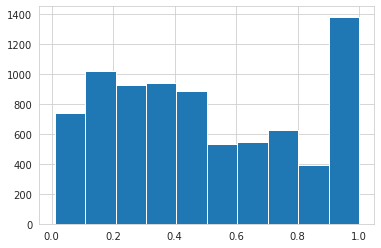

F_NumCP_30_90


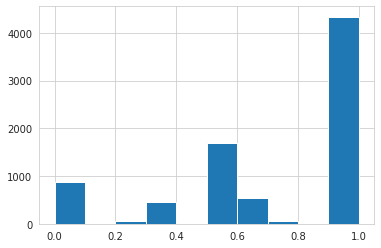

F_NumCP_30_180


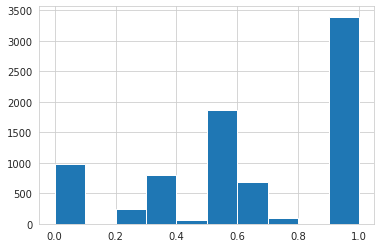

F_NumCP_60_180


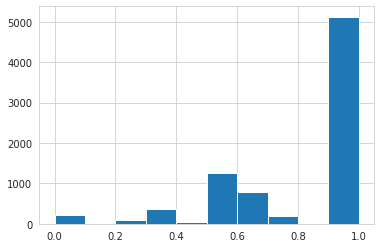

F_NumCP_90_all


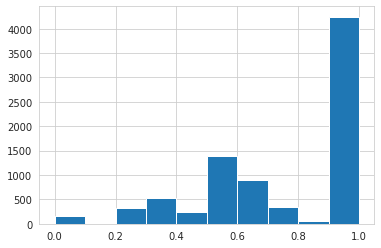

F_NumR_30_90  F_NumR_30_180  F_NumR_60_180  F_NumR_90_all  \
count   6814.000000    6814.000000    7812.000000    7989.000000   
mean       0.531546       0.395452       0.571650       0.506006   
std        0.277798       0.271485       0.289756       0.312820   
min        0.040000       0.019200       0.025600       0.009700   
25%        0.307700       0.176500       0.333300       0.230800   
50%        0.500000       0.333300       0.500000       0.461500   
75%        0.727300       0.500000       0.818200       0.769200   
max        1.000000       1.000000       1.000000       1.000000   

       F_NumCP_30_90  F_NumCP_30_180  F_NumCP_60_180  F_NumCP_90_all  
count    8029.000000     8133.000000     8133.000000     8189.000000  
mean        0.717958        0.642185        0.814802        0.757064  
std         0.345216        0.349525        0.268339        0.282452  
min         0.000000        0.000000        0.000000        0.000000  
25%         0.500000        0.400000        0.666700        0.500000  
50%         1.000000        0.666700        1.000000        1.000000  
75%         1.000000        1.000000        1.000000        1.000000  
max         1.000000        1.000000        1.000000        1.000000

In [ ]:
for col in df[['F_NumR_30_90', 'F_NumR_30_180', 'F_NumR_60_180', 'F_NumR_90_all',
              'F_NumCP_30_90', 'F_NumCP_30_180', 'F_NumCP_60_180', 'F_NumCP_90_all']]:
    print(col)
    plt.hist(df[col])
    plt.show()

df[['F_NumR_30_90', 'F_NumR_30_180', 'F_NumR_60_180', 'F_NumR_90_all',
              'F_NumCP_30_90', 'F_NumCP_30_180', 'F_NumCP_60_180', 'F_NumCP_90_all']].describe()

F_MFO_Date_lT


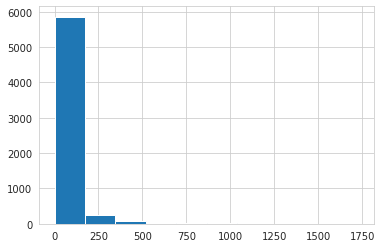

F_MFO_Date_SD


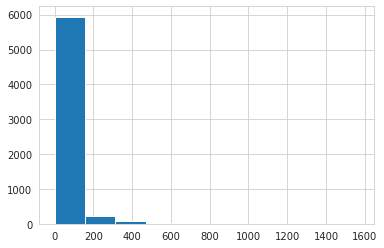

F_MFO_Date_SR


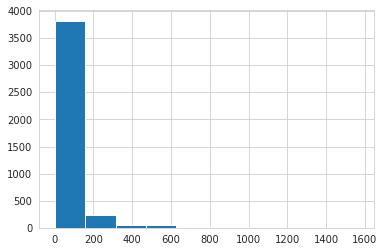

F_MFO_Date_TF


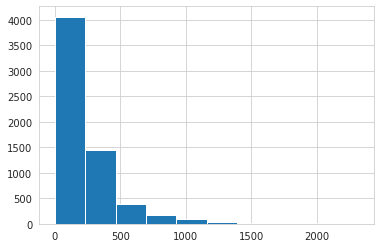

F_MFO_Date_DD


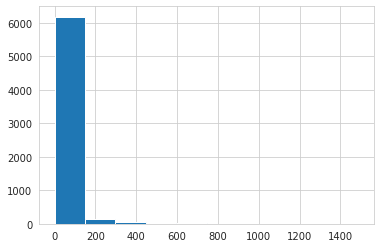

F_long_PhNum


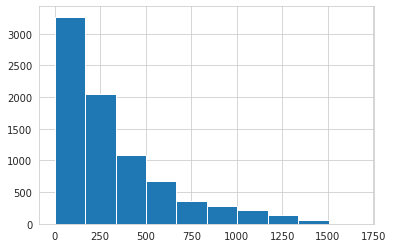

F_long_Card


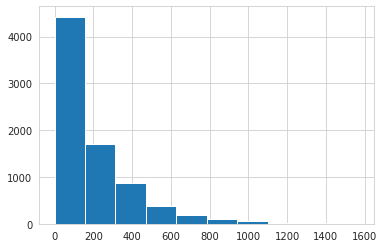

F_long_SA


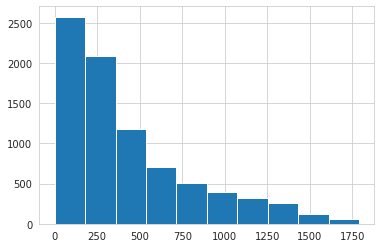

F_MFO_Date_lT  F_MFO_Date_SD  F_MFO_Date_SR  F_MFO_Date_TF  \
count    6228.000000    6297.000000    4202.000000    6228.000000   
mean       45.932081      36.071939      57.121847     234.581085   
std       104.638672      94.572626     125.191062     250.195529   
min         0.000000       0.000000       0.000000       0.000000   
25%         4.000000       2.000000       7.000000      77.000000   
50%        14.000000       7.000000      17.000000     161.000000   
75%        42.000000      24.000000      49.000000     299.000000   
max      1732.000000    1570.000000    1570.000000    2321.000000   

       F_MFO_Date_DD  F_long_PhNum  F_long_Card    F_long_SA  
count    6446.000000   8144.000000  7785.000000  8220.000000  
mean       26.239218    321.977284   199.754399   430.073844  
std        82.065117    308.445347   212.398464   382.489458  
min         0.000000      0.000000     0.000000     0.000000  
25%         2.000000     92.000000    50.000000   139.000000  
50%         5.000000    228.000000   126.000000   302.000000  
75%        16.000000    447.000000   276.000000   605.000000  
max      1491.000000   1672.000000  1571.000000  1790.000000

In [ ]:
for col in df[['F_MFO_Date_lT', 'F_MFO_Date_SD', 'F_MFO_Date_SR', 'F_MFO_Date_TF',
              'F_MFO_Date_DD', 'F_long_PhNum', 'F_long_Card', 'F_long_SA']]:
    print(col)
    plt.hist(df[col])
    plt.show()

df[['F_MFO_Date_lT', 'F_MFO_Date_SD', 'F_MFO_Date_SR', 'F_MFO_Date_TF',
              'F_MFO_Date_DD', 'F_long_PhNum', 'F_long_Card', 'F_long_SA']].describe()

In [ ]:
df['F_DF_Net'].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: F_DF_Net, dtype: float64

In [ ]:
#Признак F_DF_Net содержит только пропуски, удаляем его
df.drop(['F_DF_Net'], axis=1, inplace=True)

F_mfoCFor_30_90


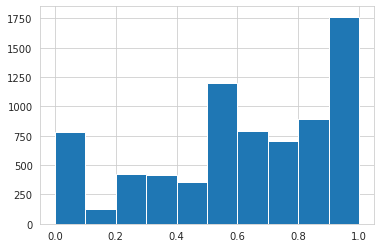

F_mfoCFor_30_180


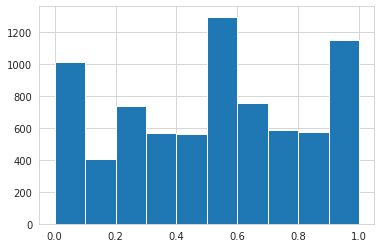

F_mfoCFor_90_180


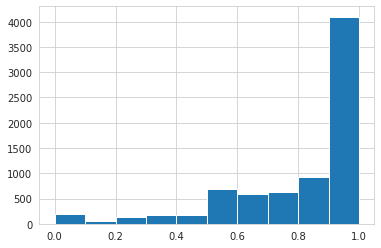

F_mfoCFor_180_30


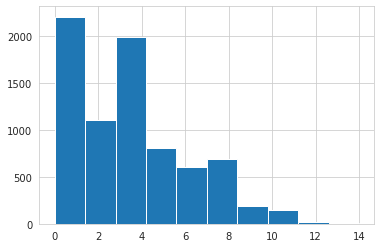

F_mfoCFor_180_90


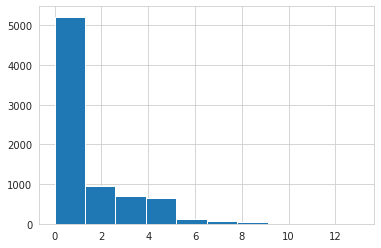

F_mfoCFor_90_30


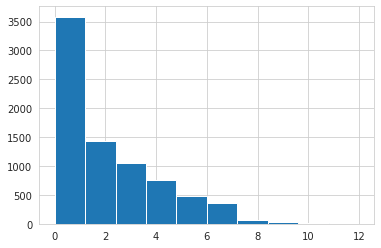

F_mfoCFor_30_90  F_mfoCFor_30_180  F_mfoCFor_90_180  F_mfoCFor_180_30  \
count      7449.000000       7640.000000       7640.000000       7778.000000   
mean          0.616669          0.513978          0.814840          3.412445   
std           0.315473          0.315674          0.245763          2.653368   
min           0.000000          0.000000          0.000000          0.000000   
25%           0.400000          0.250000          0.692300          1.000000   
50%           0.666700          0.500000          0.916700          3.000000   
75%           0.888900          0.750000          1.000000          5.000000   
max           1.000000          1.000000          1.000000         14.000000   

       F_mfoCFor_180_90  F_mfoCFor_90_30  
count       7778.000000      7778.000000  
mean           1.294549         2.117897  
std            1.734914         1.953651  
min            0.000000         0.000000  
25%            0.000000         1.000000  
50%            1.000000         2.000000  
75%            2.000000         3.000000  
max           13.000000        12.000000

In [ ]:
for col in df[['F_mfoCFor_30_90', 'F_mfoCFor_30_180', 'F_mfoCFor_90_180', 'F_mfoCFor_180_30',
              'F_mfoCFor_180_90', 'F_mfoCFor_90_30']]:
    print(col)
    plt.hist(df[col])
    plt.show()

df[['F_mfoCFor_30_90', 'F_mfoCFor_30_180', 'F_mfoCFor_90_180', 'F_mfoCFor_180_30',
              'F_mfoCFor_180_90', 'F_mfoCFor_90_30']].describe()

F_IssAmnt


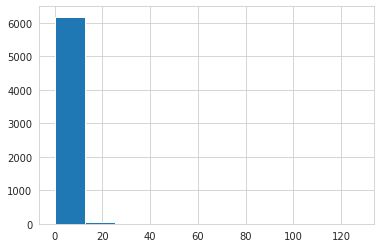

F_RecAmnt


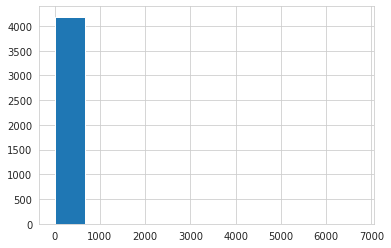

F_Dis_Iss


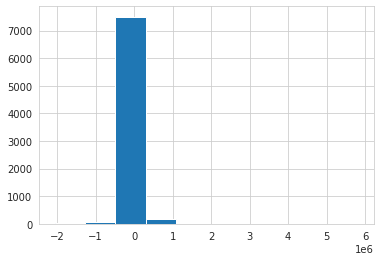

F_IssAmnt    F_RecAmnt     F_Dis_Iss
count  6228.000000  4202.000000  7.776000e+03
mean      1.257838    20.147465 -8.254999e+03
std       3.247782   179.741775  1.821069e+05
min       0.000000     0.000000 -2.065690e+06
25%       0.485400     2.576050 -3.926626e+04
50%       0.842300     4.512900  0.000000e+00
75%       1.255800     9.479350  2.068760e+04
max     127.404000  6728.216200  5.837571e+06

In [ ]:
for col in df[['F_IssAmnt', 'F_RecAmnt', 'F_Dis_Iss']]:
    print(col)
    plt.hist(df[col])
    plt.show()

df[['F_IssAmnt', 'F_RecAmnt', 'F_Dis_Iss']].describe()

F_mfo_IFor_30_90


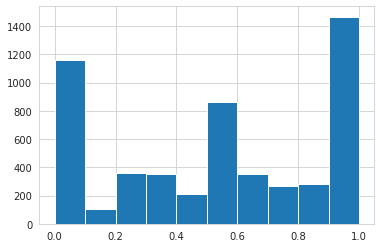

F_mfo_IFor_30_180


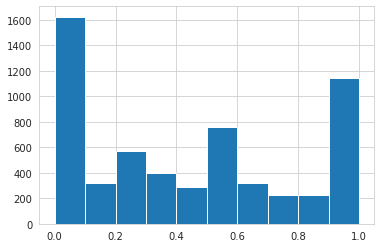

F_mfo_IFor_90_180


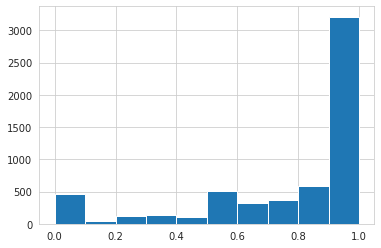

F_mfo_IFor_30_90  F_mfo_IFor_30_180  F_mfo_IFor_90_180
count       5425.000000        5880.000000        5880.000000
mean           0.533401           0.434184           0.781204
std            0.373555           0.369778           0.310523
min            0.000000           0.000000           0.000000
25%            0.200000           0.000000           0.666700
50%            0.500000           0.400000           1.000000
75%            1.000000           0.750000           1.000000
max            1.000000           1.000000           1.000000

In [ ]:
for col in df[['F_mfo_IFor_30_90', 'F_mfo_IFor_30_180', 'F_mfo_IFor_90_180']]:
    print(col)
    plt.hist(df[col])
    plt.show()

df[['F_mfo_IFor_30_90', 'F_mfo_IFor_30_180', 'F_mfo_IFor_90_180']].describe()

F_cny_IFor_30_90


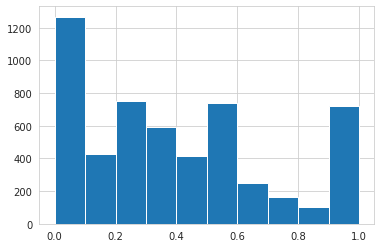

F_cny_IFor_30_180


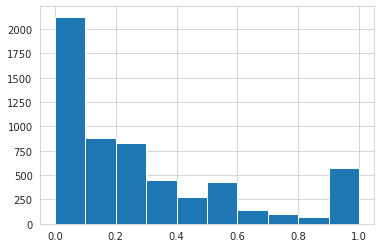

F_cny_IFor_90_180


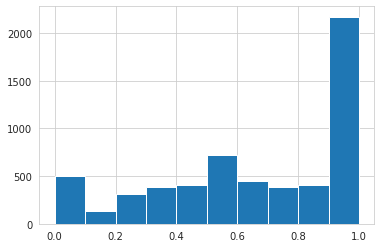

F_cny_IFor_30_90  F_cny_IFor_30_180  F_cny_IFor_90_180
count       5425.000000        5880.000000        5880.000000
mean           0.388751           0.282418           0.661270
std            0.324231           0.309469           0.328418
min            0.000000           0.000000           0.000000
25%            0.117600           0.000000           0.425675
50%            0.333300           0.183250           0.714300
75%            0.571400           0.428600           1.000000
max            1.000000           1.000000           1.000000

In [ ]:
for col in df[['F_cny_IFor_30_90', 'F_cny_IFor_30_180', 'F_cny_IFor_90_180']]:
    print(col)
    plt.hist(df[col])
    plt.show()

df[['F_cny_IFor_30_90', 'F_cny_IFor_30_180', 'F_cny_IFor_90_180']].describe()

F_NCrdPh_30_90


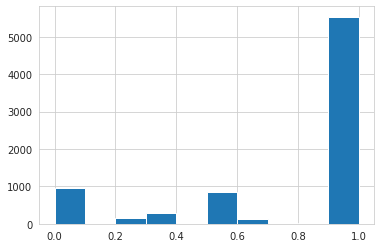

F_NCrdPh_30_360


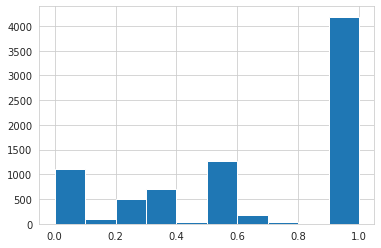

F_NCrdPh_90_360


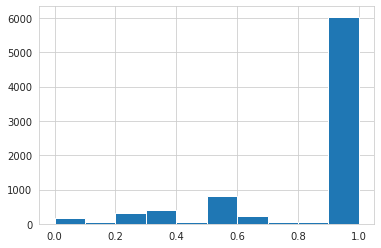

F_NCrdPh_30_90  F_NCrdPh_30_360  F_NCrdPh_90_360
count     7988.000000      8146.000000      8146.000000
mean         0.777184         0.659435         0.847999
std          0.360162         0.382903         0.275318
min          0.000000         0.000000         0.000000
25%          0.500000         0.333300         0.750000
50%          1.000000         1.000000         1.000000
75%          1.000000         1.000000         1.000000
max          1.000000         1.000000         1.000000

In [ ]:
for col in df[['F_NCrdPh_30_90', 'F_NCrdPh_30_360', 'F_NCrdPh_90_360']]:
    print(col)
    plt.hist(df[col])
    plt.show()

df[['F_NCrdPh_30_90', 'F_NCrdPh_30_360', 'F_NCrdPh_90_360']].describe()

F_NCrPh_cnt1


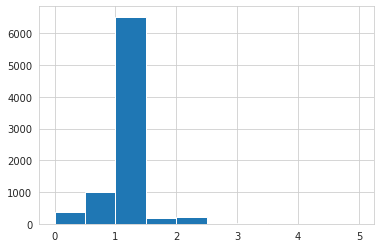

F_NCrPh_cnt2


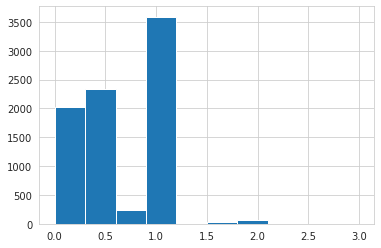

F_NCrPh_cnt1  F_NCrPh_cnt2
count   8311.000000   8311.000000
mean       0.958339      0.621536
std        0.310289      0.410218
min        0.000000      0.000000
25%        1.000000      0.333300
50%        1.000000      0.500000
75%        1.000000      1.000000
max        5.000000      3.000000

In [ ]:
for col in df[['F_NCrPh_cnt1', 'F_NCrPh_cnt2']]:
    print(col)
    plt.hist(df[col])
    plt.show()

df[['F_NCrPh_cnt1', 'F_NCrPh_cnt2']].describe()

F_NumCP_60_360


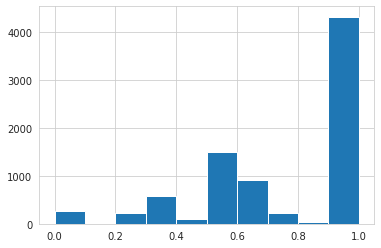

F_fTMFO_Pass


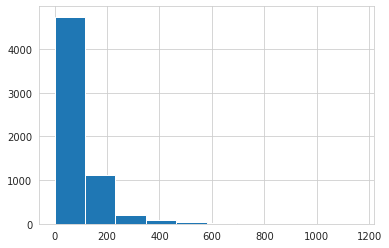

F_FDSA_Pass


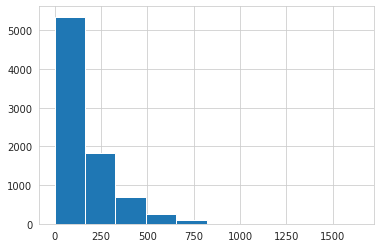

F_NumRDL_3_14


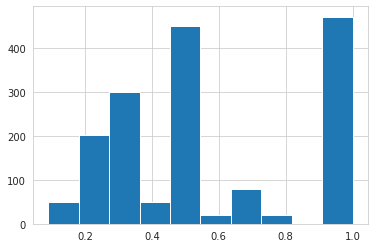

F_NumRDL_7_14


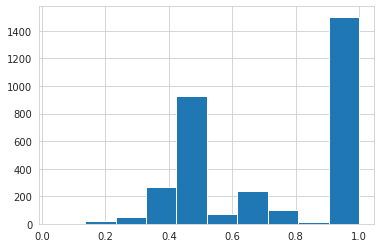

F_NumCP_60_360  F_fTMFO_Pass  F_FDSA_Pass  F_NumRDL_3_14  F_NumRDL_7_14
count     8169.000000   6228.000000  8220.000000    1641.000000    3184.000000
mean         0.755867     88.422186   160.420923       0.579713       0.740546
std          0.290043     98.511235   146.812527       0.292791       0.261882
min          0.000000      0.000000     0.000000       0.090900       0.040000
25%          0.500000     29.666700    58.000000       0.333300       0.500000
50%          1.000000     61.000000   116.000000       0.500000       0.750000
75%          1.000000    112.666700   207.874975       1.000000       1.000000
max          1.000000   1160.500000  1641.000000       1.000000       1.000000

In [ ]:
for col in df[['F_NumCP_60_360', 'F_fTMFO_Pass', 'F_FDSA_Pass', 'F_NumRDL_3_14', 'F_NumRDL_7_14']]:
    print(col)
    plt.hist(df[col])
    plt.show()

df[['F_NumCP_60_360', 'F_fTMFO_Pass', 'F_FDSA_Pass', 'F_NumRDL_3_14', 'F_NumRDL_7_14']].describe()

F_IpNet_180_365


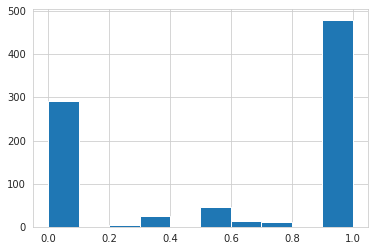

F_IpNeZ_30


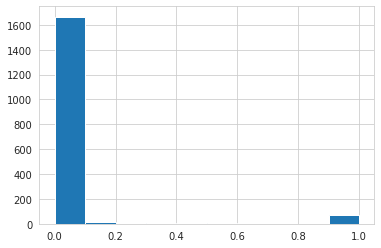

F_IpNeZ_180


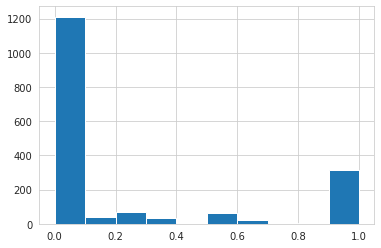

F_IpNeZ_365


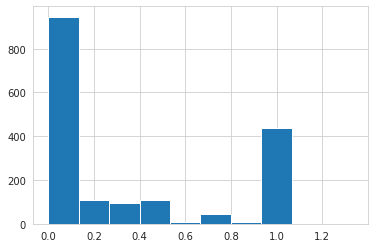

F_IpNet_180_365   F_IpNeZ_30  F_IpNeZ_180  F_IpNeZ_365
count       872.000000  1765.000000  1765.000000  1765.000000
mean          0.609539     0.044040     0.228115     0.337176
std           0.460575     0.197182     0.384821     0.420581
min           0.000000     0.000000     0.000000     0.000000
25%           0.000000     0.000000     0.000000     0.000000
50%           1.000000     0.000000     0.000000     0.000000
75%           1.000000     0.000000     0.333300     0.833300
max           1.000000     1.000000     1.000000     1.333300

In [ ]:
for col in df[['F_IpNet_180_365', 'F_IpNeZ_30', 'F_IpNeZ_180', 'F_IpNeZ_365']]:
    print(col)
    plt.hist(df[col])
    plt.show()

df[['F_IpNet_180_365', 'F_IpNeZ_30', 'F_IpNeZ_180', 'F_IpNeZ_365']].describe()

CntPhoneUser_SameApD


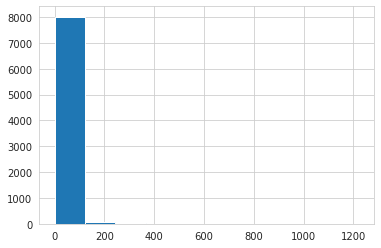

cntallcardsusers


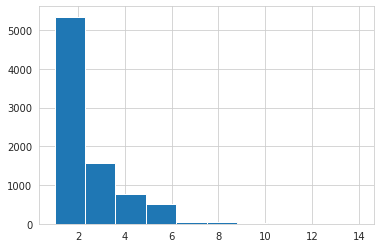

CntCardUser_SameAp


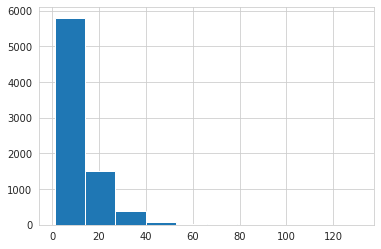

cntcardusers


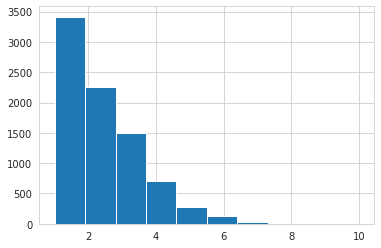

CntPhoneUser_SameApC


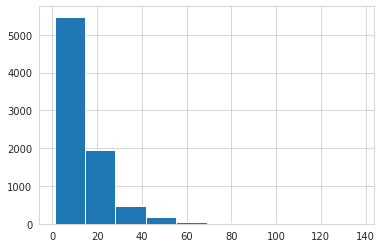

cntUserAplIP


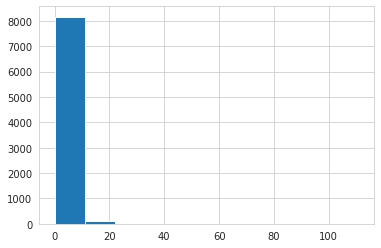

CntPhoneUser_SameApD  cntallcardsusers  CntCardUser_SameAp  \
count           8144.000000       8311.000000         7800.000000   
mean              20.732687          2.311635           10.194103   
std               42.356543          1.407940            9.932237   
min                0.000000          1.000000            1.000000   
25%                6.000000          1.000000            3.000000   
50%               11.000000          2.000000            7.000000   
75%               24.000000          3.000000           14.000000   
max             1222.000000         14.000000          131.000000   

       cntcardusers  CntPhoneUser_SameApC  cntUserAplIP  
count   8311.000000           8159.000000   8311.000000  
mean       2.120082             13.248192      0.973890  
std        1.253451             12.026623      3.359691  
min        1.000000              1.000000      0.000000  
25%        1.000000              5.000000      0.000000  
50%        2.000000             10.000000      0.000000  
75%        3.000000             17.000000      0.000000  
max       10.000000            137.000000    111.000000

In [ ]:
for col in df[['CntPhoneUser_SameApD', 'cntallcardsusers', 'CntCardUser_SameAp', 'cntcardusers',
              'CntPhoneUser_SameApC', 'cntUserAplIP']]:
    print(col)
    plt.hist(df[col])
    plt.show()

df[['CntPhoneUser_SameApD', 'cntallcardsusers', 'CntCardUser_SameAp', 'cntcardusers',
              'CntPhoneUser_SameApC', 'cntUserAplIP']].describe()

countIssuedFor180Days


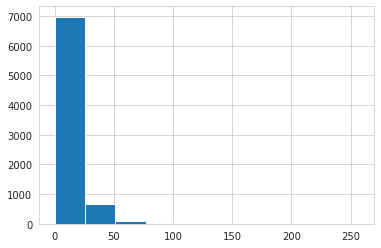

countIssuedFor30Days


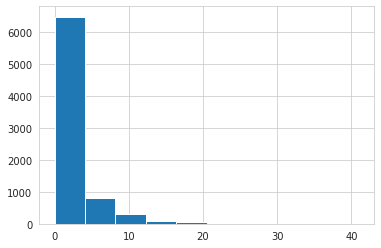

countIssuedFor90Days


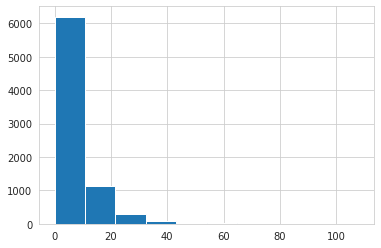

countIssuedFor180Days  countIssuedFor30Days  countIssuedFor90Days
count            7778.000000           7778.000000           7778.000000
mean               10.035870              2.243507              6.137310
std                14.190057              3.672577              8.690626
min                 0.000000              0.000000              0.000000
25%                 1.000000              0.000000              0.000000
50%                 5.000000              1.000000              3.000000
75%                14.000000              3.000000              9.000000
max               257.000000             41.000000            108.000000

In [ ]:
for col in df[['countIssuedFor180Days', 'countIssuedFor30Days', 'countIssuedFor90Days']]:
    print(col)
    plt.hist(df[col])
    plt.show()

df[['countIssuedFor180Days', 'countIssuedFor30Days', 'countIssuedFor90Days']].describe()

FinKartaScoreV1_group


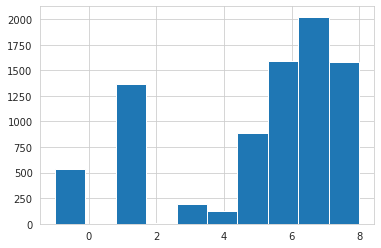

FinKartaScoreV1_rate


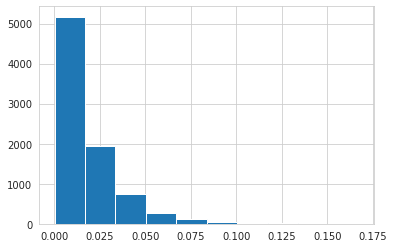

FinKartaScoreV2_rate


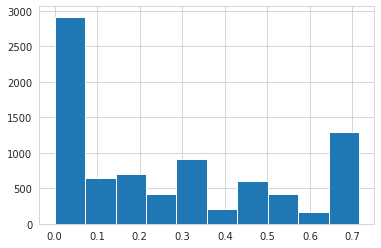

FinKartaScoreV1_group  FinKartaScoreV1_rate  FinKartaScoreV2_rate
count            8311.000000           8311.000000           8306.000000
mean                5.142943              0.015557              0.262502
std                 2.812688              0.018507              0.244093
min                -1.000000              0.000070              0.000000
25%                 3.000000              0.000445              0.021730
50%                 6.000000              0.011140              0.205540
75%                 7.000000              0.023800              0.466550
max                 8.000000              0.167420              0.715650

In [ ]:
for col in df[['FinKartaScoreV1_group', 'FinKartaScoreV1_rate', 'FinKartaScoreV2_rate']]:
    print(col)
    plt.hist(df[col])
    plt.show()

df[['FinKartaScoreV1_group', 'FinKartaScoreV1_rate', 'FinKartaScoreV2_rate']].describe()

lastDischargeAmount


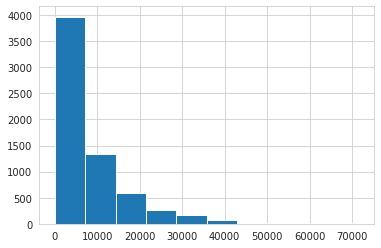

lastRecurrentAmount


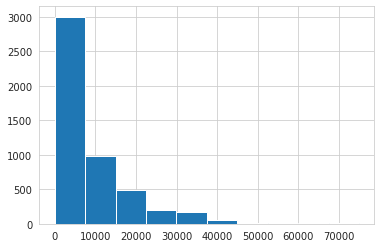

lastSuccessfulDischargeAmount


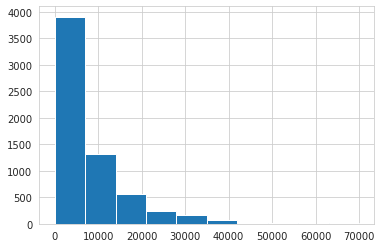

lastSuccessfulRecurrentAmount


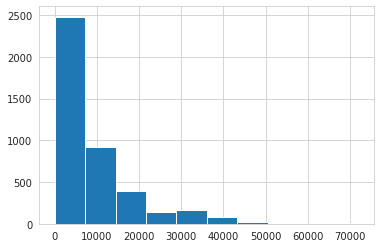

lastDischargeAmount  lastRecurrentAmount  \
count          6446.000000          4934.000000   
mean           8106.854651          8764.197639   
std            9147.244969          9633.174953   
min               1.000000             1.000000   
25%            2000.000000          2400.000000   
50%            4731.500000          5284.000000   
75%           10835.250000         11795.200000   
max           71648.530000         74928.620000   

       lastSuccessfulDischargeAmount  lastSuccessfulRecurrentAmount  
count                    6297.000000                    4202.000000  
mean                     7871.355833                    8980.983508  
std                      8634.231873                    9297.831033  
min                         1.000000                       1.000000  
25%                      2100.000000                    2926.000000  
50%                      4818.000000                    6000.000000  
75%                     10400.000000                   11500.000000  
max                     70000.000000                   72122.000000

In [ ]:
for col in df[['lastDischargeAmount', 'lastRecurrentAmount', 'lastSuccessfulDischargeAmount',
              'lastSuccessfulRecurrentAmount']]:
    print(col)
    plt.hist(df[col])
    plt.show()

df[['lastDischargeAmount', 'lastRecurrentAmount', 'lastSuccessfulDischargeAmount',
              'lastSuccessfulRecurrentAmount']].describe()

mfoCountFor180Days


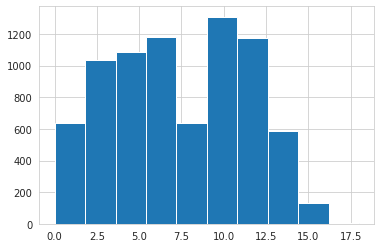

mfoCountFor30Days


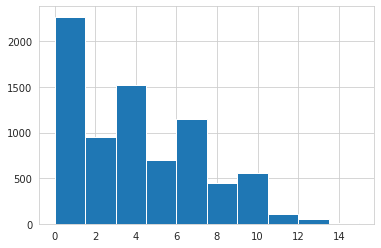

mfoCountFor90Days


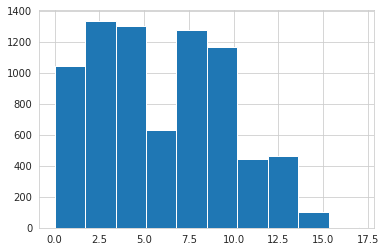

mfoIssuedFor180Days


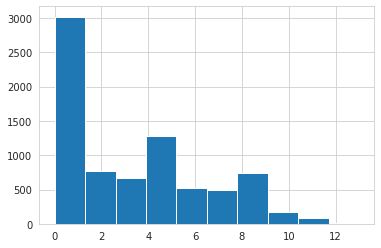

mfoIssuedFor30Days


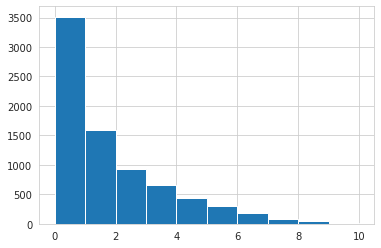

mfoIssuedFor90Days


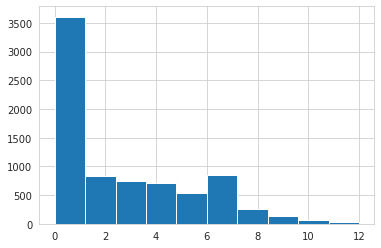

mfoCountFor180Days  mfoCountFor30Days  mfoCountFor90Days  \
count         7778.000000        7778.000000        7778.000000   
mean             7.276549           3.864104           5.982001   
std              3.916778           3.079658           3.672764   
min              0.000000           0.000000           0.000000   
25%              4.000000           1.000000           3.000000   
50%              7.000000           3.000000           6.000000   
75%             10.000000           6.000000           9.000000   
max             18.000000          15.000000          17.000000   

       mfoIssuedFor180Days  mfoIssuedFor30Days  mfoIssuedFor90Days  
count          7778.000000         7778.000000         7778.000000  
mean              3.364104            1.408974            2.626125  
std               3.095307            1.822172            2.670032  
min               0.000000            0.000000            0.000000  
25%               1.000000            0.000000            0.000000  
50%               3.000000            1.000000            2.000000  
75%               6.000000            2.000000            4.000000  
max              13.000000           10.000000           12.000000

In [ ]:
for col in df[['mfoCountFor180Days', 'mfoCountFor30Days', 'mfoCountFor90Days',
              'mfoIssuedFor180Days', 'mfoIssuedFor30Days', 'mfoIssuedFor90Days']]:
    print(col)
    plt.hist(df[col])
    plt.show()

df[['mfoCountFor180Days', 'mfoCountFor30Days', 'mfoCountFor90Days',
              'mfoIssuedFor180Days', 'mfoIssuedFor30Days', 'mfoIssuedFor90Days']].describe()

Num_cellph_SP_120


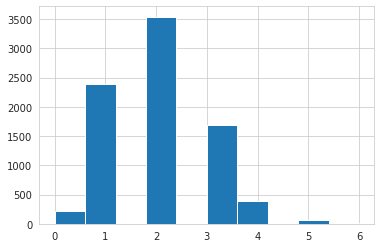

Num_cellph_SP_180


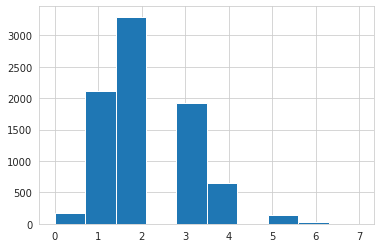

Num_cellph_SP_30


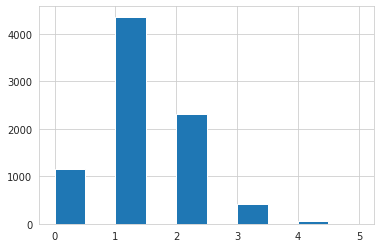

Num_cellph_SP_360


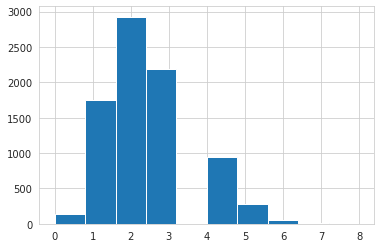

Num_cellph_SP_60


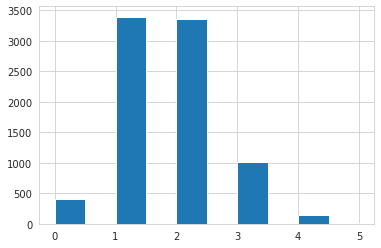

Num_cellph_SP_90


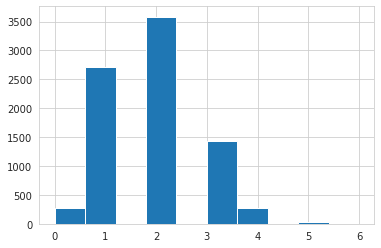

Num_cellph_SP_all


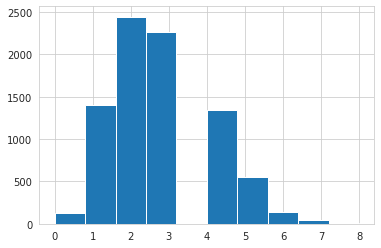

Num_cellph_SP_120  Num_cellph_SP_180  Num_cellph_SP_30  \
count        8311.000000        8311.000000       8311.000000   
mean            1.982914           2.151005          1.262905   
std             0.933504           1.027509          0.783751   
min             0.000000           0.000000          0.000000   
25%             1.000000           1.000000          1.000000   
50%             2.000000           2.000000          1.000000   
75%             3.000000           3.000000          2.000000   
max             6.000000           7.000000          5.000000   

       Num_cellph_SP_360  Num_cellph_SP_60  Num_cellph_SP_90  \
count        8311.000000       8311.000000       8311.000000   
mean            2.381422          1.654675          1.854650   
std             1.142384          0.828415          0.882537   
min             0.000000          0.000000          0.000000   
25%             2.000000          1.000000          1.000000   
50%             2.000000          2.000000          2.000000   
75%             3.000000          2.000000          2.000000   
max             8.000000          5.000000          6.000000   

       Num_cellph_SP_all  
count        8311.000000  
mean            2.695464  
std             1.302234  
min             0.000000  
25%             2.000000  
50%             3.000000  
75%             4.000000  
max             8.000000

In [ ]:
for col in df[['Num_cellph_SP_120', 'Num_cellph_SP_180', 'Num_cellph_SP_30',
              'Num_cellph_SP_360', 'Num_cellph_SP_60', 'Num_cellph_SP_90',
              'Num_cellph_SP_all']]:
    print(col)
    plt.hist(df[col])
    plt.show()

df[['Num_cellph_SP_120', 'Num_cellph_SP_180', 'Num_cellph_SP_30',
              'Num_cellph_SP_360', 'Num_cellph_SP_60', 'Num_cellph_SP_90',
              'Num_cellph_SP_all']].describe()

NumCrdPhone_120


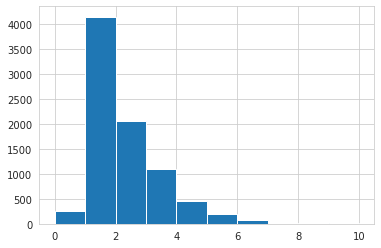

NumCrdPhone_180


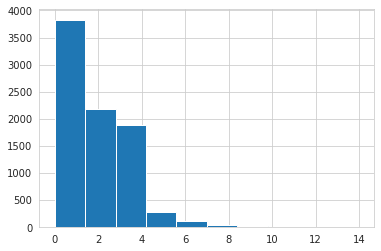

NumCrdPhone_30


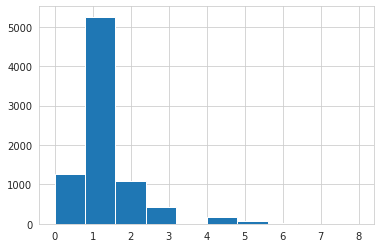

NumCrdPhone_360


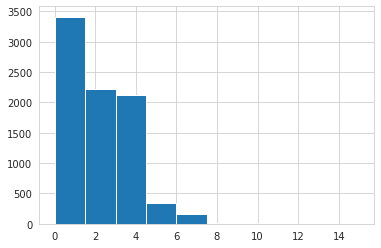

NumCrdPhone_60


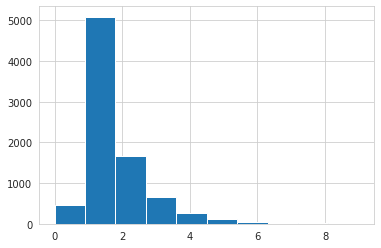

NumCrdPhone_90


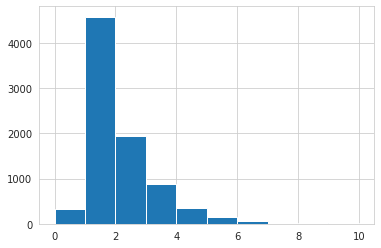

NumCrdPhone_all


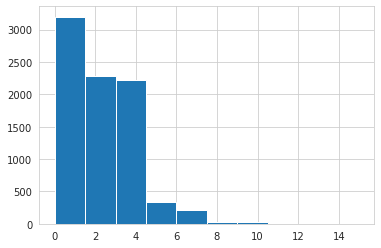

NumCrdPhone_120  NumCrdPhone_180  NumCrdPhone_30  NumCrdPhone_360  \
count      8311.000000      8311.000000     8311.000000      8311.000000   
mean          1.811575         1.995789        1.192997         2.146432   
std           1.203731         1.305586        0.936005         1.381012   
min           0.000000         0.000000        0.000000         0.000000   
25%           1.000000         1.000000        1.000000         1.000000   
50%           1.000000         2.000000        1.000000         2.000000   
75%           2.000000         3.000000        1.000000         3.000000   
max          10.000000        14.000000        8.000000        15.000000   

       NumCrdPhone_60  NumCrdPhone_90  NumCrdPhone_all  
count     8311.000000     8311.000000      8311.000000  
mean         1.484779        1.663458         2.221754  
std          1.014802        1.119443         1.422710  
min          0.000000        0.000000         0.000000  
25%          1.000000        1.000000         1.000000  
50%          1.000000        1.000000         2.000000  
75%          2.000000        2.000000         3.000000  
max          9.000000       10.000000        15.000000

In [ ]:
for col in df[['NumCrdPhone_120', 'NumCrdPhone_180', 'NumCrdPhone_30',
              'NumCrdPhone_360', 'NumCrdPhone_60', 'NumCrdPhone_90',
              'NumCrdPhone_all']]:
    print(col)
    plt.hist(df[col])
    plt.show()

df[['NumCrdPhone_120', 'NumCrdPhone_180', 'NumCrdPhone_30',
              'NumCrdPhone_360', 'NumCrdPhone_60', 'NumCrdPhone_90',
              'NumCrdPhone_all']].describe()

NumR_DIL_120


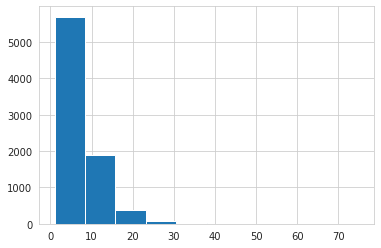

NumR_DIL_14


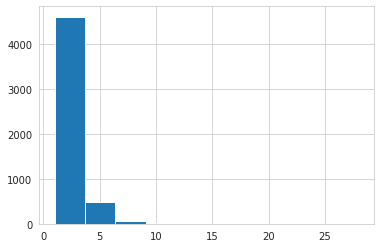

NumR_DIL_180


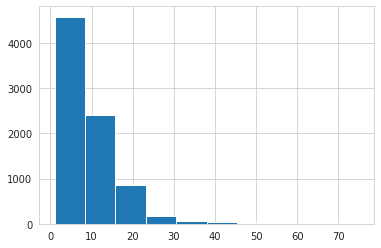

NumR_DIL_3


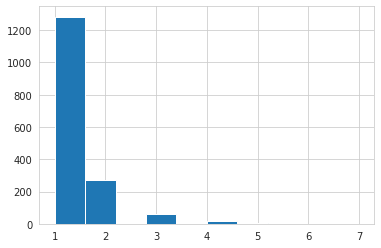

NumR_DIL_30


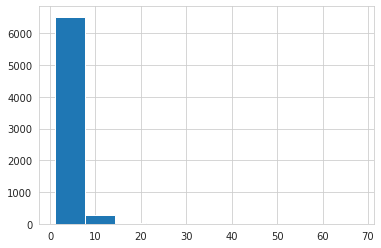

NumR_DIL_360


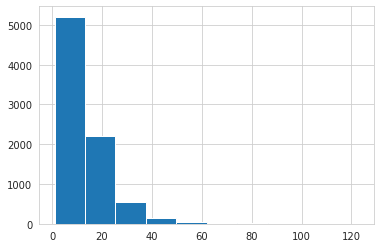

NumR_DIL_60


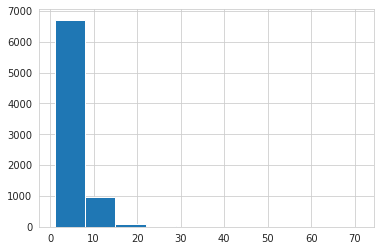

NumR_DIL_7


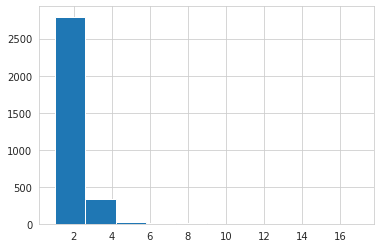

NumR_DIL_90


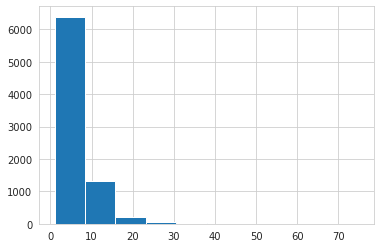

NumR_DIL_all


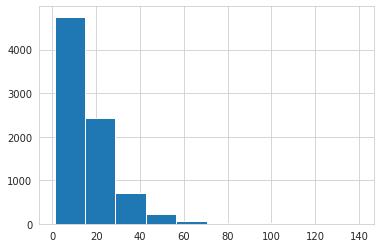

NumR_DIL_120  NumR_DIL_14  NumR_DIL_180   NumR_DIL_3  NumR_DIL_30  \
count   8091.000000  5169.000000   8146.000000  1641.000000   6814.00000   
mean       7.072921     1.911975      9.154063     1.291895      2.85295   
std        5.300010     1.497608      6.925736     0.643534      2.54986   
min        1.000000     1.000000      1.000000     1.000000      1.00000   
25%        3.000000     1.000000      4.000000     1.000000      1.00000   
50%        6.000000     1.000000      8.000000     1.000000      2.00000   
75%        9.000000     2.000000     12.000000     1.000000      4.00000   
max       75.000000    28.000000     75.000000     7.000000     68.00000   

       NumR_DIL_360  NumR_DIL_60   NumR_DIL_7  NumR_DIL_90  NumR_DIL_all  
count   8201.000000  7812.000000  3184.000000  7989.000000   8235.000000  
mean      12.897695     4.453661     1.528580     5.859807     15.741469  
std       10.171248     3.544949     1.002886     4.447560     12.822041  
min        1.000000     1.000000     1.000000     1.000000      1.000000  
25%        6.000000     2.000000     1.000000     3.000000      7.000000  
50%       11.000000     4.000000     1.000000     5.000000     13.000000  
75%       17.000000     6.000000     2.000000     8.000000     21.000000  
max      123.000000    71.000000    17.000000    75.000000    140.000000

In [ ]:
for col in df[['NumR_DIL_120', 'NumR_DIL_14', 'NumR_DIL_180',
              'NumR_DIL_3', 'NumR_DIL_30', 'NumR_DIL_360',
              'NumR_DIL_60', 'NumR_DIL_7', 'NumR_DIL_90', 'NumR_DIL_all']]:
    print(col)
    plt.hist(df[col])
    plt.show()

df[['NumR_DIL_120', 'NumR_DIL_14', 'NumR_DIL_180',
    'NumR_DIL_3', 'NumR_DIL_30', 'NumR_DIL_360',
    'NumR_DIL_60', 'NumR_DIL_7', 'NumR_DIL_90', 'NumR_DIL_all']].describe()

totalDischargeAmount


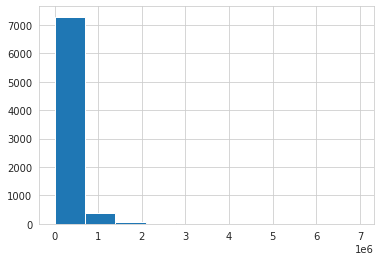

totalIssuedAmount


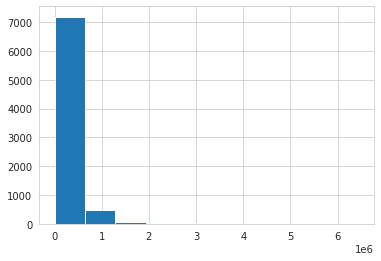

totalRecurrentAmount


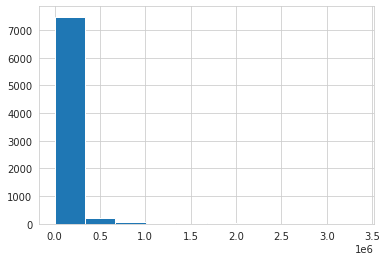

totalDischargeAmount  totalIssuedAmount  totalRecurrentAmount
count          7.776000e+03       7.776000e+03          7.776000e+03
mean           1.904462e+05       1.987012e+05          5.597536e+04
std            3.521520e+05       3.629409e+05          1.666695e+05
min            0.000000e+00       0.000000e+00          0.000000e+00
25%            7.164570e+03       9.892530e+03          0.000000e+00
50%            6.565510e+04       7.765300e+04          3.300000e+03
75%            2.268119e+05       2.371415e+05          3.996500e+04
max            6.973071e+06       6.452983e+06          3.354598e+06

In [ ]:
for col in df[['totalDischargeAmount', 'totalIssuedAmount', 'totalRecurrentAmount']]:
    print(col)
    plt.hist(df[col])
    plt.show()

df[['totalDischargeAmount', 'totalIssuedAmount', 'totalRecurrentAmount']].describe()

Признаки, в которых остались пропуски, аналитические, те рассчитанные из параметров людей и их кредитных историй. Поскольку самое частое значение среди них - это 0, заменим пропуски на 0.

In [ ]:
df = df.fillna(0)

In [ ]:
df.isna().sum().values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0])

# Оценка корреляции и значимости числовых переменных

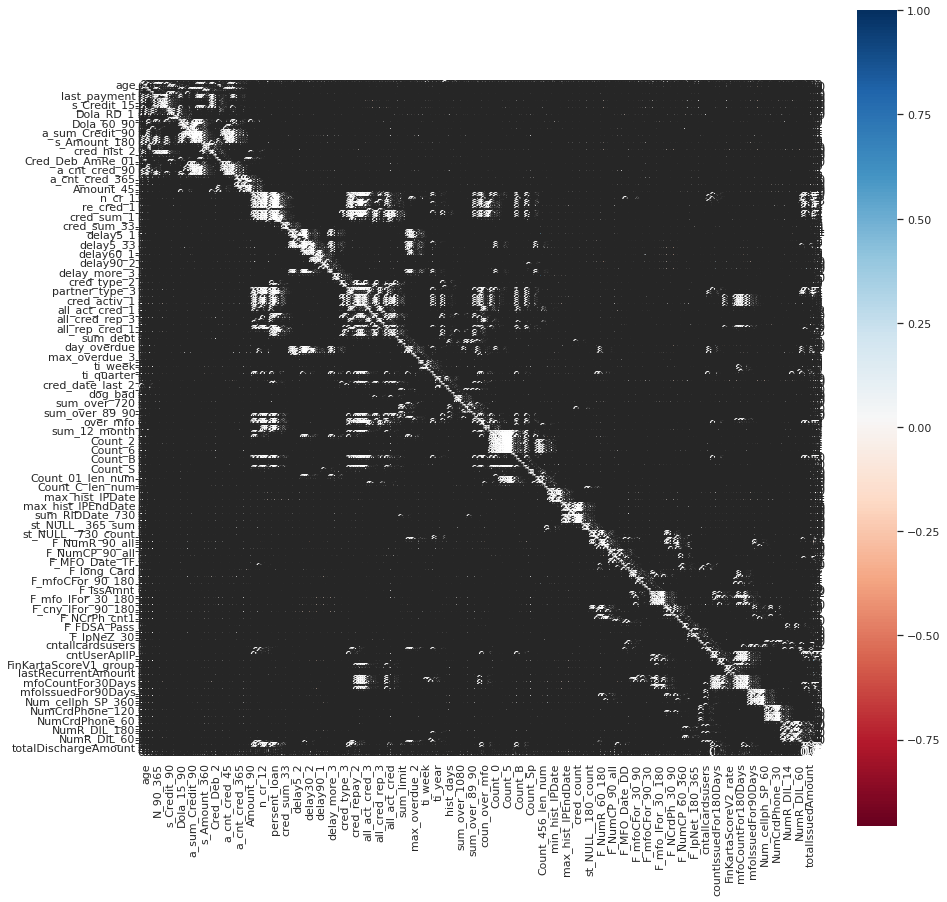

In [ ]:
corr_num = df[['age', 'N_Loans', 'perc_amount', 'N_365', 'last_payment', 'N_90_365', 's_Amount', 's_Credit_befo_RD', 's_Credit_15',
 's_Credit_30', 's_Credit_90', 's_Credit_90_RD', 'Dola_RD_1', 'Dola_RD_2', 'Dola_RD_3', 'Dola_15_90', 'Dola_60_90', 'a_sum_Credit_700',
 'a_sum_Credit_365', 'a_sum_Credit_180', 'a_sum_Credit_90', 's_Amount_30', 's_Amount_60', 's_Amount_90', 's_Amount_180', 's_Amount_360',
 's_Amount_500', 'cred_hist_1', 'cred_hist_2', 'cred_hist_3', 'Cred_Deb_2', 'Cred_Deb_AmRe', 'Cred_Deb_AmRe_01', 'Cred_Deb_AmRe_1',
 'Cred_Deb_Deb', 'a_cnt_cred_45', 'a_cnt_cred_90', 'a_cnt_cred_135', 'a_cnt_cred_180', 'a_cnt_cred_700', 'a_cnt_cred_365',
 'miAmount_45', 'miAmount_90', 'miAmount_180', 'Amount_45', 'Amount_90', 'Amount_180', 'Amount_365','n_cr_1', 'n_cr_2',
 'n_cr_12', 'n_cr_3', 're_cred_1', 're_cred_2', 're_cred_3', 'persent_loan', 'cred_sum_1', 'cred_sum_2', 'cred_sum_3',
 'cred_sum_22', 'cred_sum_33', 'cred_dura_1', 'cred_dura_2', 'cred_dura_3', 'delay5_1', 'delay5_2', 'delay5_3', 'delay5_22',
 'delay5_33', 'delay30_1', 'delay30_2', 'delay30_3', 'delay60_1', 'delay60_2', 'delay60_3', 'delay90_1', 'delay90_2', 'delay90_3',
 'delay_more_1', 'delay_more_2', 'delay_more_3', 'delay5_30_365', 'delay5_30_60_365','cred_type_1', 'cred_type_2', 'cred_type_3',
 'partner_type_1', 'partner_type_2', 'partner_type_3', 'cred_repay_1', 'cred_repay_2', 'cred_repay_3', 'cred_activ_1',
 'cred_activ_2', 'cred_activ_3', 'all_act_cred_3', 'all_act_cred_1', 'all_act_cred_3_1', 'all_act_cred_2', 'all_act_3_1_d',
 'all_cred_rep_3', 'all_cred_rep_1', 'all_cred_rep_13', 'all_cred_rep_11', 'all_rep_cred_1', 'all_act_cred', 'all_act_cred_s','test_1',
 'sum_debt', 'sum_debt_1', 'sum_limit', 'sum_overdue', 'day_overdue', 'max_overdue', 'max_overdue_1',
 'max_overdue_2', 'max_overdue_3', 'prolong', 'ti_hour', 'ti_day', 'ti_week', 'ti_week_all', 'ti_month', 'ti_month_all', 'ti_quarter',
 'ti_year', 'cred_date_last', 'cred_date_last_1', 'cred_date_last_2', 'sum_debt_last', 'hist_days', 'hist_days_m', 'dog_bad',
 'dog_bad_360', 'dog_bad_1080', 'sum_over_1080', 'sum_over_720', 'sum_over_360', 'sum_over_1_89', 'sum_over_90', 'sum_over_89_90',
 'avg_over_1_90', 'sum_over_9000', 'sum_mfo', 'over_mfo', 'сoun_over_mfo', 'сount_cls_mfo', 'p_cls_mfo_365', 'sum_12_month',
 'avg_12_month','Count_0', 'Count_1', 'Count_2', 'Count_3', 'Count_4', 'Count_5', 'Count_6', 'Count_7', 'Count_8', 'Count_9',
 'Count_B', 'Count_C', 'Count_I', 'Count_R', 'Count_S', 'Count_Sp', 'Count_W', 'Count_0_len_num',
 'Count_01_len_num', 'Count_12_len_num', 'Count_456_len_num', 'Count_5B_len_num', 'Count_C_len_num', 'Count_Sp_len_num',
 'N_record_IP', 'min_hist_IPDate', 'max_hist_IPDate', 'min_hist_RIDDate', 'max_hist_RIDDate', 'min_hist_IPEndDate',
 'max_hist_IPEndDate', 'max_Summa', 'sum_RIDDate_365', 'sum_RIDDate_180', 'sum_RIDDate_730', 'cred_count', 'cred_summ',
 'st_NULL__180_sum', 'st_NULL__365_sum', 'st_NULL__730_sum', 'st_NULL__180_count', 'st_NULL__365_count', 'st_NULL__730_count',
 'F_NumR_30_90', 'F_NumR_30_180', 'F_NumR_60_180', 'F_NumR_90_all', 'F_NumCP_30_90', 'F_NumCP_30_180', 'F_NumCP_60_180',
 'F_NumCP_90_all', 'F_MFO_Date_lT', 'F_MFO_Date_SD', 'F_MFO_Date_SR', 'F_MFO_Date_TF', 'F_MFO_Date_DD', 'F_MFO_Date_RD',
 'F_long_PhNum', 'F_long_Card', 'F_long_SA', 'F_mfoCFor_30_90', 'F_mfoCFor_30_180', 'F_mfoCFor_90_180', 'F_mfoCFor_180_30',
 'F_mfoCFor_180_90', 'F_mfoCFor_90_30', 'F_IssAmnt', 'F_RecAmnt', 'F_Dis_Iss', 'F_mfo_IFor_30_90', 'F_mfo_IFor_30_180',
 'F_mfo_IFor_90_180', 'F_cny_IFor_30_90', 'F_cny_IFor_30_180', 'F_cny_IFor_90_180', 'F_NCrdPh_30_90', 'F_NCrdPh_30_360',
 'F_NCrdPh_90_360','F_NCrPh_cnt1', 'F_NCrPh_cnt2', 'F_NumCP_60_360', 'F_fTMFO_Pass', 'F_FDSA_Pass', 'F_NumRDL_3_14',
 'F_NumRDL_7_14', 'F_IpNet_180_365', 'F_IpNeZ_30', 'F_IpNeZ_180', 'F_IpNeZ_365', 'CntPhoneUser_SameApD', 'cntallcardsusers',
 'CntCardUser_SameAp', 'cntcardusers', 'CntPhoneUser_SameApC', 'cntUserAplIP', 'countIssuedFor180Days', 'countIssuedFor30Days',
 'countIssuedFor90Days', 'FinKartaScoreV1_group', 'FinKartaScoreV1_rate', 'FinKartaScoreV2_rate', 'lastDischargeAmount',
 'lastRecurrentAmount', 'lastSuccessfulDischargeAmount', 'lastSuccessfulRecurrentAmount', 'mfoCountFor180Days', 'mfoCountFor30Days',
 'mfoCountFor90Days', 'mfoIssuedFor180Days', 'mfoIssuedFor30Days', 'mfoIssuedFor90Days','Num_cellph_SP_120', 'Num_cellph_SP_180',
 'Num_cellph_SP_30', 'Num_cellph_SP_360', 'Num_cellph_SP_60', 'Num_cellph_SP_90', 'Num_cellph_SP_all', 'NumCrdPhone_120',
 'NumCrdPhone_180', 'NumCrdPhone_30', 'NumCrdPhone_360', 'NumCrdPhone_60', 'NumCrdPhone_90', 'NumCrdPhone_all', 
 'NumR_DIL_14', 'NumR_DIL_180', 'NumR_DIL_3', 'NumR_DIL_30', 'NumR_DIL_360', 'NumR_DIL_60', 'NumR_DIL_7', 'NumR_DIL_90', 'NumR_DIL_all',
 'totalDischargeAmount', 'totalIssuedAmount', 'totalRecurrentAmount']]
 
sns.set(font_scale = 1)
plt.subplots(figsize = (15,15))
sns.heatmap(corr_num.corr(), square = True,
           annot = True, fmt = ".1f", linewidths = 0.1, cmap = 'RdBu')

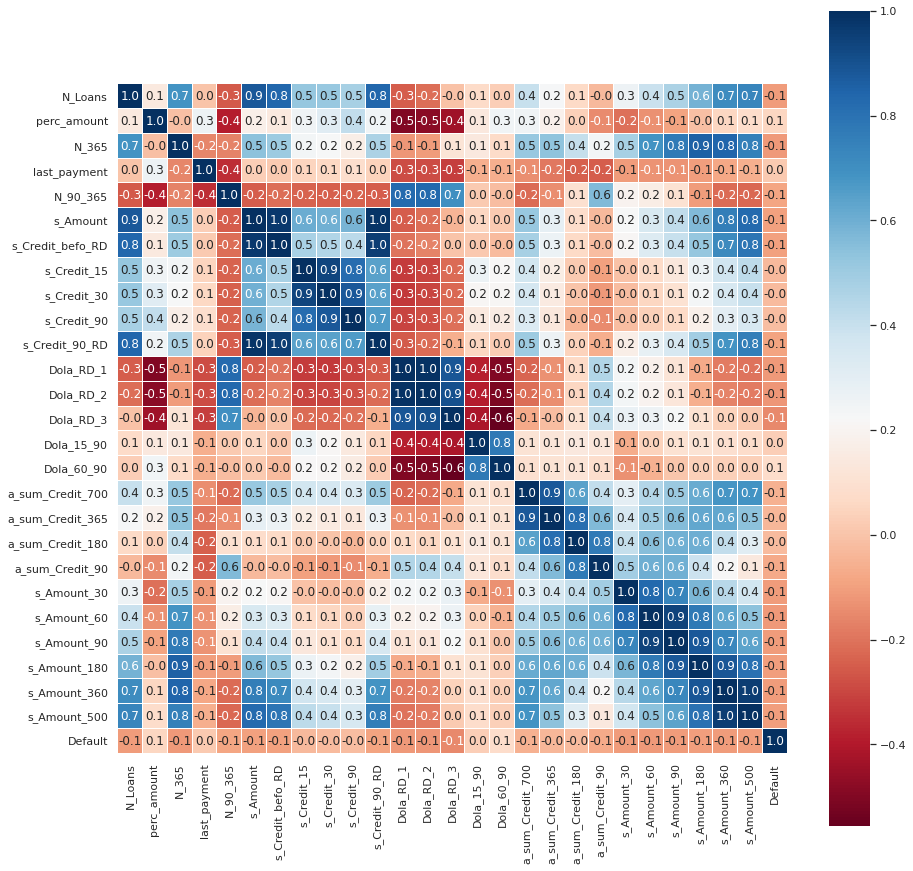

In [ ]:
corr_num = df[['N_Loans', 'perc_amount', 'N_365', 'last_payment', 'N_90_365', 's_Amount', 's_Credit_befo_RD', 's_Credit_15',
 's_Credit_30', 's_Credit_90', 's_Credit_90_RD', 'Dola_RD_1', 'Dola_RD_2', 'Dola_RD_3', 'Dola_15_90', 'Dola_60_90', 'a_sum_Credit_700',
 'a_sum_Credit_365', 'a_sum_Credit_180', 'a_sum_Credit_90', 's_Amount_30', 's_Amount_60', 's_Amount_90', 's_Amount_180', 's_Amount_360',
 's_Amount_500', 'Default']] 
sns.set(font_scale = 1)
plt.subplots(figsize = (15,15))
sns.heatmap(corr_num.corr(), square = True,
           annot = True, fmt = ".1f", linewidths = 0.1, cmap = 'RdBu')

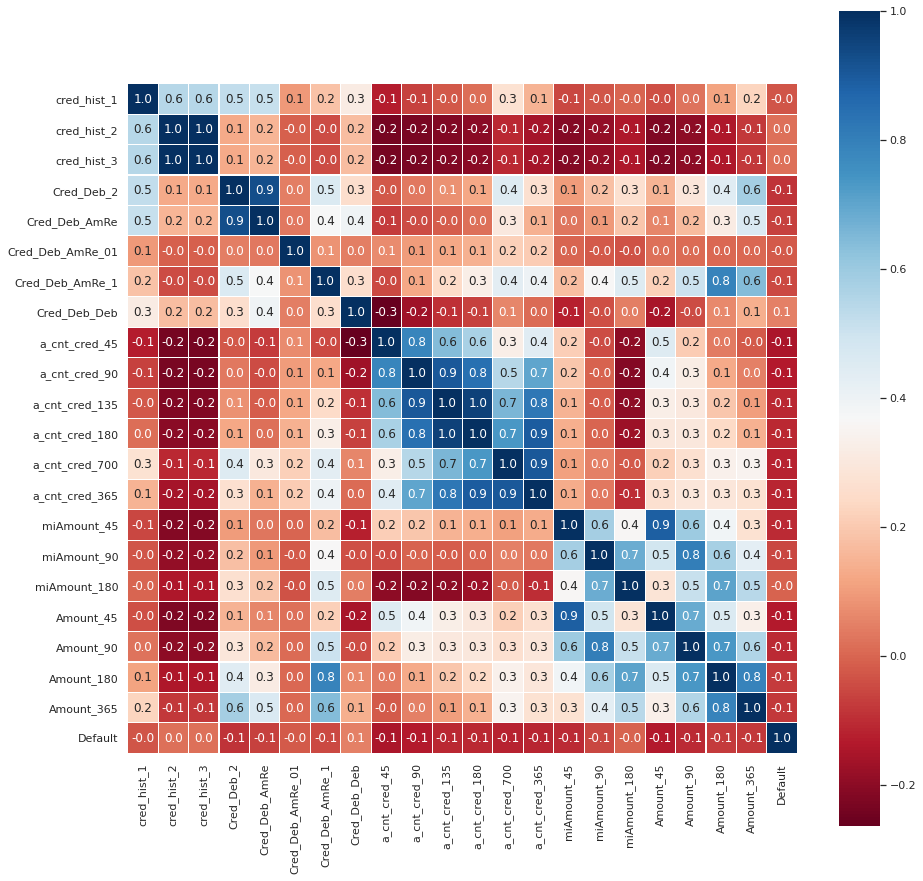

In [ ]:
corr_num_1 = df[['cred_hist_1', 'cred_hist_2', 'cred_hist_3', 'Cred_Deb_2', 'Cred_Deb_AmRe', 'Cred_Deb_AmRe_01', 'Cred_Deb_AmRe_1',
 'Cred_Deb_Deb', 'a_cnt_cred_45', 'a_cnt_cred_90', 'a_cnt_cred_135', 'a_cnt_cred_180', 'a_cnt_cred_700', 'a_cnt_cred_365',
 'miAmount_45', 'miAmount_90', 'miAmount_180', 'Amount_45', 'Amount_90', 'Amount_180', 'Amount_365', 'Default']] 
sns.set(font_scale = 1)
plt.subplots(figsize = (15,15))
sns.heatmap(corr_num_1.corr(), square = True,
           annot = True, fmt = ".1f", linewidths = 0.1, cmap = 'RdBu')

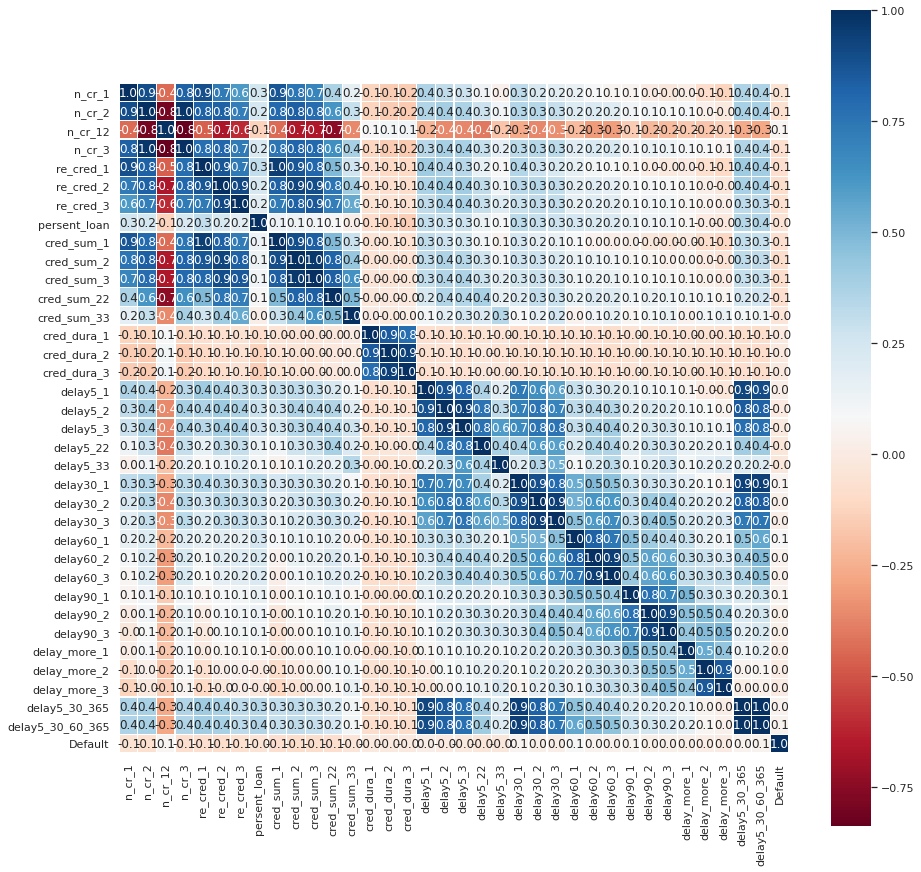

In [ ]:
corr_num1 = df[['n_cr_1', 'n_cr_2',
 'n_cr_12', 'n_cr_3', 're_cred_1', 're_cred_2', 're_cred_3', 'persent_loan', 'cred_sum_1', 'cred_sum_2', 'cred_sum_3',
 'cred_sum_22', 'cred_sum_33', 'cred_dura_1', 'cred_dura_2', 'cred_dura_3', 'delay5_1', 'delay5_2', 'delay5_3', 'delay5_22',
 'delay5_33', 'delay30_1', 'delay30_2', 'delay30_3', 'delay60_1', 'delay60_2', 'delay60_3', 'delay90_1', 'delay90_2', 'delay90_3',
 'delay_more_1', 'delay_more_2', 'delay_more_3', 'delay5_30_365', 'delay5_30_60_365', 'Default']] 
sns.set(font_scale = 1)
plt.subplots(figsize = (15,15))
sns.heatmap(corr_num1.corr(), square = True,
           annot = True, fmt = ".1f", linewidths = 0.1, cmap = 'RdBu')

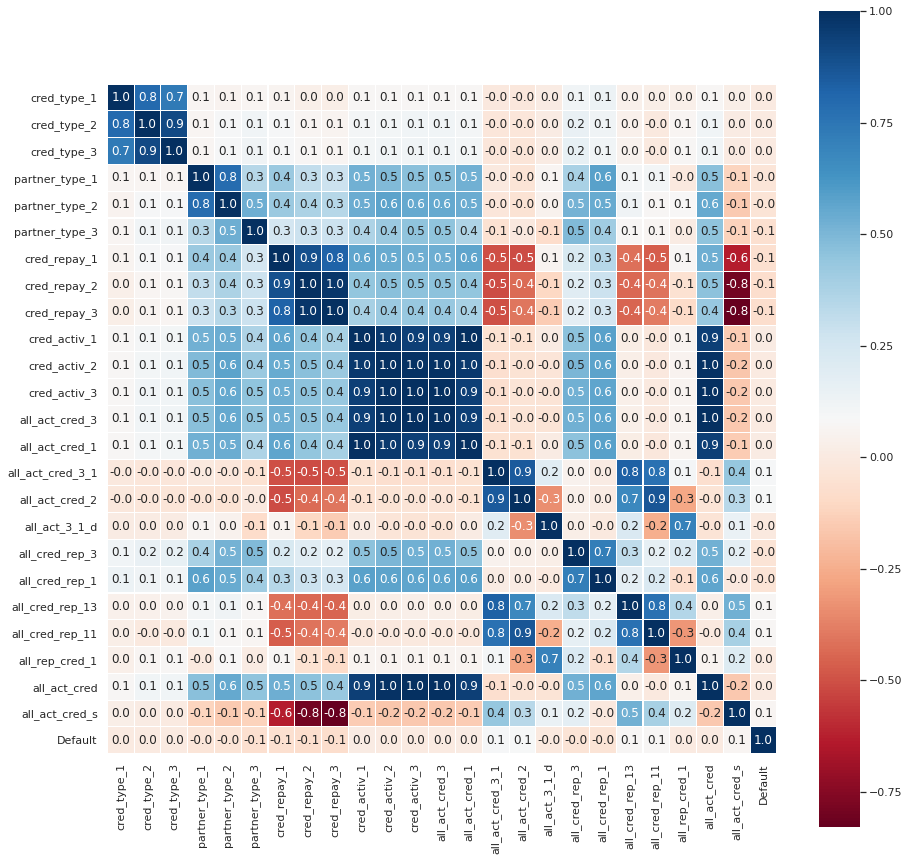

In [ ]:
corr_num1_2 = df[[ 'cred_type_1', 'cred_type_2', 'cred_type_3',
 'partner_type_1', 'partner_type_2', 'partner_type_3', 'cred_repay_1', 'cred_repay_2', 'cred_repay_3', 'cred_activ_1',
 'cred_activ_2', 'cred_activ_3', 'all_act_cred_3', 'all_act_cred_1', 'all_act_cred_3_1', 'all_act_cred_2', 'all_act_3_1_d',
 'all_cred_rep_3', 'all_cred_rep_1', 'all_cred_rep_13', 'all_cred_rep_11', 'all_rep_cred_1', 'all_act_cred', 'all_act_cred_s',
 'Default']] 
sns.set(font_scale = 1)
plt.subplots(figsize = (15,15))
sns.heatmap(corr_num1_2.corr(), square = True,
           annot = True, fmt = ".1f", linewidths = 0.1, cmap = 'RdBu')

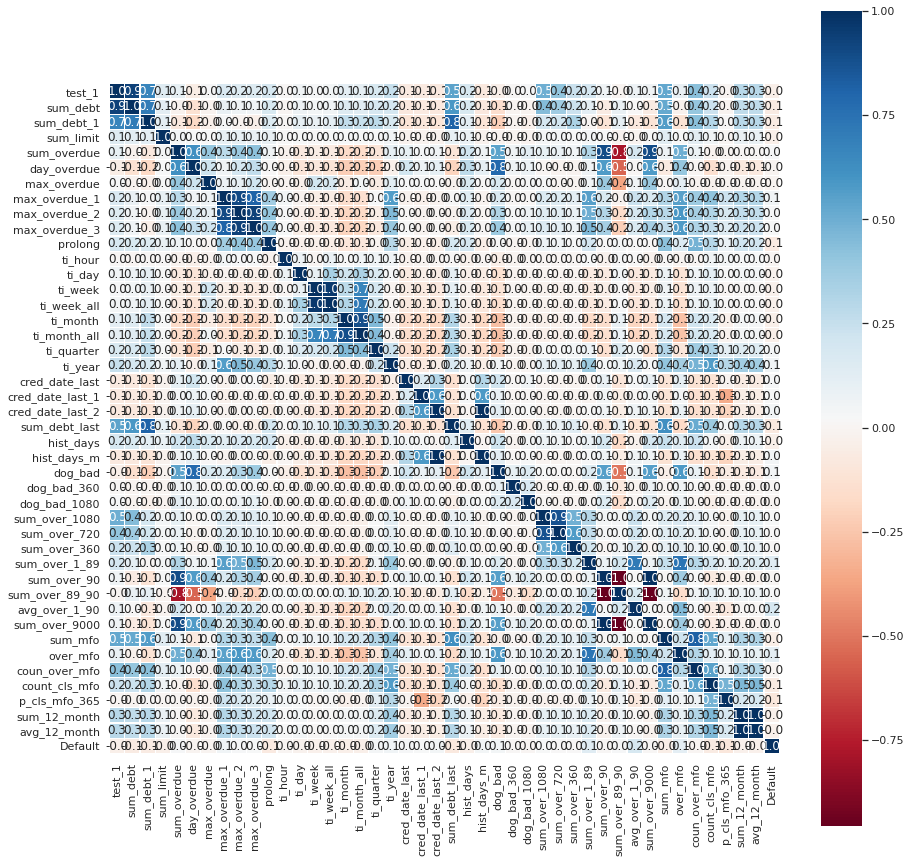

In [ ]:
corr_num2 = df[['test_1', 'sum_debt', 'sum_debt_1', 'sum_limit', 'sum_overdue', 'day_overdue', 'max_overdue', 'max_overdue_1',
 'max_overdue_2', 'max_overdue_3', 'prolong', 'ti_hour', 'ti_day', 'ti_week', 'ti_week_all', 'ti_month', 'ti_month_all', 'ti_quarter',
 'ti_year', 'cred_date_last', 'cred_date_last_1', 'cred_date_last_2', 'sum_debt_last', 'hist_days', 'hist_days_m', 'dog_bad',
 'dog_bad_360', 'dog_bad_1080', 'sum_over_1080', 'sum_over_720', 'sum_over_360', 'sum_over_1_89', 'sum_over_90', 'sum_over_89_90',
 'avg_over_1_90', 'sum_over_9000', 'sum_mfo', 'over_mfo', 'сoun_over_mfo', 'сount_cls_mfo', 'p_cls_mfo_365', 'sum_12_month',
 'avg_12_month', 'Default']] 
sns.set(font_scale = 1)
plt.subplots(figsize = (15,15))
sns.heatmap(corr_num2.corr(), square = True,
           annot = True, fmt = ".1f", linewidths = 0.1, cmap = 'RdBu')

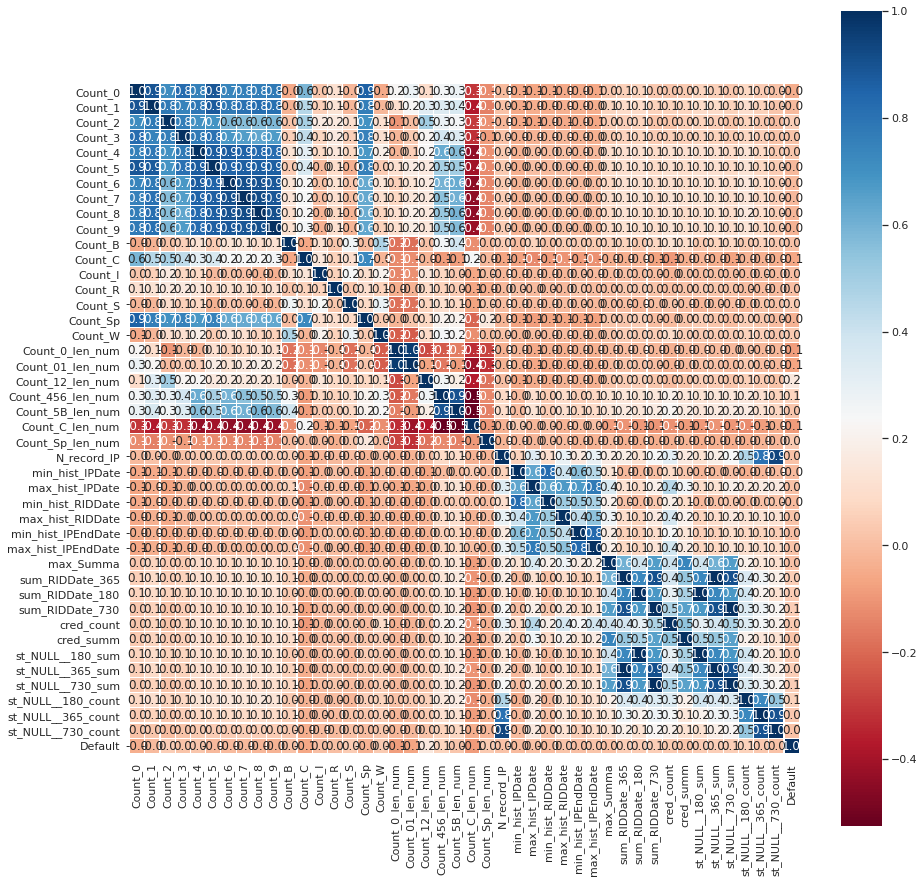

In [ ]:
corr_num3 = df[['Count_0', 'Count_1', 'Count_2', 'Count_3', 'Count_4', 'Count_5', 'Count_6', 'Count_7', 'Count_8', 'Count_9',
 'Count_B', 'Count_C', 'Count_I', 'Count_R', 'Count_S', 'Count_Sp', 'Count_W', 'Count_0_len_num',
 'Count_01_len_num', 'Count_12_len_num', 'Count_456_len_num', 'Count_5B_len_num', 'Count_C_len_num', 'Count_Sp_len_num',
 'N_record_IP', 'min_hist_IPDate', 'max_hist_IPDate', 'min_hist_RIDDate', 'max_hist_RIDDate', 'min_hist_IPEndDate',
 'max_hist_IPEndDate', 'max_Summa', 'sum_RIDDate_365', 'sum_RIDDate_180', 'sum_RIDDate_730', 'cred_count', 'cred_summ',
 'st_NULL__180_sum', 'st_NULL__365_sum', 'st_NULL__730_sum', 'st_NULL__180_count', 'st_NULL__365_count', 'st_NULL__730_count',
 'Default']] 
sns.set(font_scale = 1)
plt.subplots(figsize = (15,15))
sns.heatmap(corr_num3.corr(), square = True,
           annot = True, fmt = ".1f", linewidths = 0.1, cmap = 'RdBu')

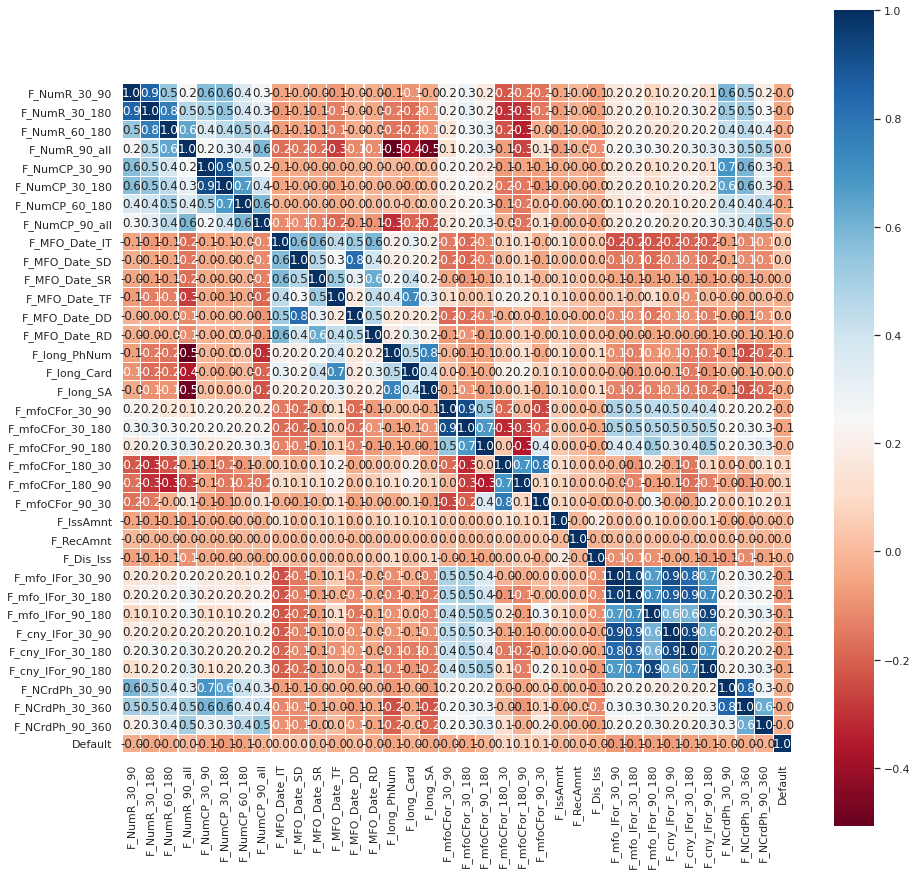

In [ ]:
corr_num4 = df[['F_NumR_30_90', 'F_NumR_30_180', 'F_NumR_60_180', 'F_NumR_90_all', 'F_NumCP_30_90', 'F_NumCP_30_180', 'F_NumCP_60_180',
 'F_NumCP_90_all', 'F_MFO_Date_lT', 'F_MFO_Date_SD', 'F_MFO_Date_SR', 'F_MFO_Date_TF', 'F_MFO_Date_DD', 'F_MFO_Date_RD',
 'F_long_PhNum', 'F_long_Card', 'F_long_SA', 'F_mfoCFor_30_90', 'F_mfoCFor_30_180', 'F_mfoCFor_90_180', 'F_mfoCFor_180_30',
 'F_mfoCFor_180_90', 'F_mfoCFor_90_30', 'F_IssAmnt', 'F_RecAmnt', 'F_Dis_Iss', 'F_mfo_IFor_30_90', 'F_mfo_IFor_30_180',
 'F_mfo_IFor_90_180', 'F_cny_IFor_30_90', 'F_cny_IFor_30_180', 'F_cny_IFor_90_180', 'F_NCrdPh_30_90', 'F_NCrdPh_30_360',
 'F_NCrdPh_90_360', 'Default']] 
sns.set(font_scale = 1)
plt.subplots(figsize = (15,15))
sns.heatmap(corr_num4.corr(), square = True,
           annot = True, fmt = ".1f", linewidths = 0.1, cmap = 'RdBu')

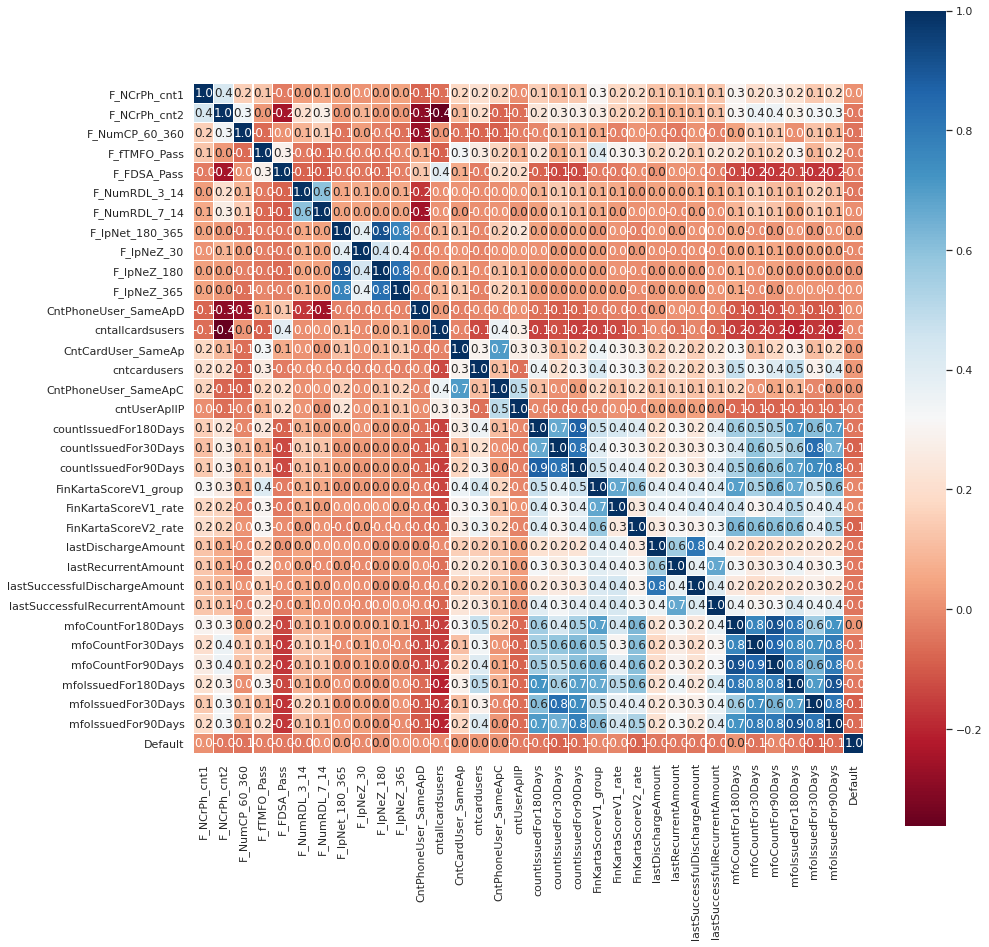

In [ ]:
corr_num5 = df[['F_NCrPh_cnt1', 'F_NCrPh_cnt2', 'F_NumCP_60_360', 'F_fTMFO_Pass', 'F_FDSA_Pass', 'F_NumRDL_3_14',
 'F_NumRDL_7_14', 'F_IpNet_180_365', 'F_IpNeZ_30', 'F_IpNeZ_180', 'F_IpNeZ_365', 'CntPhoneUser_SameApD', 'cntallcardsusers',
 'CntCardUser_SameAp', 'cntcardusers', 'CntPhoneUser_SameApC', 'cntUserAplIP', 'countIssuedFor180Days', 'countIssuedFor30Days',
 'countIssuedFor90Days', 'FinKartaScoreV1_group', 'FinKartaScoreV1_rate', 'FinKartaScoreV2_rate', 'lastDischargeAmount',
 'lastRecurrentAmount', 'lastSuccessfulDischargeAmount', 'lastSuccessfulRecurrentAmount', 'mfoCountFor180Days', 'mfoCountFor30Days',
 'mfoCountFor90Days', 'mfoIssuedFor180Days', 'mfoIssuedFor30Days', 'mfoIssuedFor90Days', 'Default']] 
sns.set(font_scale = 1)
plt.subplots(figsize = (15,15))
sns.heatmap(corr_num5.corr(), square = True,
           annot = True, fmt = ".1f", linewidths = 0.1, cmap = 'RdBu')

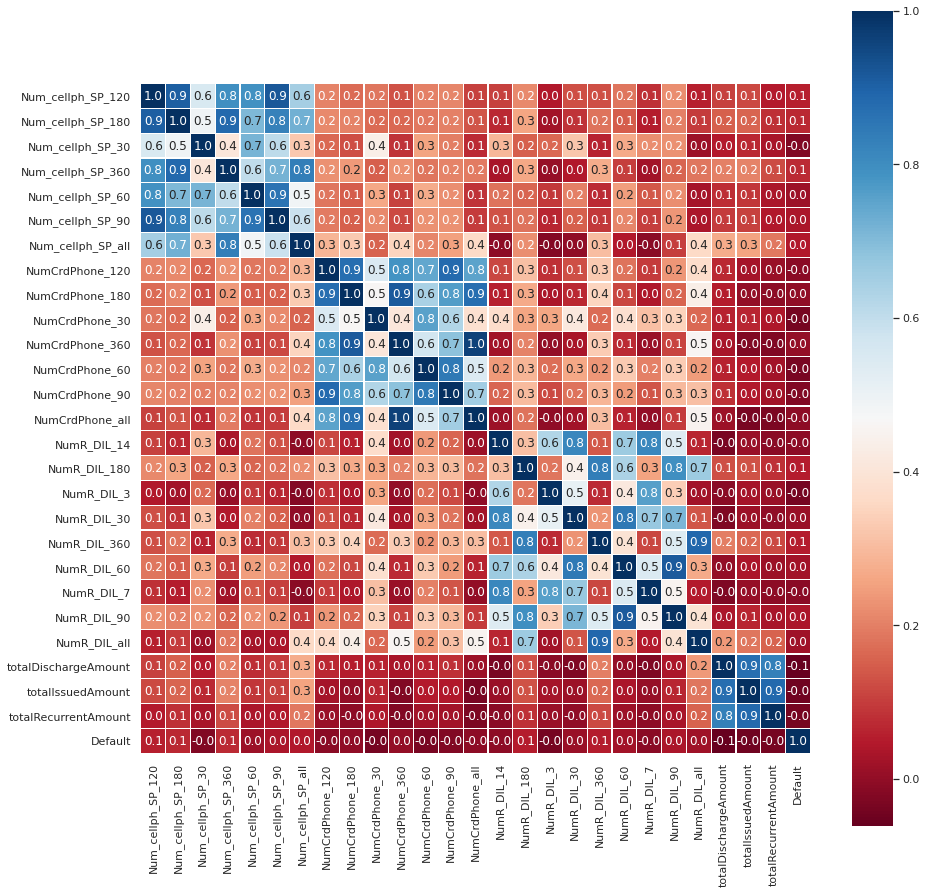

In [ ]:
corr_num6 = df[['Num_cellph_SP_120', 'Num_cellph_SP_180',
 'Num_cellph_SP_30', 'Num_cellph_SP_360', 'Num_cellph_SP_60', 'Num_cellph_SP_90', 'Num_cellph_SP_all', 'NumCrdPhone_120',
 'NumCrdPhone_180', 'NumCrdPhone_30', 'NumCrdPhone_360', 'NumCrdPhone_60', 'NumCrdPhone_90', 'NumCrdPhone_all', 
 'NumR_DIL_14', 'NumR_DIL_180', 'NumR_DIL_3', 'NumR_DIL_30', 'NumR_DIL_360', 'NumR_DIL_60', 'NumR_DIL_7', 'NumR_DIL_90', 'NumR_DIL_all',
 'totalDischargeAmount', 'totalIssuedAmount', 'totalRecurrentAmount','Default']] 
sns.set(font_scale = 1)
plt.subplots(figsize = (15,15))
sns.heatmap(corr_num6.corr(), square = True,
           annot = True, fmt = ".1f", linewidths = 0.1, cmap = 'RdBu')

#4. Генерация новых признаков


In [ ]:
#Флаг по возрасту моложе 21 года и старше 65 лет - заемщики могут потенциально не вернуть кредит:
df['flag_age'] = df.apply(lambda x: 0 if ((x.age) > 21 and (x.age < 65)) else 1, axis=1)
df['flag_age'].value_counts()

0    7887
1     574
Name: flag_age, dtype: int64

In [ ]:
#Поскольку признак содержит более 50% пропусков, и мне кажется он важным для предсказания целевой переменной, создадим еще один признак know_EarlierCredits, в котором 1 - это известные данные признака EarlierCredits, а 0 - данных нет.
df['know_EarlierCredits'] = df.apply(lambda x: 0 if (x.EarlierCredits==0) else 1, axis=1)
df['know_EarlierCredits'].value_counts()

0    4272
1    4189
Name: know_EarlierCredits, dtype: int64

In [ ]:
#Совпадение почтового индекса по адресу регистрации и по фактическому проживанию:
df['dif_code'] = df.apply(lambda x: 1 if (x.FactPostalCode==x.RegisterPostalCode) else 0, axis=1)
df['dif_code'].value_counts()

0    8103
1     358
Name: dif_code, dtype: int64

# Формирование итогового датасета для обучения

In [ ]:
df_for_model = df[['N_Loans', 'perc_amount', 'N_365', 'last_payment', 'N_90_365', 's_Amount', 's_Credit_befo_RD', 's_Credit_15',
 's_Credit_30', 's_Credit_90', 's_Credit_90_RD', 'Dola_RD_1', 'Dola_RD_2', 'Dola_RD_3', 'Dola_15_90', 'Dola_60_90', 'a_sum_Credit_700',
 'a_sum_Credit_365', 'a_sum_Credit_180', 'a_sum_Credit_90', 's_Amount_30', 's_Amount_60', 's_Amount_90', 's_Amount_180', 's_Amount_360',
 's_Amount_500', 'cred_hist_1', 'cred_hist_2', 'cred_hist_3', 'Cred_Deb_2', 'Cred_Deb_AmRe', 'Cred_Deb_AmRe_01', 'Cred_Deb_AmRe_1',
 'Cred_Deb_Deb', 'a_cnt_cred_45', 'a_cnt_cred_90', 'a_cnt_cred_135', 'a_cnt_cred_180', 'a_cnt_cred_700', 'a_cnt_cred_365',
 'miAmount_45', 'miAmount_90', 'miAmount_180', 'Amount_45', 'Amount_90', 'Amount_180', 'Amount_365', 'n_cr_1', 'n_cr_2',
 'n_cr_12', 'n_cr_3', 're_cred_1', 're_cred_2', 're_cred_3', 'persent_loan', 'cred_sum_1', 'cred_sum_2', 'cred_sum_3',
 'cred_sum_22', 'cred_sum_33', 'cred_dura_1', 'cred_dura_2', 'cred_dura_3', 'delay5_1', 'delay5_2', 'delay5_3', 'delay5_22',
 'delay5_33', 'delay30_1', 'delay30_2', 'delay30_3', 'delay60_1', 'delay60_2', 'delay60_3', 'delay90_1', 'delay90_2', 'delay90_3',
 'delay_more_1', 'delay_more_2', 'delay_more_3', 'delay5_30_365', 'delay5_30_60_365', 'cred_type_1', 'cred_type_2', 'cred_type_3',
 'partner_type_1', 'partner_type_2', 'partner_type_3', 'cred_repay_1', 'cred_repay_2', 'cred_repay_3', 'cred_activ_1',
 'cred_activ_2', 'cred_activ_3', 'all_act_cred_3', 'all_act_cred_1', 'all_act_cred_3_1', 'all_act_cred_2', 'all_act_3_1_d',
 'all_cred_rep_3', 'all_cred_rep_1', 'all_cred_rep_13', 'all_cred_rep_11', 'all_rep_cred_1', 'all_act_cred', 'all_act_cred_s',
 'test_1', 'sum_debt', 'sum_debt_1', 'sum_limit', 'sum_overdue', 'day_overdue', 'max_overdue', 'max_overdue_1',
 'max_overdue_2', 'max_overdue_3', 'prolong', 'ti_hour', 'ti_day', 'ti_week', 'ti_week_all', 'ti_month', 'ti_month_all', 'ti_quarter',
 'ti_year', 'cred_date_last', 'cred_date_last_1', 'cred_date_last_2', 'sum_debt_last', 'hist_days', 'hist_days_m', 'dog_bad',
 'dog_bad_360', 'dog_bad_1080', 'sum_over_1080', 'sum_over_720', 'sum_over_360', 'sum_over_1_89', 'sum_over_90', 'sum_over_89_90',
 'avg_over_1_90', 'sum_over_9000', 'sum_mfo', 'over_mfo', 'сoun_over_mfo', 'сount_cls_mfo', 'p_cls_mfo_365', 'sum_12_month',
 'avg_12_month', 'Count_0', 'Count_1', 'Count_2', 'Count_3', 'Count_4', 'Count_5', 'Count_6', 'Count_7', 'Count_8', 'Count_9',
 'Count_B', 'Count_C', 'Count_I', 'Count_R', 'Count_S', 'Count_Sp', 'Count_W', 'Count_0_len_num',
 'Count_01_len_num', 'Count_12_len_num', 'Count_456_len_num', 'Count_5B_len_num', 'Count_C_len_num', 'Count_Sp_len_num',
 'N_record_IP', 'min_hist_IPDate', 'max_hist_IPDate', 'min_hist_RIDDate', 'max_hist_RIDDate', 'min_hist_IPEndDate',
 'max_hist_IPEndDate', 'max_Summa', 'sum_RIDDate_365', 'sum_RIDDate_180', 'sum_RIDDate_730', 'cred_count', 'cred_summ',
 'st_NULL__180_sum', 'st_NULL__365_sum', 'st_NULL__730_sum', 'st_NULL__180_count', 'st_NULL__365_count', 'st_NULL__730_count',
 'F_NumR_30_90', 'F_NumR_30_180', 'F_NumR_60_180', 'F_NumR_90_all', 'F_NumCP_30_90', 'F_NumCP_30_180', 'F_NumCP_60_180',
 'F_NumCP_90_all', 'F_MFO_Date_lT', 'F_MFO_Date_SD', 'F_MFO_Date_SR', 'F_MFO_Date_TF', 'F_MFO_Date_DD', 'F_MFO_Date_RD',
 'F_long_PhNum', 'F_long_Card', 'F_long_SA', 'F_mfoCFor_30_90', 'F_mfoCFor_30_180', 'F_mfoCFor_90_180', 'F_mfoCFor_180_30',
 'F_mfoCFor_180_90', 'F_mfoCFor_90_30', 'F_IssAmnt', 'F_RecAmnt', 'F_Dis_Iss', 'F_mfo_IFor_30_90', 'F_mfo_IFor_30_180',
 'F_mfo_IFor_90_180', 'F_cny_IFor_30_90', 'F_cny_IFor_30_180', 'F_cny_IFor_90_180', 'F_NCrdPh_30_90', 'F_NCrdPh_30_360',
 'F_NCrdPh_90_360', 'F_NCrPh_cnt1', 'F_NCrPh_cnt2', 'F_NumCP_60_360', 'F_fTMFO_Pass', 'F_FDSA_Pass', 'F_NumRDL_3_14',
 'F_NumRDL_7_14', 'F_IpNet_180_365', 'F_IpNeZ_30', 'F_IpNeZ_180', 'F_IpNeZ_365', 'CntPhoneUser_SameApD', 'cntallcardsusers',
 'CntCardUser_SameAp', 'cntcardusers', 'CntPhoneUser_SameApC', 'cntUserAplIP', 'countIssuedFor180Days', 'countIssuedFor30Days',
 'countIssuedFor90Days', 'FinKartaScoreV1_group', 'FinKartaScoreV1_rate', 'FinKartaScoreV2_rate', 'lastDischargeAmount',
 'lastRecurrentAmount', 'lastSuccessfulDischargeAmount', 'lastSuccessfulRecurrentAmount', 'mfoCountFor180Days', 'mfoCountFor30Days',
 'mfoCountFor90Days', 'mfoIssuedFor180Days', 'mfoIssuedFor30Days', 'mfoIssuedFor90Days', 'Num_cellph_SP_120', 'Num_cellph_SP_180',
 'Num_cellph_SP_30', 'Num_cellph_SP_360', 'Num_cellph_SP_60', 'Num_cellph_SP_90', 'Num_cellph_SP_all', 'NumCrdPhone_120',
 'NumCrdPhone_180', 'NumCrdPhone_30', 'NumCrdPhone_360', 'NumCrdPhone_60', 'NumCrdPhone_90', 'NumCrdPhone_all', 'NumR_DIL_120',
 'NumR_DIL_14', 'NumR_DIL_180', 'NumR_DIL_3', 'NumR_DIL_30', 'NumR_DIL_360', 'NumR_DIL_60', 'NumR_DIL_7', 'NumR_DIL_90', 'NumR_DIL_all',
 'totalDischargeAmount', 'totalIssuedAmount', 'totalRecurrentAmount', 'age', 'Gender', 'RegisterPhone', 'Register_Fact',  
 'FactPostalCode', 'RegisterPostalCode',  'EarlierCredits',  'flag_age', 'know_EarlierCredits', 'dif_code', 'Default']]

In [ ]:
df_for_model.head()

N_Loans  perc_amount  N_365  last_payment  N_90_365  s_Amount  \
0        1     0.620701      1             5       1.0      5300   
1        4     0.055000      4             5       1.0      9000   
2        2     0.046000      2             1       1.0      5000   
3        1     0.510000      1            67       0.0      5000   
4        1     0.320000      1            75       0.0      2000   

   s_Credit_befo_RD  s_Credit_15  s_Credit_30  s_Credit_90  s_Credit_90_RD  \
0               0.0          0.0          0.0      8589.72         8589.72   
1            9495.0          0.0          0.0         0.00         9495.00   
2            5230.0          0.0          0.0         0.00         5230.00   
3            2250.0       5300.0       5300.0      5300.00         7550.00   
4               0.0       2640.0       2640.0      2640.00         2640.00   

   Dola_RD_1  Dola_RD_2  Dola_RD_3  Dola_15_90  Dola_60_90  a_sum_Credit_700  \
0        0.0        0.0        0.0         0.0         1.0           8589.72   
1        1.0        1.0        1.0         0.0         0.0           2373.75   
2        1.0        1.0        1.0         0.0         0.0           2615.00   
3        0.0        0.0        0.0         0.0         0.0           7550.00   
4        0.0        0.0        0.0         0.0         0.0           2640.00   

   a_sum_Credit_365  a_sum_Credit_180  a_sum_Credit_90  s_Amount_30  \
0           8589.72           8589.72          8589.72            0   
1           2373.75           2373.75          2373.75         2000   
2           2615.00           2615.00          2615.00         5000   
3           7550.00           7550.00             0.00            0   
4           2640.00           2640.00             0.00            0   

   s_Amount_60  s_Amount_90  s_Amount_180  s_Amount_360  s_Amount_500  \
0            0         5300          5300          5300          5300   
1         9000         9000          9000          9000          9000   
2         5000         5000          5000          5000          5000   
3            0            0          5000          5000          5000   
4            0            0          2000          2000          2000   

   cred_hist_1  cred_hist_2  cred_hist_3  Cred_Deb_2  Cred_Deb_AmRe  \
0           69           69           69      4.2949         1.6449   
1           47            6            6      1.3564         0.0707   
2           10            8            8      1.3075         0.0575   
3          101          101          101      2.5167         0.8500   
4          107          107          107      0.8800         0.2133   

   Cred_Deb_AmRe_01  Cred_Deb_AmRe_1  Cred_Deb_Deb  a_cnt_cred_45  \
0               0.0           1.6449      0.620701            0.0   
1               0.0           0.0707      0.055000            3.0   
2               0.0           0.0575      0.046000            2.0   
3               0.0           0.8500      0.510000            0.0   
4               0.0           0.2133      0.320000            0.0   

   a_cnt_cred_90  a_cnt_cred_135  a_cnt_cred_180  a_cnt_cred_700  \
0            1.0             1.0             1.0             1.0   
1            4.0             4.0             4.0             4.0   
2            2.0             2.0             2.0             2.0   
3            0.0             1.0             1.0             1.0   
4            0.0             1.0             1.0             1.0   

   a_cnt_cred_365  miAmount_45  miAmount_90  miAmount_180  Amount_45  \
0             1.0       0.0000       2.6500        2.6500     0.0000   
1             4.0       0.2857       0.2857        0.2857     0.4286   
2             2.0       0.5000       0.5000        0.5000     0.7500   
3             1.0       0.0000       0.0000        1.6667     0.0000   
4             1.0       0.0000       0.0000        0.6667     0.0000   

   Amount_90  Amount_180  Amount_365  n_cr_1  n_cr_2  n_cr_12  ...  \
0     2.6500      2.6500

In [ ]:
df_for_model.to_csv('df_for_model.csv', index=None)